<a href="https://colab.research.google.com/github/ALESTA1/MITRA/blob/main/MRCNN_Weed_detection_MITRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload


In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
from pathlib import Path

In [ ]:
!git clone https://github.com/leekunhee/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 149.27 MiB | 28.11 MiB/s, done.
Resolving deltas: 100% (572/572), done.


In [ ]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/content/Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
pip install -r '/content/Mask_RCNN/requirements.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==1.13.1 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==1.13.1


In [ ]:
pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class CocoSynthConfig(Config):
    """Configuration for training on the box_synthetic dataset.
    Derives from the base Config class and overrides specific values.
    """
    # Give the configuration a recognizable name
    NAME = "cocosynth_dataset"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 7 box types

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 1000

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CocoSynthConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [ ]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/dataSET/output/coco_instances.json',
                        '/content/dataSET/output/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/dataSET/Val/coco_instances.json',
                      '/content/dataSET/Val/images')
dataset_val.prepare()

Displaying examples from training dataset:


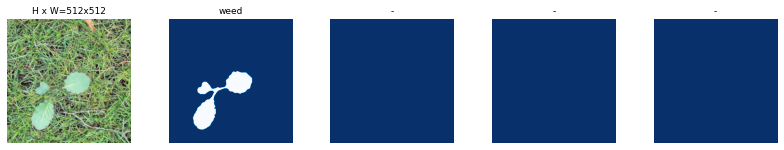

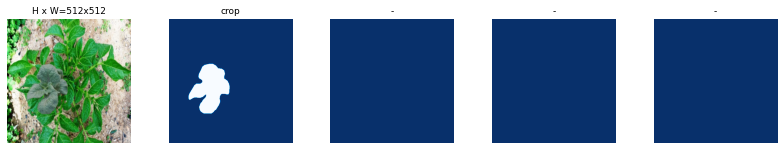

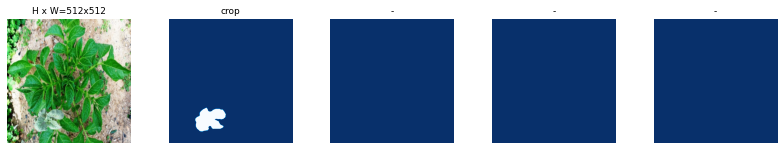

Displaying examples from validation dataset:


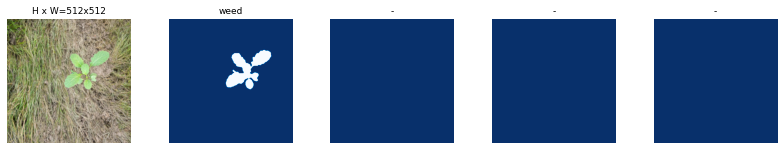

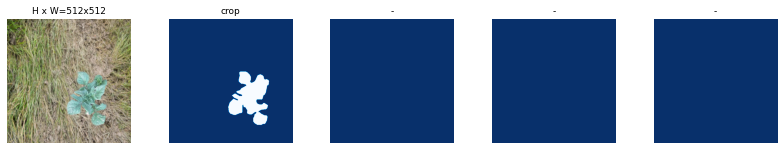

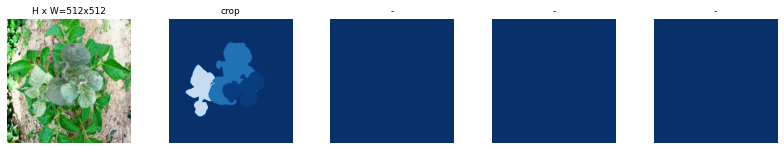

In [ ]:
for name, dataset in [('training', dataset_train), ('validation', dataset_val)]:
    print(f'Displaying examples from {name} dataset:')
    
    image_ids = np.random.choice(dataset.image_ids, 3)
    for image_id in image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/cocosynth_dataset20221222T1053/mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mr

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.8/di

Epoch 1/4


/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

   1/1000 [..............................] - ETA: 4:02:56 - batch: 0.0000e+00 - size: 1.0000 - loss: 17.0908 - rpn_class_loss: 7.9714 - rpn_bbox_loss: 4.5978 - mrcnn_class_loss: 4.5216 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   2/1000 [..............................] - ETA: 2:04:09 - batch: 0.5000 - size: 1.0000 - loss: 16.6393 - rpn_class_loss: 8.8582 - rpn_bbox_loss: 3.9959 - mrcnn_class_loss: 3.7852 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00    

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   3/1000 [..............................] - ETA: 1:55:02 - batch: 1.0000 - size: 1.0000 - loss: 12.7762 - rpn_class_loss: 6.7622 - rpn_bbox_loss: 3.3959 - mrcnn_class_loss: 2.6182 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   4/1000 [..............................] - ETA: 1:52:09 - batch: 1.5000 - size: 1.0000 - loss: 11.3469 - rpn_class_loss: 5.2499 - rpn_bbox_loss: 4.1334 - mrcnn_class_loss: 1.9637 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   5/1000 [..............................] - ETA: 1:50:52 - batch: 2.0000 - size: 1.0000 - loss: 9.8621 - rpn_class_loss: 4.2469 - rpn_bbox_loss: 4.0443 - mrcnn_class_loss: 1.5709 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   6/1000 [..............................] - ETA: 1:49:58 - batch: 2.5000 - size: 1.0000 - loss: 8.3814 - rpn_class_loss: 3.5993 - rpn_bbox_loss: 3.4730 - mrcnn_class_loss: 1.3091 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   7/1000 [..............................] - ETA: 1:50:40 - batch: 3.0000 - size: 1.0000 - loss: 7.9032 - rpn_class_loss: 3.1126 - rpn_bbox_loss: 3.1660 - mrcnn_class_loss: 1.1531 - mrcnn_bbox_loss: 0.3684 - mrcnn_mask_loss: 0.1032        

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   8/1000 [..............................] - ETA: 1:49:48 - batch: 3.5000 - size: 1.0000 - loss: 7.1029 - rpn_class_loss: 2.7302 - rpn_bbox_loss: 2.9511 - mrcnn_class_loss: 1.0090 - mrcnn_bbox_loss: 0.3224 - mrcnn_mask_loss: 0.0903

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   9/1000 [..............................] - ETA: 1:49:14 - batch: 4.0000 - size: 1.0000 - loss: 6.7674 - rpn_class_loss: 2.4290 - rpn_bbox_loss: 2.7897 - mrcnn_class_loss: 0.9243 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.1562

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  10/1000 [..............................] - ETA: 1:48:41 - batch: 4.5000 - size: 1.0000 - loss: 6.5513 - rpn_class_loss: 2.1901 - rpn_bbox_loss: 2.7302 - mrcnn_class_loss: 0.8664 - mrcnn_bbox_loss: 0.5524 - mrcnn_mask_loss: 0.2122

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  11/1000 [..............................] - ETA: 1:48:13 - batch: 5.0000 - size: 1.0000 - loss: 6.0831 - rpn_class_loss: 1.9975 - rpn_bbox_loss: 2.6028 - mrcnn_class_loss: 0.7877 - mrcnn_bbox_loss: 0.5022 - mrcnn_mask_loss: 0.1929

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  12/1000 [..............................] - ETA: 1:47:51 - batch: 5.5000 - size: 1.0000 - loss: 5.9922 - rpn_class_loss: 1.8326 - rpn_bbox_loss: 2.5985 - mrcnn_class_loss: 0.7344 - mrcnn_bbox_loss: 0.5920 - mrcnn_mask_loss: 0.2347

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  13/1000 [..............................] - ETA: 1:47:32 - batch: 6.0000 - size: 1.0000 - loss: 5.9423 - rpn_class_loss: 1.6928 - rpn_bbox_loss: 2.5486 - mrcnn_class_loss: 0.7485 - mrcnn_bbox_loss: 0.6812 - mrcnn_mask_loss: 0.2712

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  14/1000 [..............................] - ETA: 1:47:13 - batch: 6.5000 - size: 1.0000 - loss: 6.0687 - rpn_class_loss: 1.5719 - rpn_bbox_loss: 2.4978 - mrcnn_class_loss: 0.7631 - mrcnn_bbox_loss: 0.9314 - mrcnn_mask_loss: 0.3045

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  15/1000 [..............................] - ETA: 1:47:33 - batch: 7.0000 - size: 1.0000 - loss: 6.1199 - rpn_class_loss: 1.4877 - rpn_bbox_loss: 2.7665 - mrcnn_class_loss: 0.7122 - mrcnn_bbox_loss: 0.8693 - mrcnn_mask_loss: 0.2842

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  16/1000 [..............................] - ETA: 1:47:53 - batch: 7.5000 - size: 1.0000 - loss: 6.1038 - rpn_class_loss: 1.3962 - rpn_bbox_loss: 2.7348 - mrcnn_class_loss: 0.7408 - mrcnn_bbox_loss: 0.9250 - mrcnn_mask_loss: 0.3070

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  17/1000 [..............................] - ETA: 1:47:35 - batch: 8.0000 - size: 1.0000 - loss: 6.0098 - rpn_class_loss: 1.3214 - rpn_bbox_loss: 2.8316 - mrcnn_class_loss: 0.6972 - mrcnn_bbox_loss: 0.8706 - mrcnn_mask_loss: 0.2889

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  18/1000 [..............................] - ETA: 1:47:47 - batch: 8.5000 - size: 1.0000 - loss: 6.0774 - rpn_class_loss: 1.2485 - rpn_bbox_loss: 2.7858 - mrcnn_class_loss: 0.8143 - mrcnn_bbox_loss: 0.9178 - mrcnn_mask_loss: 0.3110

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  19/1000 [..............................] - ETA: 1:47:32 - batch: 9.0000 - size: 1.0000 - loss: 5.8286 - rpn_class_loss: 1.1836 - rpn_bbox_loss: 2.7095 - mrcnn_class_loss: 0.7714 - mrcnn_bbox_loss: 0.8695 - mrcnn_mask_loss: 0.2946

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  20/1000 [..............................] - ETA: 1:47:15 - batch: 9.5000 - size: 1.0000 - loss: 5.9196 - rpn_class_loss: 1.1272 - rpn_bbox_loss: 2.7396 - mrcnn_class_loss: 0.8278 - mrcnn_bbox_loss: 0.9146 - mrcnn_mask_loss: 0.3104

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  21/1000 [..............................] - ETA: 1:47:00 - batch: 10.0000 - size: 1.0000 - loss: 5.8962 - rpn_class_loss: 1.0746 - rpn_bbox_loss: 2.6935 - mrcnn_class_loss: 0.7946 - mrcnn_bbox_loss: 1.0077 - mrcnn_mask_loss: 0.3258

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  22/1000 [..............................] - ETA: 1:46:46 - batch: 10.5000 - size: 1.0000 - loss: 5.8992 - rpn_class_loss: 1.0344 - rpn_bbox_loss: 2.7286 - mrcnn_class_loss: 0.7595 - mrcnn_bbox_loss: 1.0349 - mrcnn_mask_loss: 0.3419

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  23/1000 [..............................] - ETA: 1:46:33 - batch: 11.0000 - size: 1.0000 - loss: 5.8284 - rpn_class_loss: 0.9915 - rpn_bbox_loss: 2.7032 - mrcnn_class_loss: 0.7376 - mrcnn_bbox_loss: 1.0421 - mrcnn_mask_loss: 0.3540

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  24/1000 [..............................] - ETA: 1:46:45 - batch: 11.5000 - size: 1.0000 - loss: 5.6858 - rpn_class_loss: 0.9506 - rpn_bbox_loss: 2.6903 - mrcnn_class_loss: 0.7069 - mrcnn_bbox_loss: 0.9987 - mrcnn_mask_loss: 0.3393

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  25/1000 [..............................] - ETA: 1:46:54 - batch: 12.0000 - size: 1.0000 - loss: 5.8038 - rpn_class_loss: 0.9166 - rpn_bbox_loss: 2.7095 - mrcnn_class_loss: 0.6912 - mrcnn_bbox_loss: 1.1364 - mrcnn_mask_loss: 0.3503

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  26/1000 [..............................] - ETA: 1:46:40 - batch: 12.5000 - size: 1.0000 - loss: 5.9100 - rpn_class_loss: 0.8820 - rpn_bbox_loss: 2.7023 - mrcnn_class_loss: 0.7674 - mrcnn_bbox_loss: 1.1945 - mrcnn_mask_loss: 0.3639

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  27/1000 [..............................] - ETA: 1:47:23 - batch: 13.0000 - size: 1.0000 - loss: 5.7735 - rpn_class_loss: 0.8573 - rpn_bbox_loss: 2.6767 - mrcnn_class_loss: 0.7390 - mrcnn_bbox_loss: 1.1503 - mrcnn_mask_loss: 0.3504

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  28/1000 [..............................] - ETA: 1:47:08 - batch: 13.5000 - size: 1.0000 - loss: 5.7490 - rpn_class_loss: 0.8274 - rpn_bbox_loss: 2.6053 - mrcnn_class_loss: 0.7217 - mrcnn_bbox_loss: 1.2328 - mrcnn_mask_loss: 0.3618

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  29/1000 [..............................] - ETA: 1:47:21 - batch: 14.0000 - size: 1.0000 - loss: 5.8458 - rpn_class_loss: 0.7989 - rpn_bbox_loss: 2.5965 - mrcnn_class_loss: 0.7049 - mrcnn_bbox_loss: 1.3665 - mrcnn_mask_loss: 0.3790

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  30/1000 [..............................] - ETA: 1:47:46 - batch: 14.5000 - size: 1.0000 - loss: 5.8150 - rpn_class_loss: 0.7728 - rpn_bbox_loss: 2.5797 - mrcnn_class_loss: 0.6817 - mrcnn_bbox_loss: 1.3928 - mrcnn_mask_loss: 0.3880

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  31/1000 [..............................] - ETA: 1:47:50 - batch: 15.0000 - size: 1.0000 - loss: 5.7101 - rpn_class_loss: 0.7483 - rpn_bbox_loss: 2.5787 - mrcnn_class_loss: 0.6597 - mrcnn_bbox_loss: 1.3479 - mrcnn_mask_loss: 0.3755

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  32/1000 [..............................] - ETA: 1:47:52 - batch: 15.5000 - size: 1.0000 - loss: 5.6671 - rpn_class_loss: 0.7251 - rpn_bbox_loss: 2.5495 - mrcnn_class_loss: 0.6516 - mrcnn_bbox_loss: 1.3575 - mrcnn_mask_loss: 0.3834

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  33/1000 [..............................] - ETA: 1:47:56 - batch: 16.0000 - size: 1.0000 - loss: 5.6779 - rpn_class_loss: 0.7044 - rpn_bbox_loss: 2.5421 - mrcnn_class_loss: 0.6485 - mrcnn_bbox_loss: 1.3895 - mrcnn_mask_loss: 0.3935

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  34/1000 [>.............................] - ETA: 1:47:42 - batch: 16.5000 - size: 1.0000 - loss: 5.5881 - rpn_class_loss: 0.6842 - rpn_bbox_loss: 2.4874 - mrcnn_class_loss: 0.6411 - mrcnn_bbox_loss: 1.3744 - mrcnn_mask_loss: 0.4010

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  35/1000 [>.............................] - ETA: 1:47:27 - batch: 17.0000 - size: 1.0000 - loss: 5.6009 - rpn_class_loss: 0.6655 - rpn_bbox_loss: 2.4599 - mrcnn_class_loss: 0.6638 - mrcnn_bbox_loss: 1.4032 - mrcnn_mask_loss: 0.4086

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  36/1000 [>.............................] - ETA: 1:47:28 - batch: 17.5000 - size: 1.0000 - loss: 5.5562 - rpn_class_loss: 0.6472 - rpn_bbox_loss: 2.4301 - mrcnn_class_loss: 0.6657 - mrcnn_bbox_loss: 1.3964 - mrcnn_mask_loss: 0.4169

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  37/1000 [>.............................] - ETA: 1:47:27 - batch: 18.0000 - size: 1.0000 - loss: 5.5108 - rpn_class_loss: 0.6308 - rpn_bbox_loss: 2.3836 - mrcnn_class_loss: 0.6713 - mrcnn_bbox_loss: 1.4015 - mrcnn_mask_loss: 0.4236

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  38/1000 [>.............................] - ETA: 1:47:11 - batch: 18.5000 - size: 1.0000 - loss: 5.4056 - rpn_class_loss: 0.6144 - rpn_bbox_loss: 2.3605 - mrcnn_class_loss: 0.6536 - mrcnn_bbox_loss: 1.3646 - mrcnn_mask_loss: 0.4125

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  39/1000 [>.............................] - ETA: 1:47:12 - batch: 19.0000 - size: 1.0000 - loss: 5.3785 - rpn_class_loss: 0.5996 - rpn_bbox_loss: 2.3455 - mrcnn_class_loss: 0.6573 - mrcnn_bbox_loss: 1.3579 - mrcnn_mask_loss: 0.4182

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  40/1000 [>.............................] - ETA: 1:46:58 - batch: 19.5000 - size: 1.0000 - loss: 5.5441 - rpn_class_loss: 0.5866 - rpn_bbox_loss: 2.4205 - mrcnn_class_loss: 0.6522 - mrcnn_bbox_loss: 1.4614 - mrcnn_mask_loss: 0.4234

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  41/1000 [>.............................] - ETA: 1:46:57 - batch: 20.0000 - size: 1.0000 - loss: 5.5118 - rpn_class_loss: 0.5731 - rpn_bbox_loss: 2.3894 - mrcnn_class_loss: 0.6542 - mrcnn_bbox_loss: 1.4649 - mrcnn_mask_loss: 0.4303

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  42/1000 [>.............................] - ETA: 1:46:56 - batch: 20.5000 - size: 1.0000 - loss: 5.5029 - rpn_class_loss: 0.5625 - rpn_bbox_loss: 2.3883 - mrcnn_class_loss: 0.6550 - mrcnn_bbox_loss: 1.4629 - mrcnn_mask_loss: 0.4341

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  43/1000 [>.............................] - ETA: 1:46:43 - batch: 21.0000 - size: 1.0000 - loss: 5.5136 - rpn_class_loss: 0.5500 - rpn_bbox_loss: 2.3699 - mrcnn_class_loss: 0.6486 - mrcnn_bbox_loss: 1.5049 - mrcnn_mask_loss: 0.4402

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  44/1000 [>.............................] - ETA: 1:46:30 - batch: 21.5000 - size: 1.0000 - loss: 5.5819 - rpn_class_loss: 0.5379 - rpn_bbox_loss: 2.4459 - mrcnn_class_loss: 0.6409 - mrcnn_bbox_loss: 1.5119 - mrcnn_mask_loss: 0.4454

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  45/1000 [>.............................] - ETA: 1:46:29 - batch: 22.0000 - size: 1.0000 - loss: 5.5987 - rpn_class_loss: 0.5266 - rpn_bbox_loss: 2.4853 - mrcnn_class_loss: 0.6322 - mrcnn_bbox_loss: 1.5037 - mrcnn_mask_loss: 0.4510

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  46/1000 [>.............................] - ETA: 1:46:28 - batch: 22.5000 - size: 1.0000 - loss: 5.5623 - rpn_class_loss: 0.5157 - rpn_bbox_loss: 2.5159 - mrcnn_class_loss: 0.6184 - mrcnn_bbox_loss: 1.4710 - mrcnn_mask_loss: 0.4412

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  47/1000 [>.............................] - ETA: 1:46:17 - batch: 23.0000 - size: 1.0000 - loss: 5.5559 - rpn_class_loss: 0.5055 - rpn_bbox_loss: 2.5163 - mrcnn_class_loss: 0.6199 - mrcnn_bbox_loss: 1.4680 - mrcnn_mask_loss: 0.4463

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  48/1000 [>.............................] - ETA: 1:46:17 - batch: 23.5000 - size: 1.0000 - loss: 5.5088 - rpn_class_loss: 0.4958 - rpn_bbox_loss: 2.5316 - mrcnn_class_loss: 0.6070 - mrcnn_bbox_loss: 1.4374 - mrcnn_mask_loss: 0.4370

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  49/1000 [>.............................] - ETA: 1:46:04 - batch: 24.0000 - size: 1.0000 - loss: 5.5001 - rpn_class_loss: 0.4865 - rpn_bbox_loss: 2.5265 - mrcnn_class_loss: 0.5988 - mrcnn_bbox_loss: 1.4460 - mrcnn_mask_loss: 0.4423

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  50/1000 [>.............................] - ETA: 1:45:52 - batch: 24.5000 - size: 1.0000 - loss: 5.5312 - rpn_class_loss: 0.4773 - rpn_bbox_loss: 2.5322 - mrcnn_class_loss: 0.5869 - mrcnn_bbox_loss: 1.4875 - mrcnn_mask_loss: 0.4474

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  51/1000 [>.............................] - ETA: 1:45:52 - batch: 25.0000 - size: 1.0000 - loss: 5.4498 - rpn_class_loss: 0.4682 - rpn_bbox_loss: 2.5092 - mrcnn_class_loss: 0.5754 - mrcnn_bbox_loss: 1.4584 - mrcnn_mask_loss: 0.4386

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  52/1000 [>.............................] - ETA: 1:45:40 - batch: 25.5000 - size: 1.0000 - loss: 5.3872 - rpn_class_loss: 0.4594 - rpn_bbox_loss: 2.5029 - mrcnn_class_loss: 0.5643 - mrcnn_bbox_loss: 1.4303 - mrcnn_mask_loss: 0.4302

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  53/1000 [>.............................] - ETA: 1:45:28 - batch: 26.0000 - size: 1.0000 - loss: 5.3776 - rpn_class_loss: 0.4513 - rpn_bbox_loss: 2.4862 - mrcnn_class_loss: 0.5699 - mrcnn_bbox_loss: 1.4362 - mrcnn_mask_loss: 0.4340

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  54/1000 [>.............................] - ETA: 1:45:26 - batch: 26.5000 - size: 1.0000 - loss: 5.3205 - rpn_class_loss: 0.4437 - rpn_bbox_loss: 2.4818 - mrcnn_class_loss: 0.5593 - mrcnn_bbox_loss: 1.4096 - mrcnn_mask_loss: 0.4260

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  55/1000 [>.............................] - ETA: 1:45:14 - batch: 27.0000 - size: 1.0000 - loss: 5.2824 - rpn_class_loss: 0.4361 - rpn_bbox_loss: 2.4949 - mrcnn_class_loss: 0.5492 - mrcnn_bbox_loss: 1.3840 - mrcnn_mask_loss: 0.4182

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  56/1000 [>.............................] - ETA: 1:45:12 - batch: 27.5000 - size: 1.0000 - loss: 5.2822 - rpn_class_loss: 0.4292 - rpn_bbox_loss: 2.4819 - mrcnn_class_loss: 0.5538 - mrcnn_bbox_loss: 1.3945 - mrcnn_mask_loss: 0.4229

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  57/1000 [>.............................] - ETA: 1:45:10 - batch: 28.0000 - size: 1.0000 - loss: 5.2441 - rpn_class_loss: 0.4226 - rpn_bbox_loss: 2.4677 - mrcnn_class_loss: 0.5449 - mrcnn_bbox_loss: 1.3833 - mrcnn_mask_loss: 0.4257

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  58/1000 [>.............................] - ETA: 1:44:58 - batch: 28.5000 - size: 1.0000 - loss: 5.2091 - rpn_class_loss: 0.4157 - rpn_bbox_loss: 2.4452 - mrcnn_class_loss: 0.5375 - mrcnn_bbox_loss: 1.3816 - mrcnn_mask_loss: 0.4292

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  59/1000 [>.............................] - ETA: 1:44:49 - batch: 29.0000 - size: 1.0000 - loss: 5.1776 - rpn_class_loss: 0.4089 - rpn_bbox_loss: 2.4279 - mrcnn_class_loss: 0.5309 - mrcnn_bbox_loss: 1.3766 - mrcnn_mask_loss: 0.4332

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  60/1000 [>.............................] - ETA: 1:44:55 - batch: 29.5000 - size: 1.0000 - loss: 5.1437 - rpn_class_loss: 0.4030 - rpn_bbox_loss: 2.4390 - mrcnn_class_loss: 0.5221 - mrcnn_bbox_loss: 1.3537 - mrcnn_mask_loss: 0.4260

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  61/1000 [>.............................] - ETA: 1:44:52 - batch: 30.0000 - size: 1.0000 - loss: 5.1352 - rpn_class_loss: 0.3979 - rpn_bbox_loss: 2.4290 - mrcnn_class_loss: 0.5171 - mrcnn_bbox_loss: 1.3611 - mrcnn_mask_loss: 0.4302

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  62/1000 [>.............................] - ETA: 1:44:41 - batch: 30.5000 - size: 1.0000 - loss: 5.1258 - rpn_class_loss: 0.3923 - rpn_bbox_loss: 2.4237 - mrcnn_class_loss: 0.5119 - mrcnn_bbox_loss: 1.3638 - mrcnn_mask_loss: 0.4341

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  63/1000 [>.............................] - ETA: 1:44:30 - batch: 31.0000 - size: 1.0000 - loss: 5.0981 - rpn_class_loss: 0.3869 - rpn_bbox_loss: 2.4019 - mrcnn_class_loss: 0.5177 - mrcnn_bbox_loss: 1.3545 - mrcnn_mask_loss: 0.4371

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  64/1000 [>.............................] - ETA: 1:44:26 - batch: 31.5000 - size: 1.0000 - loss: 5.0620 - rpn_class_loss: 0.3821 - rpn_bbox_loss: 2.3905 - mrcnn_class_loss: 0.5097 - mrcnn_bbox_loss: 1.3392 - mrcnn_mask_loss: 0.4405

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  65/1000 [>.............................] - ETA: 1:44:15 - batch: 32.0000 - size: 1.0000 - loss: 5.0309 - rpn_class_loss: 0.3768 - rpn_bbox_loss: 2.3751 - mrcnn_class_loss: 0.5047 - mrcnn_bbox_loss: 1.3315 - mrcnn_mask_loss: 0.4428

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  66/1000 [>.............................] - ETA: 1:44:05 - batch: 32.5000 - size: 1.0000 - loss: 5.0336 - rpn_class_loss: 0.3737 - rpn_bbox_loss: 2.3764 - mrcnn_class_loss: 0.5041 - mrcnn_bbox_loss: 1.3334 - mrcnn_mask_loss: 0.4459

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  67/1000 [=>............................] - ETA: 1:44:01 - batch: 33.0000 - size: 1.0000 - loss: 5.0198 - rpn_class_loss: 0.3685 - rpn_bbox_loss: 2.3565 - mrcnn_class_loss: 0.5109 - mrcnn_bbox_loss: 1.3347 - mrcnn_mask_loss: 0.4493

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  68/1000 [=>............................] - ETA: 1:43:50 - batch: 33.5000 - size: 1.0000 - loss: 5.0174 - rpn_class_loss: 0.3639 - rpn_bbox_loss: 2.3467 - mrcnn_class_loss: 0.5076 - mrcnn_bbox_loss: 1.3466 - mrcnn_mask_loss: 0.4526

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  69/1000 [=>............................] - ETA: 1:43:40 - batch: 34.0000 - size: 1.0000 - loss: 5.0028 - rpn_class_loss: 0.3589 - rpn_bbox_loss: 2.3317 - mrcnn_class_loss: 0.5024 - mrcnn_bbox_loss: 1.3542 - mrcnn_mask_loss: 0.4557

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  70/1000 [=>............................] - ETA: 1:43:29 - batch: 34.5000 - size: 1.0000 - loss: 4.9683 - rpn_class_loss: 0.3542 - rpn_bbox_loss: 2.3148 - mrcnn_class_loss: 0.4961 - mrcnn_bbox_loss: 1.3444 - mrcnn_mask_loss: 0.4588

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  71/1000 [=>............................] - ETA: 1:43:26 - batch: 35.0000 - size: 1.0000 - loss: 4.9646 - rpn_class_loss: 0.3498 - rpn_bbox_loss: 2.3043 - mrcnn_class_loss: 0.5024 - mrcnn_bbox_loss: 1.3469 - mrcnn_mask_loss: 0.4611

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  72/1000 [=>............................] - ETA: 1:43:21 - batch: 35.5000 - size: 1.0000 - loss: 4.9310 - rpn_class_loss: 0.3459 - rpn_bbox_loss: 2.3067 - mrcnn_class_loss: 0.4955 - mrcnn_bbox_loss: 1.3282 - mrcnn_mask_loss: 0.4547

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  73/1000 [=>............................] - ETA: 1:43:11 - batch: 36.0000 - size: 1.0000 - loss: 4.9325 - rpn_class_loss: 0.3418 - rpn_bbox_loss: 2.3038 - mrcnn_class_loss: 0.5009 - mrcnn_bbox_loss: 1.3297 - mrcnn_mask_loss: 0.4564

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  74/1000 [=>............................] - ETA: 1:43:01 - batch: 36.5000 - size: 1.0000 - loss: 4.9185 - rpn_class_loss: 0.3378 - rpn_bbox_loss: 2.2884 - mrcnn_class_loss: 0.4990 - mrcnn_bbox_loss: 1.3344 - mrcnn_mask_loss: 0.4590

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  75/1000 [=>............................] - ETA: 1:42:57 - batch: 37.0000 - size: 1.0000 - loss: 4.9029 - rpn_class_loss: 0.3337 - rpn_bbox_loss: 2.2745 - mrcnn_class_loss: 0.4946 - mrcnn_bbox_loss: 1.3384 - mrcnn_mask_loss: 0.4617

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  76/1000 [=>............................] - ETA: 1:42:53 - batch: 37.5000 - size: 1.0000 - loss: 4.8836 - rpn_class_loss: 0.3294 - rpn_bbox_loss: 2.2586 - mrcnn_class_loss: 0.4902 - mrcnn_bbox_loss: 1.3414 - mrcnn_mask_loss: 0.4641

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  77/1000 [=>............................] - ETA: 1:42:50 - batch: 38.0000 - size: 1.0000 - loss: 4.9444 - rpn_class_loss: 0.3255 - rpn_bbox_loss: 2.2602 - mrcnn_class_loss: 0.5382 - mrcnn_bbox_loss: 1.3542 - mrcnn_mask_loss: 0.4663

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  78/1000 [=>............................] - ETA: 1:42:40 - batch: 38.5000 - size: 1.0000 - loss: 4.9357 - rpn_class_loss: 0.3219 - rpn_bbox_loss: 2.2613 - mrcnn_class_loss: 0.5327 - mrcnn_bbox_loss: 1.3503 - mrcnn_mask_loss: 0.4695

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  79/1000 [=>............................] - ETA: 1:42:35 - batch: 39.0000 - size: 1.0000 - loss: 4.9168 - rpn_class_loss: 0.3182 - rpn_bbox_loss: 2.2490 - mrcnn_class_loss: 0.5303 - mrcnn_bbox_loss: 1.3480 - mrcnn_mask_loss: 0.4714

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  80/1000 [=>............................] - ETA: 1:42:25 - batch: 39.5000 - size: 1.0000 - loss: 4.9116 - rpn_class_loss: 0.3151 - rpn_bbox_loss: 2.2381 - mrcnn_class_loss: 0.5420 - mrcnn_bbox_loss: 1.3435 - mrcnn_mask_loss: 0.4728

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  81/1000 [=>............................] - ETA: 1:42:15 - batch: 40.0000 - size: 1.0000 - loss: 4.8897 - rpn_class_loss: 0.3115 - rpn_bbox_loss: 2.2242 - mrcnn_class_loss: 0.5381 - mrcnn_bbox_loss: 1.3407 - mrcnn_mask_loss: 0.4751

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  82/1000 [=>............................] - ETA: 1:42:11 - batch: 40.5000 - size: 1.0000 - loss: 4.8809 - rpn_class_loss: 0.3085 - rpn_bbox_loss: 2.2161 - mrcnn_class_loss: 0.5379 - mrcnn_bbox_loss: 1.3417 - mrcnn_mask_loss: 0.4768

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  83/1000 [=>............................] - ETA: 1:42:02 - batch: 41.0000 - size: 1.0000 - loss: 4.8553 - rpn_class_loss: 0.3051 - rpn_bbox_loss: 2.2062 - mrcnn_class_loss: 0.5330 - mrcnn_bbox_loss: 1.3318 - mrcnn_mask_loss: 0.4792

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  84/1000 [=>............................] - ETA: 1:41:58 - batch: 41.5000 - size: 1.0000 - loss: 4.8439 - rpn_class_loss: 0.3019 - rpn_bbox_loss: 2.1923 - mrcnn_class_loss: 0.5429 - mrcnn_bbox_loss: 1.3260 - mrcnn_mask_loss: 0.4808

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  85/1000 [=>............................] - ETA: 1:41:48 - batch: 42.0000 - size: 1.0000 - loss: 4.8440 - rpn_class_loss: 0.2986 - rpn_bbox_loss: 2.1935 - mrcnn_class_loss: 0.5428 - mrcnn_bbox_loss: 1.3264 - mrcnn_mask_loss: 0.4826

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  86/1000 [=>............................] - ETA: 1:41:39 - batch: 42.5000 - size: 1.0000 - loss: 4.8335 - rpn_class_loss: 0.2955 - rpn_bbox_loss: 2.1859 - mrcnn_class_loss: 0.5439 - mrcnn_bbox_loss: 1.3234 - mrcnn_mask_loss: 0.4848

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  87/1000 [=>............................] - ETA: 1:41:36 - batch: 43.0000 - size: 1.0000 - loss: 4.8139 - rpn_class_loss: 0.2925 - rpn_bbox_loss: 2.1753 - mrcnn_class_loss: 0.5455 - mrcnn_bbox_loss: 1.3150 - mrcnn_mask_loss: 0.4857

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  88/1000 [=>............................] - ETA: 1:41:27 - batch: 43.5000 - size: 1.0000 - loss: 4.7864 - rpn_class_loss: 0.2893 - rpn_bbox_loss: 2.1543 - mrcnn_class_loss: 0.5438 - mrcnn_bbox_loss: 1.3115 - mrcnn_mask_loss: 0.4875

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  89/1000 [=>............................] - ETA: 1:41:26 - batch: 44.0000 - size: 1.0000 - loss: 4.7725 - rpn_class_loss: 0.2862 - rpn_bbox_loss: 2.1492 - mrcnn_class_loss: 0.5414 - mrcnn_bbox_loss: 1.3064 - mrcnn_mask_loss: 0.4893

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  90/1000 [=>............................] - ETA: 1:41:29 - batch: 44.5000 - size: 1.0000 - loss: 4.7511 - rpn_class_loss: 0.2833 - rpn_bbox_loss: 2.1341 - mrcnn_class_loss: 0.5411 - mrcnn_bbox_loss: 1.3017 - mrcnn_mask_loss: 0.4908

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  91/1000 [=>............................] - ETA: 1:41:26 - batch: 45.0000 - size: 1.0000 - loss: 4.7731 - rpn_class_loss: 0.2878 - rpn_bbox_loss: 2.1446 - mrcnn_class_loss: 0.5440 - mrcnn_bbox_loss: 1.3040 - mrcnn_mask_loss: 0.4927

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  92/1000 [=>............................] - ETA: 1:41:17 - batch: 45.5000 - size: 1.0000 - loss: 4.7579 - rpn_class_loss: 0.2850 - rpn_bbox_loss: 2.1306 - mrcnn_class_loss: 0.5486 - mrcnn_bbox_loss: 1.2989 - mrcnn_mask_loss: 0.4948

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  93/1000 [=>............................] - ETA: 1:41:07 - batch: 46.0000 - size: 1.0000 - loss: 4.7462 - rpn_class_loss: 0.2826 - rpn_bbox_loss: 2.1254 - mrcnn_class_loss: 0.5471 - mrcnn_bbox_loss: 1.2948 - mrcnn_mask_loss: 0.4963

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  94/1000 [=>............................] - ETA: 1:40:58 - batch: 46.5000 - size: 1.0000 - loss: 4.7339 - rpn_class_loss: 0.2799 - rpn_bbox_loss: 2.1169 - mrcnn_class_loss: 0.5451 - mrcnn_bbox_loss: 1.2940 - mrcnn_mask_loss: 0.4979

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  95/1000 [=>............................] - ETA: 1:40:49 - batch: 47.0000 - size: 1.0000 - loss: 4.7240 - rpn_class_loss: 0.2771 - rpn_bbox_loss: 2.1106 - mrcnn_class_loss: 0.5421 - mrcnn_bbox_loss: 1.2956 - mrcnn_mask_loss: 0.4985

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  96/1000 [=>............................] - ETA: 1:40:45 - batch: 47.5000 - size: 1.0000 - loss: 4.7062 - rpn_class_loss: 0.2747 - rpn_bbox_loss: 2.0985 - mrcnn_class_loss: 0.5432 - mrcnn_bbox_loss: 1.2894 - mrcnn_mask_loss: 0.5005

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  97/1000 [=>............................] - ETA: 1:40:36 - batch: 48.0000 - size: 1.0000 - loss: 4.6982 - rpn_class_loss: 0.2722 - rpn_bbox_loss: 2.0915 - mrcnn_class_loss: 0.5385 - mrcnn_bbox_loss: 1.2941 - mrcnn_mask_loss: 0.5018

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  98/1000 [=>............................] - ETA: 1:40:32 - batch: 48.5000 - size: 1.0000 - loss: 4.7038 - rpn_class_loss: 0.2698 - rpn_bbox_loss: 2.0964 - mrcnn_class_loss: 0.5354 - mrcnn_bbox_loss: 1.2990 - mrcnn_mask_loss: 0.5032

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  99/1000 [=>............................] - ETA: 1:40:27 - batch: 49.0000 - size: 1.0000 - loss: 4.7104 - rpn_class_loss: 0.2674 - rpn_bbox_loss: 2.1025 - mrcnn_class_loss: 0.5364 - mrcnn_bbox_loss: 1.2999 - mrcnn_mask_loss: 0.5041

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 100/1000 [==>...........................] - ETA: 1:40:18 - batch: 49.5000 - size: 1.0000 - loss: 4.7049 - rpn_class_loss: 0.2648 - rpn_bbox_loss: 2.1089 - mrcnn_class_loss: 0.5312 - mrcnn_bbox_loss: 1.2947 - mrcnn_mask_loss: 0.5053

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 101/1000 [==>...........................] - ETA: 1:40:14 - batch: 50.0000 - size: 1.0000 - loss: 4.6764 - rpn_class_loss: 0.2624 - rpn_bbox_loss: 2.1059 - mrcnn_class_loss: 0.5259 - mrcnn_bbox_loss: 1.2819 - mrcnn_mask_loss: 0.5003

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 102/1000 [==>...........................] - ETA: 1:40:09 - batch: 50.5000 - size: 1.0000 - loss: 4.6641 - rpn_class_loss: 0.2602 - rpn_bbox_loss: 2.1011 - mrcnn_class_loss: 0.5258 - mrcnn_bbox_loss: 1.2760 - mrcnn_mask_loss: 0.5011

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 103/1000 [==>...........................] - ETA: 1:40:04 - batch: 51.0000 - size: 1.0000 - loss: 4.6435 - rpn_class_loss: 0.2578 - rpn_bbox_loss: 2.0883 - mrcnn_class_loss: 0.5227 - mrcnn_bbox_loss: 1.2719 - mrcnn_mask_loss: 0.5029

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 104/1000 [==>...........................] - ETA: 1:40:00 - batch: 51.5000 - size: 1.0000 - loss: 4.6327 - rpn_class_loss: 0.2558 - rpn_bbox_loss: 2.0826 - mrcnn_class_loss: 0.5236 - mrcnn_bbox_loss: 1.2681 - mrcnn_mask_loss: 0.5026

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 105/1000 [==>...........................] - ETA: 1:39:55 - batch: 52.0000 - size: 1.0000 - loss: 4.6278 - rpn_class_loss: 0.2538 - rpn_bbox_loss: 2.0735 - mrcnn_class_loss: 0.5277 - mrcnn_bbox_loss: 1.2682 - mrcnn_mask_loss: 0.5045

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 106/1000 [==>...........................] - ETA: 1:39:50 - batch: 52.5000 - size: 1.0000 - loss: 4.6195 - rpn_class_loss: 0.2519 - rpn_bbox_loss: 2.0734 - mrcnn_class_loss: 0.5270 - mrcnn_bbox_loss: 1.2614 - mrcnn_mask_loss: 0.5059

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 107/1000 [==>...........................] - ETA: 1:39:45 - batch: 53.0000 - size: 1.0000 - loss: 4.6059 - rpn_class_loss: 0.2497 - rpn_bbox_loss: 2.0670 - mrcnn_class_loss: 0.5270 - mrcnn_bbox_loss: 1.2551 - mrcnn_mask_loss: 0.5071

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 108/1000 [==>...........................] - ETA: 1:39:39 - batch: 53.5000 - size: 1.0000 - loss: 4.6009 - rpn_class_loss: 0.2475 - rpn_bbox_loss: 2.0665 - mrcnn_class_loss: 0.5263 - mrcnn_bbox_loss: 1.2519 - mrcnn_mask_loss: 0.5087

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 109/1000 [==>...........................] - ETA: 1:39:35 - batch: 54.0000 - size: 1.0000 - loss: 4.5881 - rpn_class_loss: 0.2455 - rpn_bbox_loss: 2.0641 - mrcnn_class_loss: 0.5242 - mrcnn_bbox_loss: 1.2441 - mrcnn_mask_loss: 0.5101

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 110/1000 [==>...........................] - ETA: 1:39:30 - batch: 54.5000 - size: 1.0000 - loss: 4.5756 - rpn_class_loss: 0.2435 - rpn_bbox_loss: 2.0606 - mrcnn_class_loss: 0.5227 - mrcnn_bbox_loss: 1.2371 - mrcnn_mask_loss: 0.5117

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 111/1000 [==>...........................] - ETA: 1:39:24 - batch: 55.0000 - size: 1.0000 - loss: 4.5675 - rpn_class_loss: 0.2416 - rpn_bbox_loss: 2.0558 - mrcnn_class_loss: 0.5240 - mrcnn_bbox_loss: 1.2330 - mrcnn_mask_loss: 0.5130

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 112/1000 [==>...........................] - ETA: 1:39:15 - batch: 55.5000 - size: 1.0000 - loss: 4.5527 - rpn_class_loss: 0.2396 - rpn_bbox_loss: 2.0482 - mrcnn_class_loss: 0.5201 - mrcnn_bbox_loss: 1.2306 - mrcnn_mask_loss: 0.5141

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 113/1000 [==>...........................] - ETA: 1:39:06 - batch: 56.0000 - size: 1.0000 - loss: 4.5454 - rpn_class_loss: 0.2377 - rpn_bbox_loss: 2.0423 - mrcnn_class_loss: 0.5184 - mrcnn_bbox_loss: 1.2318 - mrcnn_mask_loss: 0.5152

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 114/1000 [==>...........................] - ETA: 1:38:57 - batch: 56.5000 - size: 1.0000 - loss: 4.5340 - rpn_class_loss: 0.2362 - rpn_bbox_loss: 2.0351 - mrcnn_class_loss: 0.5153 - mrcnn_bbox_loss: 1.2307 - mrcnn_mask_loss: 0.5166

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 115/1000 [==>...........................] - ETA: 1:38:47 - batch: 57.0000 - size: 1.0000 - loss: 4.5245 - rpn_class_loss: 0.2342 - rpn_bbox_loss: 2.0473 - mrcnn_class_loss: 0.5109 - mrcnn_bbox_loss: 1.2200 - mrcnn_mask_loss: 0.5122

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 116/1000 [==>...........................] - ETA: 1:38:38 - batch: 57.5000 - size: 1.0000 - loss: 4.5034 - rpn_class_loss: 0.2326 - rpn_bbox_loss: 2.0472 - mrcnn_class_loss: 0.5065 - mrcnn_bbox_loss: 1.2095 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 117/1000 [==>...........................] - ETA: 1:38:39 - batch: 58.0000 - size: 1.0000 - loss: 4.5064 - rpn_class_loss: 0.2307 - rpn_bbox_loss: 2.0441 - mrcnn_class_loss: 0.5045 - mrcnn_bbox_loss: 1.2181 - mrcnn_mask_loss: 0.5089

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 118/1000 [==>...........................] - ETA: 1:38:39 - batch: 58.5000 - size: 1.0000 - loss: 4.5045 - rpn_class_loss: 0.2289 - rpn_bbox_loss: 2.0452 - mrcnn_class_loss: 0.5007 - mrcnn_bbox_loss: 1.2193 - mrcnn_mask_loss: 0.5104

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 119/1000 [==>...........................] - ETA: 1:38:38 - batch: 59.0000 - size: 1.0000 - loss: 4.4960 - rpn_class_loss: 0.2272 - rpn_bbox_loss: 2.0359 - mrcnn_class_loss: 0.4972 - mrcnn_bbox_loss: 1.2239 - mrcnn_mask_loss: 0.5118

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 120/1000 [==>...........................] - ETA: 1:38:30 - batch: 59.5000 - size: 1.0000 - loss: 4.4740 - rpn_class_loss: 0.2255 - rpn_bbox_loss: 2.0342 - mrcnn_class_loss: 0.4931 - mrcnn_bbox_loss: 1.2137 - mrcnn_mask_loss: 0.5075

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 121/1000 [==>...........................] - ETA: 1:38:25 - batch: 60.0000 - size: 1.0000 - loss: 4.4871 - rpn_class_loss: 0.2241 - rpn_bbox_loss: 2.0332 - mrcnn_class_loss: 0.5040 - mrcnn_bbox_loss: 1.2170 - mrcnn_mask_loss: 0.5089

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 122/1000 [==>...........................] - ETA: 1:38:16 - batch: 60.5000 - size: 1.0000 - loss: 4.4770 - rpn_class_loss: 0.2223 - rpn_bbox_loss: 2.0262 - mrcnn_class_loss: 0.5002 - mrcnn_bbox_loss: 1.2187 - mrcnn_mask_loss: 0.5095

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 123/1000 [==>...........................] - ETA: 1:38:11 - batch: 61.0000 - size: 1.0000 - loss: 4.4824 - rpn_class_loss: 0.2209 - rpn_bbox_loss: 2.0190 - mrcnn_class_loss: 0.5038 - mrcnn_bbox_loss: 1.2287 - mrcnn_mask_loss: 0.5101

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 124/1000 [==>...........................] - ETA: 1:38:05 - batch: 61.5000 - size: 1.0000 - loss: 4.4975 - rpn_class_loss: 0.2193 - rpn_bbox_loss: 2.0158 - mrcnn_class_loss: 0.5211 - mrcnn_bbox_loss: 1.2306 - mrcnn_mask_loss: 0.5107

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 125/1000 [==>...........................] - ETA: 1:37:57 - batch: 62.0000 - size: 1.0000 - loss: 4.4867 - rpn_class_loss: 0.2176 - rpn_bbox_loss: 2.0072 - mrcnn_class_loss: 0.5179 - mrcnn_bbox_loss: 1.2328 - mrcnn_mask_loss: 0.5112

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 126/1000 [==>...........................] - ETA: 1:37:51 - batch: 62.5000 - size: 1.0000 - loss: 4.4796 - rpn_class_loss: 0.2161 - rpn_bbox_loss: 2.0042 - mrcnn_class_loss: 0.5174 - mrcnn_bbox_loss: 1.2298 - mrcnn_mask_loss: 0.5120

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 127/1000 [==>...........................] - ETA: 1:37:46 - batch: 63.0000 - size: 1.0000 - loss: 4.4715 - rpn_class_loss: 0.2146 - rpn_bbox_loss: 1.9978 - mrcnn_class_loss: 0.5151 - mrcnn_bbox_loss: 1.2311 - mrcnn_mask_loss: 0.5130

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 128/1000 [==>...........................] - ETA: 1:37:41 - batch: 63.5000 - size: 1.0000 - loss: 4.4621 - rpn_class_loss: 0.2134 - rpn_bbox_loss: 1.9905 - mrcnn_class_loss: 0.5154 - mrcnn_bbox_loss: 1.2285 - mrcnn_mask_loss: 0.5142

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 129/1000 [==>...........................] - ETA: 1:37:32 - batch: 64.0000 - size: 1.0000 - loss: 4.4452 - rpn_class_loss: 0.2120 - rpn_bbox_loss: 1.9824 - mrcnn_class_loss: 0.5127 - mrcnn_bbox_loss: 1.2235 - mrcnn_mask_loss: 0.5147

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 130/1000 [==>...........................] - ETA: 1:37:23 - batch: 64.5000 - size: 1.0000 - loss: 4.4384 - rpn_class_loss: 0.2106 - rpn_bbox_loss: 1.9765 - mrcnn_class_loss: 0.5112 - mrcnn_bbox_loss: 1.2246 - mrcnn_mask_loss: 0.5154

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 131/1000 [==>...........................] - ETA: 1:37:14 - batch: 65.0000 - size: 1.0000 - loss: 4.4244 - rpn_class_loss: 0.2093 - rpn_bbox_loss: 1.9688 - mrcnn_class_loss: 0.5101 - mrcnn_bbox_loss: 1.2199 - mrcnn_mask_loss: 0.5163

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 132/1000 [==>...........................] - ETA: 1:37:06 - batch: 65.5000 - size: 1.0000 - loss: 4.4008 - rpn_class_loss: 0.2078 - rpn_bbox_loss: 1.9636 - mrcnn_class_loss: 0.5063 - mrcnn_bbox_loss: 1.2107 - mrcnn_mask_loss: 0.5124

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 133/1000 [==>...........................] - ETA: 1:37:00 - batch: 66.0000 - size: 1.0000 - loss: 4.3881 - rpn_class_loss: 0.2063 - rpn_bbox_loss: 1.9545 - mrcnn_class_loss: 0.5054 - mrcnn_bbox_loss: 1.2085 - mrcnn_mask_loss: 0.5134

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 134/1000 [===>..........................] - ETA: 1:36:51 - batch: 66.5000 - size: 1.0000 - loss: 4.3833 - rpn_class_loss: 0.2049 - rpn_bbox_loss: 1.9488 - mrcnn_class_loss: 0.5069 - mrcnn_bbox_loss: 1.2085 - mrcnn_mask_loss: 0.5141

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 135/1000 [===>..........................] - ETA: 1:36:43 - batch: 67.0000 - size: 1.0000 - loss: 4.3692 - rpn_class_loss: 0.2037 - rpn_bbox_loss: 1.9393 - mrcnn_class_loss: 0.5056 - mrcnn_bbox_loss: 1.2060 - mrcnn_mask_loss: 0.5146

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 136/1000 [===>..........................] - ETA: 1:36:37 - batch: 67.5000 - size: 1.0000 - loss: 4.3530 - rpn_class_loss: 0.2024 - rpn_bbox_loss: 1.9297 - mrcnn_class_loss: 0.5023 - mrcnn_bbox_loss: 1.2036 - mrcnn_mask_loss: 0.5151

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 137/1000 [===>..........................] - ETA: 1:36:29 - batch: 68.0000 - size: 1.0000 - loss: 4.3383 - rpn_class_loss: 0.2010 - rpn_bbox_loss: 1.9326 - mrcnn_class_loss: 0.4986 - mrcnn_bbox_loss: 1.1948 - mrcnn_mask_loss: 0.5113

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 138/1000 [===>..........................] - ETA: 1:36:20 - batch: 68.5000 - size: 1.0000 - loss: 4.3294 - rpn_class_loss: 0.1997 - rpn_bbox_loss: 1.9292 - mrcnn_class_loss: 0.4964 - mrcnn_bbox_loss: 1.1920 - mrcnn_mask_loss: 0.5120

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 139/1000 [===>..........................] - ETA: 1:36:11 - batch: 69.0000 - size: 1.0000 - loss: 4.3212 - rpn_class_loss: 0.1985 - rpn_bbox_loss: 1.9229 - mrcnn_class_loss: 0.4969 - mrcnn_bbox_loss: 1.1901 - mrcnn_mask_loss: 0.5127

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 140/1000 [===>..........................] - ETA: 1:36:05 - batch: 69.5000 - size: 1.0000 - loss: 4.3079 - rpn_class_loss: 0.1973 - rpn_bbox_loss: 1.9145 - mrcnn_class_loss: 0.4943 - mrcnn_bbox_loss: 1.1892 - mrcnn_mask_loss: 0.5125

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 141/1000 [===>..........................] - ETA: 1:36:01 - batch: 70.0000 - size: 1.0000 - loss: 4.3007 - rpn_class_loss: 0.1961 - rpn_bbox_loss: 1.9082 - mrcnn_class_loss: 0.4955 - mrcnn_bbox_loss: 1.1874 - mrcnn_mask_loss: 0.5134

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 142/1000 [===>..........................] - ETA: 1:35:52 - batch: 70.5000 - size: 1.0000 - loss: 4.2882 - rpn_class_loss: 0.1949 - rpn_bbox_loss: 1.9000 - mrcnn_class_loss: 0.4932 - mrcnn_bbox_loss: 1.1861 - mrcnn_mask_loss: 0.5140

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 143/1000 [===>..........................] - ETA: 1:35:43 - batch: 71.0000 - size: 1.0000 - loss: 4.2919 - rpn_class_loss: 0.1939 - rpn_bbox_loss: 1.9077 - mrcnn_class_loss: 0.4909 - mrcnn_bbox_loss: 1.1855 - mrcnn_mask_loss: 0.5138

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 144/1000 [===>..........................] - ETA: 1:35:35 - batch: 71.5000 - size: 1.0000 - loss: 4.2852 - rpn_class_loss: 0.1928 - rpn_bbox_loss: 1.9022 - mrcnn_class_loss: 0.4915 - mrcnn_bbox_loss: 1.1844 - mrcnn_mask_loss: 0.5143

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 145/1000 [===>..........................] - ETA: 1:35:26 - batch: 72.0000 - size: 1.0000 - loss: 4.2721 - rpn_class_loss: 0.1916 - rpn_bbox_loss: 1.8949 - mrcnn_class_loss: 0.4896 - mrcnn_bbox_loss: 1.1810 - mrcnn_mask_loss: 0.5150

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 146/1000 [===>..........................] - ETA: 1:35:21 - batch: 72.5000 - size: 1.0000 - loss: 4.2671 - rpn_class_loss: 0.1904 - rpn_bbox_loss: 1.8890 - mrcnn_class_loss: 0.4894 - mrcnn_bbox_loss: 1.1830 - mrcnn_mask_loss: 0.5154

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 147/1000 [===>..........................] - ETA: 1:35:16 - batch: 73.0000 - size: 1.0000 - loss: 4.2634 - rpn_class_loss: 0.1893 - rpn_bbox_loss: 1.8862 - mrcnn_class_loss: 0.4903 - mrcnn_bbox_loss: 1.1818 - mrcnn_mask_loss: 0.5157

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 148/1000 [===>..........................] - ETA: 1:35:10 - batch: 73.5000 - size: 1.0000 - loss: 4.2522 - rpn_class_loss: 0.1881 - rpn_bbox_loss: 1.8797 - mrcnn_class_loss: 0.4875 - mrcnn_bbox_loss: 1.1811 - mrcnn_mask_loss: 0.5158

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 149/1000 [===>..........................] - ETA: 1:35:08 - batch: 74.0000 - size: 1.0000 - loss: 4.2525 - rpn_class_loss: 0.1870 - rpn_bbox_loss: 1.8808 - mrcnn_class_loss: 0.4874 - mrcnn_bbox_loss: 1.1806 - mrcnn_mask_loss: 0.5167

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 150/1000 [===>..........................] - ETA: 1:35:03 - batch: 74.5000 - size: 1.0000 - loss: 4.2391 - rpn_class_loss: 0.1859 - rpn_bbox_loss: 1.8736 - mrcnn_class_loss: 0.4873 - mrcnn_bbox_loss: 1.1750 - mrcnn_mask_loss: 0.5172

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 151/1000 [===>..........................] - ETA: 1:34:54 - batch: 75.0000 - size: 1.0000 - loss: 4.2291 - rpn_class_loss: 0.1848 - rpn_bbox_loss: 1.8689 - mrcnn_class_loss: 0.4855 - mrcnn_bbox_loss: 1.1723 - mrcnn_mask_loss: 0.5175

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 152/1000 [===>..........................] - ETA: 1:34:46 - batch: 75.5000 - size: 1.0000 - loss: 4.2221 - rpn_class_loss: 0.1837 - rpn_bbox_loss: 1.8659 - mrcnn_class_loss: 0.4855 - mrcnn_bbox_loss: 1.1688 - mrcnn_mask_loss: 0.5182

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 153/1000 [===>..........................] - ETA: 1:34:37 - batch: 76.0000 - size: 1.0000 - loss: 4.2209 - rpn_class_loss: 0.1835 - rpn_bbox_loss: 1.8646 - mrcnn_class_loss: 0.4868 - mrcnn_bbox_loss: 1.1677 - mrcnn_mask_loss: 0.5184

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 154/1000 [===>..........................] - ETA: 1:34:29 - batch: 76.5000 - size: 1.0000 - loss: 4.2125 - rpn_class_loss: 0.1828 - rpn_bbox_loss: 1.8595 - mrcnn_class_loss: 0.4856 - mrcnn_bbox_loss: 1.1658 - mrcnn_mask_loss: 0.5188

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 155/1000 [===>..........................] - ETA: 1:34:21 - batch: 77.0000 - size: 1.0000 - loss: 4.2029 - rpn_class_loss: 0.1817 - rpn_bbox_loss: 1.8538 - mrcnn_class_loss: 0.4849 - mrcnn_bbox_loss: 1.1637 - mrcnn_mask_loss: 0.5189

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 156/1000 [===>..........................] - ETA: 1:34:15 - batch: 77.5000 - size: 1.0000 - loss: 4.1901 - rpn_class_loss: 0.1806 - rpn_bbox_loss: 1.8470 - mrcnn_class_loss: 0.4831 - mrcnn_bbox_loss: 1.1602 - mrcnn_mask_loss: 0.5192

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 157/1000 [===>..........................] - ETA: 1:34:07 - batch: 78.0000 - size: 1.0000 - loss: 4.1764 - rpn_class_loss: 0.1796 - rpn_bbox_loss: 1.8389 - mrcnn_class_loss: 0.4812 - mrcnn_bbox_loss: 1.1570 - mrcnn_mask_loss: 0.5197

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 158/1000 [===>..........................] - ETA: 1:34:01 - batch: 78.5000 - size: 1.0000 - loss: 4.1700 - rpn_class_loss: 0.1787 - rpn_bbox_loss: 1.8360 - mrcnn_class_loss: 0.4809 - mrcnn_bbox_loss: 1.1546 - mrcnn_mask_loss: 0.5198

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 159/1000 [===>..........................] - ETA: 1:33:56 - batch: 79.0000 - size: 1.0000 - loss: 4.1629 - rpn_class_loss: 0.1777 - rpn_bbox_loss: 1.8282 - mrcnn_class_loss: 0.4819 - mrcnn_bbox_loss: 1.1543 - mrcnn_mask_loss: 0.5209

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 160/1000 [===>..........................] - ETA: 1:33:50 - batch: 79.5000 - size: 1.0000 - loss: 4.1509 - rpn_class_loss: 0.1767 - rpn_bbox_loss: 1.8199 - mrcnn_class_loss: 0.4819 - mrcnn_bbox_loss: 1.1510 - mrcnn_mask_loss: 0.5215

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 161/1000 [===>..........................] - ETA: 1:33:45 - batch: 80.0000 - size: 1.0000 - loss: 4.1587 - rpn_class_loss: 0.1758 - rpn_bbox_loss: 1.8203 - mrcnn_class_loss: 0.4902 - mrcnn_bbox_loss: 1.1500 - mrcnn_mask_loss: 0.5224

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 162/1000 [===>..........................] - ETA: 1:33:37 - batch: 80.5000 - size: 1.0000 - loss: 4.1524 - rpn_class_loss: 0.1752 - rpn_bbox_loss: 1.8156 - mrcnn_class_loss: 0.4902 - mrcnn_bbox_loss: 1.1482 - mrcnn_mask_loss: 0.5231

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 163/1000 [===>..........................] - ETA: 1:33:28 - batch: 81.0000 - size: 1.0000 - loss: 4.1424 - rpn_class_loss: 0.1746 - rpn_bbox_loss: 1.8093 - mrcnn_class_loss: 0.4893 - mrcnn_bbox_loss: 1.1457 - mrcnn_mask_loss: 0.5235

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 164/1000 [===>..........................] - ETA: 1:33:20 - batch: 81.5000 - size: 1.0000 - loss: 4.1436 - rpn_class_loss: 0.1738 - rpn_bbox_loss: 1.8147 - mrcnn_class_loss: 0.4882 - mrcnn_bbox_loss: 1.1433 - mrcnn_mask_loss: 0.5236

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 165/1000 [===>..........................] - ETA: 1:33:12 - batch: 82.0000 - size: 1.0000 - loss: 4.1416 - rpn_class_loss: 0.1730 - rpn_bbox_loss: 1.8155 - mrcnn_class_loss: 0.4890 - mrcnn_bbox_loss: 1.1403 - mrcnn_mask_loss: 0.5237

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 166/1000 [===>..........................] - ETA: 1:33:06 - batch: 82.5000 - size: 1.0000 - loss: 4.1506 - rpn_class_loss: 0.1720 - rpn_bbox_loss: 1.8181 - mrcnn_class_loss: 0.4938 - mrcnn_bbox_loss: 1.1431 - mrcnn_mask_loss: 0.5236

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 167/1000 [====>.........................] - ETA: 1:33:01 - batch: 83.0000 - size: 1.0000 - loss: 4.1424 - rpn_class_loss: 0.1711 - rpn_bbox_loss: 1.8117 - mrcnn_class_loss: 0.4936 - mrcnn_bbox_loss: 1.1423 - mrcnn_mask_loss: 0.5237

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 168/1000 [====>.........................] - ETA: 1:32:53 - batch: 83.5000 - size: 1.0000 - loss: 4.1395 - rpn_class_loss: 0.1702 - rpn_bbox_loss: 1.8093 - mrcnn_class_loss: 0.4925 - mrcnn_bbox_loss: 1.1432 - mrcnn_mask_loss: 0.5243

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 169/1000 [====>.........................] - ETA: 1:32:44 - batch: 84.0000 - size: 1.0000 - loss: 4.1306 - rpn_class_loss: 0.1693 - rpn_bbox_loss: 1.8045 - mrcnn_class_loss: 0.4909 - mrcnn_bbox_loss: 1.1412 - mrcnn_mask_loss: 0.5247

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 170/1000 [====>.........................] - ETA: 1:32:36 - batch: 84.5000 - size: 1.0000 - loss: 4.1294 - rpn_class_loss: 0.1683 - rpn_bbox_loss: 1.8057 - mrcnn_class_loss: 0.4904 - mrcnn_bbox_loss: 1.1400 - mrcnn_mask_loss: 0.5250

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 171/1000 [====>.........................] - ETA: 1:32:28 - batch: 85.0000 - size: 1.0000 - loss: 4.1285 - rpn_class_loss: 0.1674 - rpn_bbox_loss: 1.7994 - mrcnn_class_loss: 0.4912 - mrcnn_bbox_loss: 1.1450 - mrcnn_mask_loss: 0.5254

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 172/1000 [====>.........................] - ETA: 1:32:22 - batch: 85.5000 - size: 1.0000 - loss: 4.1234 - rpn_class_loss: 0.1665 - rpn_bbox_loss: 1.7960 - mrcnn_class_loss: 0.4897 - mrcnn_bbox_loss: 1.1455 - mrcnn_mask_loss: 0.5257

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 173/1000 [====>.........................] - ETA: 1:32:17 - batch: 86.0000 - size: 1.0000 - loss: 4.1243 - rpn_class_loss: 0.1656 - rpn_bbox_loss: 1.7970 - mrcnn_class_loss: 0.4871 - mrcnn_bbox_loss: 1.1482 - mrcnn_mask_loss: 0.5263

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 174/1000 [====>.........................] - ETA: 1:32:09 - batch: 86.5000 - size: 1.0000 - loss: 4.1186 - rpn_class_loss: 0.1649 - rpn_bbox_loss: 1.7930 - mrcnn_class_loss: 0.4855 - mrcnn_bbox_loss: 1.1481 - mrcnn_mask_loss: 0.5271

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 175/1000 [====>.........................] - ETA: 1:32:01 - batch: 87.0000 - size: 1.0000 - loss: 4.1174 - rpn_class_loss: 0.1646 - rpn_bbox_loss: 1.7919 - mrcnn_class_loss: 0.4854 - mrcnn_bbox_loss: 1.1481 - mrcnn_mask_loss: 0.5273

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 176/1000 [====>.........................] - ETA: 1:31:55 - batch: 87.5000 - size: 1.0000 - loss: 4.1167 - rpn_class_loss: 0.1640 - rpn_bbox_loss: 1.7915 - mrcnn_class_loss: 0.4841 - mrcnn_bbox_loss: 1.1498 - mrcnn_mask_loss: 0.5273

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 177/1000 [====>.........................] - ETA: 1:31:47 - batch: 88.0000 - size: 1.0000 - loss: 4.1102 - rpn_class_loss: 0.1631 - rpn_bbox_loss: 1.7893 - mrcnn_class_loss: 0.4826 - mrcnn_bbox_loss: 1.1486 - mrcnn_mask_loss: 0.5265

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 178/1000 [====>.........................] - ETA: 1:31:39 - batch: 88.5000 - size: 1.0000 - loss: 4.1098 - rpn_class_loss: 0.1625 - rpn_bbox_loss: 1.7876 - mrcnn_class_loss: 0.4845 - mrcnn_bbox_loss: 1.1483 - mrcnn_mask_loss: 0.5269

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 179/1000 [====>.........................] - ETA: 1:31:35 - batch: 89.0000 - size: 1.0000 - loss: 4.1075 - rpn_class_loss: 0.1617 - rpn_bbox_loss: 1.7894 - mrcnn_class_loss: 0.4837 - mrcnn_bbox_loss: 1.1456 - mrcnn_mask_loss: 0.5270

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 180/1000 [====>.........................] - ETA: 1:31:30 - batch: 89.5000 - size: 1.0000 - loss: 4.1032 - rpn_class_loss: 0.1610 - rpn_bbox_loss: 1.7879 - mrcnn_class_loss: 0.4844 - mrcnn_bbox_loss: 1.1424 - mrcnn_mask_loss: 0.5275

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 181/1000 [====>.........................] - ETA: 1:31:22 - batch: 90.0000 - size: 1.0000 - loss: 4.0897 - rpn_class_loss: 0.1603 - rpn_bbox_loss: 1.7870 - mrcnn_class_loss: 0.4817 - mrcnn_bbox_loss: 1.1361 - mrcnn_mask_loss: 0.5246

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 182/1000 [====>.........................] - ETA: 1:31:14 - batch: 90.5000 - size: 1.0000 - loss: 4.0869 - rpn_class_loss: 0.1596 - rpn_bbox_loss: 1.7870 - mrcnn_class_loss: 0.4807 - mrcnn_bbox_loss: 1.1344 - mrcnn_mask_loss: 0.5252

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 183/1000 [====>.........................] - ETA: 1:31:06 - batch: 91.0000 - size: 1.0000 - loss: 4.0812 - rpn_class_loss: 0.1588 - rpn_bbox_loss: 1.7865 - mrcnn_class_loss: 0.4782 - mrcnn_bbox_loss: 1.1325 - mrcnn_mask_loss: 0.5252

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 184/1000 [====>.........................] - ETA: 1:30:58 - batch: 91.5000 - size: 1.0000 - loss: 4.0828 - rpn_class_loss: 0.1581 - rpn_bbox_loss: 1.7842 - mrcnn_class_loss: 0.4830 - mrcnn_bbox_loss: 1.1317 - mrcnn_mask_loss: 0.5257

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 185/1000 [====>.........................] - ETA: 1:30:53 - batch: 92.0000 - size: 1.0000 - loss: 4.0788 - rpn_class_loss: 0.1573 - rpn_bbox_loss: 1.7803 - mrcnn_class_loss: 0.4845 - mrcnn_bbox_loss: 1.1308 - mrcnn_mask_loss: 0.5259

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 186/1000 [====>.........................] - ETA: 1:30:45 - batch: 92.5000 - size: 1.0000 - loss: 4.0753 - rpn_class_loss: 0.1566 - rpn_bbox_loss: 1.7787 - mrcnn_class_loss: 0.4826 - mrcnn_bbox_loss: 1.1324 - mrcnn_mask_loss: 0.5250

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 187/1000 [====>.........................] - ETA: 1:30:37 - batch: 93.0000 - size: 1.0000 - loss: 4.0672 - rpn_class_loss: 0.1559 - rpn_bbox_loss: 1.7751 - mrcnn_class_loss: 0.4816 - mrcnn_bbox_loss: 1.1296 - mrcnn_mask_loss: 0.5250

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 188/1000 [====>.........................] - ETA: 1:30:29 - batch: 93.5000 - size: 1.0000 - loss: 4.0565 - rpn_class_loss: 0.1551 - rpn_bbox_loss: 1.7683 - mrcnn_class_loss: 0.4814 - mrcnn_bbox_loss: 1.1265 - mrcnn_mask_loss: 0.5251

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 189/1000 [====>.........................] - ETA: 1:30:24 - batch: 94.0000 - size: 1.0000 - loss: 4.0400 - rpn_class_loss: 0.1546 - rpn_bbox_loss: 1.7636 - mrcnn_class_loss: 0.4789 - mrcnn_bbox_loss: 1.1205 - mrcnn_mask_loss: 0.5224

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 190/1000 [====>.........................] - ETA: 1:30:18 - batch: 94.5000 - size: 1.0000 - loss: 4.0320 - rpn_class_loss: 0.1540 - rpn_bbox_loss: 1.7601 - mrcnn_class_loss: 0.4779 - mrcnn_bbox_loss: 1.1177 - mrcnn_mask_loss: 0.5222

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 191/1000 [====>.........................] - ETA: 1:30:12 - batch: 95.0000 - size: 1.0000 - loss: 4.0223 - rpn_class_loss: 0.1532 - rpn_bbox_loss: 1.7549 - mrcnn_class_loss: 0.4764 - mrcnn_bbox_loss: 1.1156 - mrcnn_mask_loss: 0.5222

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 192/1000 [====>.........................] - ETA: 1:30:07 - batch: 95.5000 - size: 1.0000 - loss: 4.0067 - rpn_class_loss: 0.1525 - rpn_bbox_loss: 1.7511 - mrcnn_class_loss: 0.4739 - mrcnn_bbox_loss: 1.1098 - mrcnn_mask_loss: 0.5194

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 193/1000 [====>.........................] - ETA: 1:29:59 - batch: 96.0000 - size: 1.0000 - loss: 4.0034 - rpn_class_loss: 0.1529 - rpn_bbox_loss: 1.7533 - mrcnn_class_loss: 0.4720 - mrcnn_bbox_loss: 1.1059 - mrcnn_mask_loss: 0.5193

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 194/1000 [====>.........................] - ETA: 1:29:53 - batch: 96.5000 - size: 1.0000 - loss: 3.9957 - rpn_class_loss: 0.1522 - rpn_bbox_loss: 1.7571 - mrcnn_class_loss: 0.4696 - mrcnn_bbox_loss: 1.1002 - mrcnn_mask_loss: 0.5166

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 195/1000 [====>.........................] - ETA: 1:29:45 - batch: 97.0000 - size: 1.0000 - loss: 3.9889 - rpn_class_loss: 0.1515 - rpn_bbox_loss: 1.7548 - mrcnn_class_loss: 0.4682 - mrcnn_bbox_loss: 1.0972 - mrcnn_mask_loss: 0.5171

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 196/1000 [====>.........................] - ETA: 1:29:39 - batch: 97.5000 - size: 1.0000 - loss: 3.9914 - rpn_class_loss: 0.1510 - rpn_bbox_loss: 1.7562 - mrcnn_class_loss: 0.4677 - mrcnn_bbox_loss: 1.0994 - mrcnn_mask_loss: 0.5171

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 197/1000 [====>.........................] - ETA: 1:29:33 - batch: 98.0000 - size: 1.0000 - loss: 3.9917 - rpn_class_loss: 0.1505 - rpn_bbox_loss: 1.7557 - mrcnn_class_loss: 0.4682 - mrcnn_bbox_loss: 1.0999 - mrcnn_mask_loss: 0.5174

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 198/1000 [====>.........................] - ETA: 1:29:25 - batch: 98.5000 - size: 1.0000 - loss: 3.9921 - rpn_class_loss: 0.1499 - rpn_bbox_loss: 1.7578 - mrcnn_class_loss: 0.4670 - mrcnn_bbox_loss: 1.0998 - mrcnn_mask_loss: 0.5175

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 199/1000 [====>.........................] - ETA: 1:29:20 - batch: 99.0000 - size: 1.0000 - loss: 3.9826 - rpn_class_loss: 0.1492 - rpn_bbox_loss: 1.7521 - mrcnn_class_loss: 0.4651 - mrcnn_bbox_loss: 1.0986 - mrcnn_mask_loss: 0.5175

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 200/1000 [=====>........................] - ETA: 1:29:14 - batch: 99.5000 - size: 1.0000 - loss: 3.9764 - rpn_class_loss: 0.1486 - rpn_bbox_loss: 1.7501 - mrcnn_class_loss: 0.4635 - mrcnn_bbox_loss: 1.0969 - mrcnn_mask_loss: 0.5174

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 201/1000 [=====>........................] - ETA: 1:29:08 - batch: 100.0000 - size: 1.0000 - loss: 3.9698 - rpn_class_loss: 0.1481 - rpn_bbox_loss: 1.7467 - mrcnn_class_loss: 0.4627 - mrcnn_bbox_loss: 1.0946 - mrcnn_mask_loss: 0.5177

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 202/1000 [=====>........................] - ETA: 1:29:00 - batch: 100.5000 - size: 1.0000 - loss: 3.9629 - rpn_class_loss: 0.1475 - rpn_bbox_loss: 1.7443 - mrcnn_class_loss: 0.4610 - mrcnn_bbox_loss: 1.0926 - mrcnn_mask_loss: 0.5175

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 203/1000 [=====>........................] - ETA: 1:28:55 - batch: 101.0000 - size: 1.0000 - loss: 3.9533 - rpn_class_loss: 0.1468 - rpn_bbox_loss: 1.7456 - mrcnn_class_loss: 0.4587 - mrcnn_bbox_loss: 1.0872 - mrcnn_mask_loss: 0.5150

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 204/1000 [=====>........................] - ETA: 1:28:49 - batch: 101.5000 - size: 1.0000 - loss: 3.9496 - rpn_class_loss: 0.1461 - rpn_bbox_loss: 1.7413 - mrcnn_class_loss: 0.4578 - mrcnn_bbox_loss: 1.0896 - mrcnn_mask_loss: 0.5148

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 205/1000 [=====>........................] - ETA: 1:28:41 - batch: 102.0000 - size: 1.0000 - loss: 3.9357 - rpn_class_loss: 0.1455 - rpn_bbox_loss: 1.7380 - mrcnn_class_loss: 0.4556 - mrcnn_bbox_loss: 1.0843 - mrcnn_mask_loss: 0.5123

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 206/1000 [=====>........................] - ETA: 1:28:33 - batch: 102.5000 - size: 1.0000 - loss: 3.9303 - rpn_class_loss: 0.1451 - rpn_bbox_loss: 1.7430 - mrcnn_class_loss: 0.4534 - mrcnn_bbox_loss: 1.0790 - mrcnn_mask_loss: 0.5098

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 207/1000 [=====>........................] - ETA: 1:28:27 - batch: 103.0000 - size: 1.0000 - loss: 3.9368 - rpn_class_loss: 0.1447 - rpn_bbox_loss: 1.7420 - mrcnn_class_loss: 0.4538 - mrcnn_bbox_loss: 1.0846 - mrcnn_mask_loss: 0.5117

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 208/1000 [=====>........................] - ETA: 1:28:20 - batch: 103.5000 - size: 1.0000 - loss: 3.9345 - rpn_class_loss: 0.1442 - rpn_bbox_loss: 1.7419 - mrcnn_class_loss: 0.4518 - mrcnn_bbox_loss: 1.0821 - mrcnn_mask_loss: 0.5145

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 209/1000 [=====>........................] - ETA: 1:28:26 - batch: 104.0000 - size: 1.0000 - loss: 3.9349 - rpn_class_loss: 0.1437 - rpn_bbox_loss: 1.7393 - mrcnn_class_loss: 0.4522 - mrcnn_bbox_loss: 1.0843 - mrcnn_mask_loss: 0.5154

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 210/1000 [=====>........................] - ETA: 1:28:20 - batch: 104.5000 - size: 1.0000 - loss: 3.9272 - rpn_class_loss: 0.1433 - rpn_bbox_loss: 1.7372 - mrcnn_class_loss: 0.4503 - mrcnn_bbox_loss: 1.0805 - mrcnn_mask_loss: 0.5159

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 211/1000 [=====>........................] - ETA: 1:28:12 - batch: 105.0000 - size: 1.0000 - loss: 3.9261 - rpn_class_loss: 0.1428 - rpn_bbox_loss: 1.7355 - mrcnn_class_loss: 0.4501 - mrcnn_bbox_loss: 1.0814 - mrcnn_mask_loss: 0.5163

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 212/1000 [=====>........................] - ETA: 1:28:04 - batch: 105.5000 - size: 1.0000 - loss: 3.9205 - rpn_class_loss: 0.1425 - rpn_bbox_loss: 1.7353 - mrcnn_class_loss: 0.4481 - mrcnn_bbox_loss: 1.0786 - mrcnn_mask_loss: 0.5161

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 213/1000 [=====>........................] - ETA: 1:27:56 - batch: 106.0000 - size: 1.0000 - loss: 3.9110 - rpn_class_loss: 0.1420 - rpn_bbox_loss: 1.7359 - mrcnn_class_loss: 0.4460 - mrcnn_bbox_loss: 1.0735 - mrcnn_mask_loss: 0.5137

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 214/1000 [=====>........................] - ETA: 1:27:48 - batch: 106.5000 - size: 1.0000 - loss: 3.9116 - rpn_class_loss: 0.1414 - rpn_bbox_loss: 1.7311 - mrcnn_class_loss: 0.4490 - mrcnn_bbox_loss: 1.0753 - mrcnn_mask_loss: 0.5147

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 215/1000 [=====>........................] - ETA: 1:27:42 - batch: 107.0000 - size: 1.0000 - loss: 3.9080 - rpn_class_loss: 0.1409 - rpn_bbox_loss: 1.7280 - mrcnn_class_loss: 0.4481 - mrcnn_bbox_loss: 1.0758 - mrcnn_mask_loss: 0.5152

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 216/1000 [=====>........................] - ETA: 1:27:34 - batch: 107.5000 - size: 1.0000 - loss: 3.9006 - rpn_class_loss: 0.1404 - rpn_bbox_loss: 1.7237 - mrcnn_class_loss: 0.4480 - mrcnn_bbox_loss: 1.0729 - mrcnn_mask_loss: 0.5156

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 217/1000 [=====>........................] - ETA: 1:27:28 - batch: 108.0000 - size: 1.0000 - loss: 3.8953 - rpn_class_loss: 0.1399 - rpn_bbox_loss: 1.7217 - mrcnn_class_loss: 0.4468 - mrcnn_bbox_loss: 1.0715 - mrcnn_mask_loss: 0.5155

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 218/1000 [=====>........................] - ETA: 1:27:21 - batch: 108.5000 - size: 1.0000 - loss: 3.8923 - rpn_class_loss: 0.1394 - rpn_bbox_loss: 1.7174 - mrcnn_class_loss: 0.4491 - mrcnn_bbox_loss: 1.0703 - mrcnn_mask_loss: 0.5161

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 219/1000 [=====>........................] - ETA: 1:27:13 - batch: 109.0000 - size: 1.0000 - loss: 3.8887 - rpn_class_loss: 0.1389 - rpn_bbox_loss: 1.7161 - mrcnn_class_loss: 0.4478 - mrcnn_bbox_loss: 1.0687 - mrcnn_mask_loss: 0.5172

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 220/1000 [=====>........................] - ETA: 1:27:05 - batch: 109.5000 - size: 1.0000 - loss: 3.8756 - rpn_class_loss: 0.1384 - rpn_bbox_loss: 1.7127 - mrcnn_class_loss: 0.4458 - mrcnn_bbox_loss: 1.0639 - mrcnn_mask_loss: 0.5148

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 221/1000 [=====>........................] - ETA: 1:26:57 - batch: 110.0000 - size: 1.0000 - loss: 3.8719 - rpn_class_loss: 0.1380 - rpn_bbox_loss: 1.7106 - mrcnn_class_loss: 0.4455 - mrcnn_bbox_loss: 1.0623 - mrcnn_mask_loss: 0.5155

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 222/1000 [=====>........................] - ETA: 1:26:49 - batch: 110.5000 - size: 1.0000 - loss: 3.8677 - rpn_class_loss: 0.1375 - rpn_bbox_loss: 1.7084 - mrcnn_class_loss: 0.4443 - mrcnn_bbox_loss: 1.0616 - mrcnn_mask_loss: 0.5159

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 223/1000 [=====>........................] - ETA: 1:26:43 - batch: 111.0000 - size: 1.0000 - loss: 3.8656 - rpn_class_loss: 0.1370 - rpn_bbox_loss: 1.7072 - mrcnn_class_loss: 0.4442 - mrcnn_bbox_loss: 1.0606 - mrcnn_mask_loss: 0.5166

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 224/1000 [=====>........................] - ETA: 1:26:37 - batch: 111.5000 - size: 1.0000 - loss: 3.8622 - rpn_class_loss: 0.1365 - rpn_bbox_loss: 1.7053 - mrcnn_class_loss: 0.4426 - mrcnn_bbox_loss: 1.0606 - mrcnn_mask_loss: 0.5173

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 225/1000 [=====>........................] - ETA: 1:26:29 - batch: 112.0000 - size: 1.0000 - loss: 3.8525 - rpn_class_loss: 0.1361 - rpn_bbox_loss: 1.7050 - mrcnn_class_loss: 0.4406 - mrcnn_bbox_loss: 1.0559 - mrcnn_mask_loss: 0.5150

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 226/1000 [=====>........................] - ETA: 1:26:23 - batch: 112.5000 - size: 1.0000 - loss: 3.8470 - rpn_class_loss: 0.1355 - rpn_bbox_loss: 1.7019 - mrcnn_class_loss: 0.4390 - mrcnn_bbox_loss: 1.0534 - mrcnn_mask_loss: 0.5172

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 227/1000 [=====>........................] - ETA: 1:26:16 - batch: 113.0000 - size: 1.0000 - loss: 3.8385 - rpn_class_loss: 0.1352 - rpn_bbox_loss: 1.7026 - mrcnn_class_loss: 0.4370 - mrcnn_bbox_loss: 1.0488 - mrcnn_mask_loss: 0.5149

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 228/1000 [=====>........................] - ETA: 1:26:10 - batch: 113.5000 - size: 1.0000 - loss: 3.8337 - rpn_class_loss: 0.1347 - rpn_bbox_loss: 1.6981 - mrcnn_class_loss: 0.4363 - mrcnn_bbox_loss: 1.0475 - mrcnn_mask_loss: 0.5171

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 229/1000 [=====>........................] - ETA: 1:26:04 - batch: 114.0000 - size: 1.0000 - loss: 3.8376 - rpn_class_loss: 0.1343 - rpn_bbox_loss: 1.6993 - mrcnn_class_loss: 0.4376 - mrcnn_bbox_loss: 1.0469 - mrcnn_mask_loss: 0.5195

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 230/1000 [=====>........................] - ETA: 1:25:56 - batch: 114.5000 - size: 1.0000 - loss: 3.8331 - rpn_class_loss: 0.1337 - rpn_bbox_loss: 1.6951 - mrcnn_class_loss: 0.4366 - mrcnn_bbox_loss: 1.0475 - mrcnn_mask_loss: 0.5201

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 231/1000 [=====>........................] - ETA: 1:25:49 - batch: 115.0000 - size: 1.0000 - loss: 3.8323 - rpn_class_loss: 0.1333 - rpn_bbox_loss: 1.6928 - mrcnn_class_loss: 0.4371 - mrcnn_bbox_loss: 1.0487 - mrcnn_mask_loss: 0.5204

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 232/1000 [=====>........................] - ETA: 1:25:43 - batch: 115.5000 - size: 1.0000 - loss: 3.8329 - rpn_class_loss: 0.1328 - rpn_bbox_loss: 1.6952 - mrcnn_class_loss: 0.4355 - mrcnn_bbox_loss: 1.0484 - mrcnn_mask_loss: 0.5209

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 233/1000 [=====>........................] - ETA: 1:25:37 - batch: 116.0000 - size: 1.0000 - loss: 3.8284 - rpn_class_loss: 0.1325 - rpn_bbox_loss: 1.6930 - mrcnn_class_loss: 0.4345 - mrcnn_bbox_loss: 1.0470 - mrcnn_mask_loss: 0.5214

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 234/1000 [======>.......................] - ETA: 1:25:29 - batch: 116.5000 - size: 1.0000 - loss: 3.8256 - rpn_class_loss: 0.1322 - rpn_bbox_loss: 1.6932 - mrcnn_class_loss: 0.4333 - mrcnn_bbox_loss: 1.0452 - mrcnn_mask_loss: 0.5218

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 235/1000 [======>.......................] - ETA: 1:25:23 - batch: 117.0000 - size: 1.0000 - loss: 3.8273 - rpn_class_loss: 0.1325 - rpn_bbox_loss: 1.6983 - mrcnn_class_loss: 0.4321 - mrcnn_bbox_loss: 1.0423 - mrcnn_mask_loss: 0.5222

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 236/1000 [======>.......................] - ETA: 1:25:17 - batch: 117.5000 - size: 1.0000 - loss: 3.8272 - rpn_class_loss: 0.1320 - rpn_bbox_loss: 1.6982 - mrcnn_class_loss: 0.4344 - mrcnn_bbox_loss: 1.0402 - mrcnn_mask_loss: 0.5225

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 237/1000 [======>.......................] - ETA: 1:25:11 - batch: 118.0000 - size: 1.0000 - loss: 3.8247 - rpn_class_loss: 0.1317 - rpn_bbox_loss: 1.6964 - mrcnn_class_loss: 0.4348 - mrcnn_bbox_loss: 1.0390 - mrcnn_mask_loss: 0.5228

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 238/1000 [======>.......................] - ETA: 1:25:05 - batch: 118.5000 - size: 1.0000 - loss: 3.8238 - rpn_class_loss: 0.1315 - rpn_bbox_loss: 1.6963 - mrcnn_class_loss: 0.4343 - mrcnn_bbox_loss: 1.0388 - mrcnn_mask_loss: 0.5230

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 239/1000 [======>.......................] - ETA: 1:25:02 - batch: 119.0000 - size: 1.0000 - loss: 3.8265 - rpn_class_loss: 0.1310 - rpn_bbox_loss: 1.6965 - mrcnn_class_loss: 0.4365 - mrcnn_bbox_loss: 1.0393 - mrcnn_mask_loss: 0.5231

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 240/1000 [======>.......................] - ETA: 1:24:56 - batch: 119.5000 - size: 1.0000 - loss: 3.8248 - rpn_class_loss: 0.1306 - rpn_bbox_loss: 1.6978 - mrcnn_class_loss: 0.4352 - mrcnn_bbox_loss: 1.0378 - mrcnn_mask_loss: 0.5235

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 241/1000 [======>.......................] - ETA: 1:24:50 - batch: 120.0000 - size: 1.0000 - loss: 3.8200 - rpn_class_loss: 0.1302 - rpn_bbox_loss: 1.6937 - mrcnn_class_loss: 0.4355 - mrcnn_bbox_loss: 1.0367 - mrcnn_mask_loss: 0.5239

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 242/1000 [======>.......................] - ETA: 1:24:43 - batch: 120.5000 - size: 1.0000 - loss: 3.8165 - rpn_class_loss: 0.1297 - rpn_bbox_loss: 1.6918 - mrcnn_class_loss: 0.4359 - mrcnn_bbox_loss: 1.0347 - mrcnn_mask_loss: 0.5245

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 243/1000 [======>.......................] - ETA: 1:24:38 - batch: 121.0000 - size: 1.0000 - loss: 3.8164 - rpn_class_loss: 0.1294 - rpn_bbox_loss: 1.6908 - mrcnn_class_loss: 0.4370 - mrcnn_bbox_loss: 1.0342 - mrcnn_mask_loss: 0.5250

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 244/1000 [======>.......................] - ETA: 1:24:32 - batch: 121.5000 - size: 1.0000 - loss: 3.8126 - rpn_class_loss: 0.1290 - rpn_bbox_loss: 1.6908 - mrcnn_class_loss: 0.4355 - mrcnn_bbox_loss: 1.0320 - mrcnn_mask_loss: 0.5254

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 245/1000 [======>.......................] - ETA: 1:24:25 - batch: 122.0000 - size: 1.0000 - loss: 3.8087 - rpn_class_loss: 0.1285 - rpn_bbox_loss: 1.6891 - mrcnn_class_loss: 0.4350 - mrcnn_bbox_loss: 1.0306 - mrcnn_mask_loss: 0.5255

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 246/1000 [======>.......................] - ETA: 1:24:19 - batch: 122.5000 - size: 1.0000 - loss: 3.7969 - rpn_class_loss: 0.1281 - rpn_bbox_loss: 1.6858 - mrcnn_class_loss: 0.4332 - mrcnn_bbox_loss: 1.0264 - mrcnn_mask_loss: 0.5234

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 247/1000 [======>.......................] - ETA: 1:24:13 - batch: 123.0000 - size: 1.0000 - loss: 3.7963 - rpn_class_loss: 0.1280 - rpn_bbox_loss: 1.6868 - mrcnn_class_loss: 0.4330 - mrcnn_bbox_loss: 1.0250 - mrcnn_mask_loss: 0.5235

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 248/1000 [======>.......................] - ETA: 1:24:07 - batch: 123.5000 - size: 1.0000 - loss: 3.7940 - rpn_class_loss: 0.1276 - rpn_bbox_loss: 1.6854 - mrcnn_class_loss: 0.4330 - mrcnn_bbox_loss: 1.0241 - mrcnn_mask_loss: 0.5239

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 249/1000 [======>.......................] - ETA: 1:24:01 - batch: 124.0000 - size: 1.0000 - loss: 3.7886 - rpn_class_loss: 0.1272 - rpn_bbox_loss: 1.6824 - mrcnn_class_loss: 0.4320 - mrcnn_bbox_loss: 1.0227 - mrcnn_mask_loss: 0.5243

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 250/1000 [======>.......................] - ETA: 1:23:55 - batch: 124.5000 - size: 1.0000 - loss: 3.7870 - rpn_class_loss: 0.1269 - rpn_bbox_loss: 1.6821 - mrcnn_class_loss: 0.4324 - mrcnn_bbox_loss: 1.0210 - mrcnn_mask_loss: 0.5246

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 251/1000 [======>.......................] - ETA: 1:23:49 - batch: 125.0000 - size: 1.0000 - loss: 3.7857 - rpn_class_loss: 0.1264 - rpn_bbox_loss: 1.6833 - mrcnn_class_loss: 0.4312 - mrcnn_bbox_loss: 1.0198 - mrcnn_mask_loss: 0.5251

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 252/1000 [======>.......................] - ETA: 1:23:43 - batch: 125.5000 - size: 1.0000 - loss: 3.7882 - rpn_class_loss: 0.1261 - rpn_bbox_loss: 1.6856 - mrcnn_class_loss: 0.4307 - mrcnn_bbox_loss: 1.0206 - mrcnn_mask_loss: 0.5253

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 253/1000 [======>.......................] - ETA: 1:23:37 - batch: 126.0000 - size: 1.0000 - loss: 3.7886 - rpn_class_loss: 0.1256 - rpn_bbox_loss: 1.6861 - mrcnn_class_loss: 0.4309 - mrcnn_bbox_loss: 1.0206 - mrcnn_mask_loss: 0.5254

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 254/1000 [======>.......................] - ETA: 1:23:31 - batch: 126.5000 - size: 1.0000 - loss: 3.7859 - rpn_class_loss: 0.1252 - rpn_bbox_loss: 1.6830 - mrcnn_class_loss: 0.4333 - mrcnn_bbox_loss: 1.0192 - mrcnn_mask_loss: 0.5252

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 255/1000 [======>.......................] - ETA: 1:23:25 - batch: 127.0000 - size: 1.0000 - loss: 3.7821 - rpn_class_loss: 0.1248 - rpn_bbox_loss: 1.6804 - mrcnn_class_loss: 0.4343 - mrcnn_bbox_loss: 1.0172 - mrcnn_mask_loss: 0.5254

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 256/1000 [======>.......................] - ETA: 1:23:19 - batch: 127.5000 - size: 1.0000 - loss: 3.7760 - rpn_class_loss: 0.1244 - rpn_bbox_loss: 1.6777 - mrcnn_class_loss: 0.4331 - mrcnn_bbox_loss: 1.0155 - mrcnn_mask_loss: 0.5254

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 257/1000 [======>.......................] - ETA: 1:23:13 - batch: 128.0000 - size: 1.0000 - loss: 3.7718 - rpn_class_loss: 0.1240 - rpn_bbox_loss: 1.6727 - mrcnn_class_loss: 0.4342 - mrcnn_bbox_loss: 1.0153 - mrcnn_mask_loss: 0.5256

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 258/1000 [======>.......................] - ETA: 1:23:06 - batch: 128.5000 - size: 1.0000 - loss: 3.7692 - rpn_class_loss: 0.1237 - rpn_bbox_loss: 1.6738 - mrcnn_class_loss: 0.4327 - mrcnn_bbox_loss: 1.0131 - mrcnn_mask_loss: 0.5258

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 259/1000 [======>.......................] - ETA: 1:23:00 - batch: 129.0000 - size: 1.0000 - loss: 3.7591 - rpn_class_loss: 0.1233 - rpn_bbox_loss: 1.6682 - mrcnn_class_loss: 0.4311 - mrcnn_bbox_loss: 1.0107 - mrcnn_mask_loss: 0.5258

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 260/1000 [======>.......................] - ETA: 1:22:54 - batch: 129.5000 - size: 1.0000 - loss: 3.7545 - rpn_class_loss: 0.1229 - rpn_bbox_loss: 1.6665 - mrcnn_class_loss: 0.4295 - mrcnn_bbox_loss: 1.0093 - mrcnn_mask_loss: 0.5263

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 261/1000 [======>.......................] - ETA: 1:22:48 - batch: 130.0000 - size: 1.0000 - loss: 3.7544 - rpn_class_loss: 0.1225 - rpn_bbox_loss: 1.6651 - mrcnn_class_loss: 0.4292 - mrcnn_bbox_loss: 1.0118 - mrcnn_mask_loss: 0.5259

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 262/1000 [======>.......................] - ETA: 1:22:42 - batch: 130.5000 - size: 1.0000 - loss: 3.7569 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 1.6658 - mrcnn_class_loss: 0.4305 - mrcnn_bbox_loss: 1.0125 - mrcnn_mask_loss: 0.5260

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 263/1000 [======>.......................] - ETA: 1:22:36 - batch: 131.0000 - size: 1.0000 - loss: 3.7524 - rpn_class_loss: 0.1218 - rpn_bbox_loss: 1.6626 - mrcnn_class_loss: 0.4292 - mrcnn_bbox_loss: 1.0124 - mrcnn_mask_loss: 0.5264

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 264/1000 [======>.......................] - ETA: 1:22:30 - batch: 131.5000 - size: 1.0000 - loss: 3.7488 - rpn_class_loss: 0.1215 - rpn_bbox_loss: 1.6605 - mrcnn_class_loss: 0.4278 - mrcnn_bbox_loss: 1.0126 - mrcnn_mask_loss: 0.5264

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 265/1000 [======>.......................] - ETA: 1:22:24 - batch: 132.0000 - size: 1.0000 - loss: 3.7505 - rpn_class_loss: 0.1212 - rpn_bbox_loss: 1.6586 - mrcnn_class_loss: 0.4296 - mrcnn_bbox_loss: 1.0145 - mrcnn_mask_loss: 0.5266

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 266/1000 [======>.......................] - ETA: 1:22:17 - batch: 132.5000 - size: 1.0000 - loss: 3.7476 - rpn_class_loss: 0.1211 - rpn_bbox_loss: 1.6564 - mrcnn_class_loss: 0.4298 - mrcnn_bbox_loss: 1.0130 - mrcnn_mask_loss: 0.5273

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 267/1000 [=======>......................] - ETA: 1:22:14 - batch: 133.0000 - size: 1.0000 - loss: 3.7425 - rpn_class_loss: 0.1208 - rpn_bbox_loss: 1.6534 - mrcnn_class_loss: 0.4294 - mrcnn_bbox_loss: 1.0115 - mrcnn_mask_loss: 0.5274

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 268/1000 [=======>......................] - ETA: 1:22:08 - batch: 133.5000 - size: 1.0000 - loss: 3.7402 - rpn_class_loss: 0.1205 - rpn_bbox_loss: 1.6517 - mrcnn_class_loss: 0.4289 - mrcnn_bbox_loss: 1.0116 - mrcnn_mask_loss: 0.5275

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 269/1000 [=======>......................] - ETA: 1:22:02 - batch: 134.0000 - size: 1.0000 - loss: 3.7324 - rpn_class_loss: 0.1202 - rpn_bbox_loss: 1.6516 - mrcnn_class_loss: 0.4273 - mrcnn_bbox_loss: 1.0078 - mrcnn_mask_loss: 0.5256

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 270/1000 [=======>......................] - ETA: 1:21:55 - batch: 134.5000 - size: 1.0000 - loss: 3.7293 - rpn_class_loss: 0.1199 - rpn_bbox_loss: 1.6508 - mrcnn_class_loss: 0.4261 - mrcnn_bbox_loss: 1.0070 - mrcnn_mask_loss: 0.5255

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 271/1000 [=======>......................] - ETA: 1:21:50 - batch: 135.0000 - size: 1.0000 - loss: 3.7285 - rpn_class_loss: 0.1196 - rpn_bbox_loss: 1.6499 - mrcnn_class_loss: 0.4262 - mrcnn_bbox_loss: 1.0071 - mrcnn_mask_loss: 0.5257

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 272/1000 [=======>......................] - ETA: 1:21:43 - batch: 135.5000 - size: 1.0000 - loss: 3.7251 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 1.6485 - mrcnn_class_loss: 0.4259 - mrcnn_bbox_loss: 1.0066 - mrcnn_mask_loss: 0.5249

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 273/1000 [=======>......................] - ETA: 1:21:37 - batch: 136.0000 - size: 1.0000 - loss: 3.7244 - rpn_class_loss: 0.1190 - rpn_bbox_loss: 1.6488 - mrcnn_class_loss: 0.4258 - mrcnn_bbox_loss: 1.0060 - mrcnn_mask_loss: 0.5248

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 274/1000 [=======>......................] - ETA: 1:21:31 - batch: 136.5000 - size: 1.0000 - loss: 3.7251 - rpn_class_loss: 0.1188 - rpn_bbox_loss: 1.6518 - mrcnn_class_loss: 0.4249 - mrcnn_bbox_loss: 1.0049 - mrcnn_mask_loss: 0.5247

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 275/1000 [=======>......................] - ETA: 1:21:25 - batch: 137.0000 - size: 1.0000 - loss: 3.7205 - rpn_class_loss: 0.1184 - rpn_bbox_loss: 1.6492 - mrcnn_class_loss: 0.4241 - mrcnn_bbox_loss: 1.0046 - mrcnn_mask_loss: 0.5242

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 276/1000 [=======>......................] - ETA: 1:21:19 - batch: 137.5000 - size: 1.0000 - loss: 3.7218 - rpn_class_loss: 0.1184 - rpn_bbox_loss: 1.6501 - mrcnn_class_loss: 0.4240 - mrcnn_bbox_loss: 1.0048 - mrcnn_mask_loss: 0.5245

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 277/1000 [=======>......................] - ETA: 1:21:12 - batch: 138.0000 - size: 1.0000 - loss: 3.7197 - rpn_class_loss: 0.1182 - rpn_bbox_loss: 1.6497 - mrcnn_class_loss: 0.4234 - mrcnn_bbox_loss: 1.0037 - mrcnn_mask_loss: 0.5248

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 278/1000 [=======>......................] - ETA: 1:21:06 - batch: 138.5000 - size: 1.0000 - loss: 3.7225 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 1.6503 - mrcnn_class_loss: 0.4257 - mrcnn_bbox_loss: 1.0032 - mrcnn_mask_loss: 0.5251

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 279/1000 [=======>......................] - ETA: 1:21:00 - batch: 139.0000 - size: 1.0000 - loss: 3.7236 - rpn_class_loss: 0.1179 - rpn_bbox_loss: 1.6519 - mrcnn_class_loss: 0.4252 - mrcnn_bbox_loss: 1.0035 - mrcnn_mask_loss: 0.5251

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 280/1000 [=======>......................] - ETA: 1:20:54 - batch: 139.5000 - size: 1.0000 - loss: 3.7219 - rpn_class_loss: 0.1176 - rpn_bbox_loss: 1.6493 - mrcnn_class_loss: 0.4274 - mrcnn_bbox_loss: 1.0023 - mrcnn_mask_loss: 0.5252

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 281/1000 [=======>......................] - ETA: 1:20:48 - batch: 140.0000 - size: 1.0000 - loss: 3.7101 - rpn_class_loss: 0.1173 - rpn_bbox_loss: 1.6448 - mrcnn_class_loss: 0.4259 - mrcnn_bbox_loss: 0.9988 - mrcnn_mask_loss: 0.5234

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 282/1000 [=======>......................] - ETA: 1:20:42 - batch: 140.5000 - size: 1.0000 - loss: 3.7077 - rpn_class_loss: 0.1170 - rpn_bbox_loss: 1.6437 - mrcnn_class_loss: 0.4253 - mrcnn_bbox_loss: 0.9982 - mrcnn_mask_loss: 0.5235

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 283/1000 [=======>......................] - ETA: 1:20:35 - batch: 141.0000 - size: 1.0000 - loss: 3.7017 - rpn_class_loss: 0.1167 - rpn_bbox_loss: 1.6449 - mrcnn_class_loss: 0.4238 - mrcnn_bbox_loss: 0.9947 - mrcnn_mask_loss: 0.5216

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 284/1000 [=======>......................] - ETA: 1:20:29 - batch: 141.5000 - size: 1.0000 - loss: 3.6998 - rpn_class_loss: 0.1164 - rpn_bbox_loss: 1.6435 - mrcnn_class_loss: 0.4234 - mrcnn_bbox_loss: 0.9948 - mrcnn_mask_loss: 0.5216

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 285/1000 [=======>......................] - ETA: 1:20:22 - batch: 142.0000 - size: 1.0000 - loss: 3.6985 - rpn_class_loss: 0.1161 - rpn_bbox_loss: 1.6458 - mrcnn_class_loss: 0.4221 - mrcnn_bbox_loss: 0.9928 - mrcnn_mask_loss: 0.5217

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 286/1000 [=======>......................] - ETA: 1:20:16 - batch: 142.5000 - size: 1.0000 - loss: 3.6942 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 1.6427 - mrcnn_class_loss: 0.4221 - mrcnn_bbox_loss: 0.9917 - mrcnn_mask_loss: 0.5219

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 287/1000 [=======>......................] - ETA: 1:20:10 - batch: 143.0000 - size: 1.0000 - loss: 3.6947 - rpn_class_loss: 0.1157 - rpn_bbox_loss: 1.6420 - mrcnn_class_loss: 0.4234 - mrcnn_bbox_loss: 0.9915 - mrcnn_mask_loss: 0.5221

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 288/1000 [=======>......................] - ETA: 1:20:04 - batch: 143.5000 - size: 1.0000 - loss: 3.6881 - rpn_class_loss: 0.1154 - rpn_bbox_loss: 1.6425 - mrcnn_class_loss: 0.4219 - mrcnn_bbox_loss: 0.9881 - mrcnn_mask_loss: 0.5203

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 289/1000 [=======>......................] - ETA: 1:19:57 - batch: 144.0000 - size: 1.0000 - loss: 3.6844 - rpn_class_loss: 0.1151 - rpn_bbox_loss: 1.6392 - mrcnn_class_loss: 0.4215 - mrcnn_bbox_loss: 0.9883 - mrcnn_mask_loss: 0.5203

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 290/1000 [=======>......................] - ETA: 1:19:51 - batch: 144.5000 - size: 1.0000 - loss: 3.6797 - rpn_class_loss: 0.1148 - rpn_bbox_loss: 1.6368 - mrcnn_class_loss: 0.4209 - mrcnn_bbox_loss: 0.9871 - mrcnn_mask_loss: 0.5201

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 291/1000 [=======>......................] - ETA: 1:19:45 - batch: 145.0000 - size: 1.0000 - loss: 3.6765 - rpn_class_loss: 0.1144 - rpn_bbox_loss: 1.6343 - mrcnn_class_loss: 0.4209 - mrcnn_bbox_loss: 0.9870 - mrcnn_mask_loss: 0.5199

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 292/1000 [=======>......................] - ETA: 1:19:39 - batch: 145.5000 - size: 1.0000 - loss: 3.6715 - rpn_class_loss: 0.1141 - rpn_bbox_loss: 1.6327 - mrcnn_class_loss: 0.4197 - mrcnn_bbox_loss: 0.9852 - mrcnn_mask_loss: 0.5198

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 293/1000 [=======>......................] - ETA: 1:19:32 - batch: 146.0000 - size: 1.0000 - loss: 3.6682 - rpn_class_loss: 0.1138 - rpn_bbox_loss: 1.6309 - mrcnn_class_loss: 0.4195 - mrcnn_bbox_loss: 0.9840 - mrcnn_mask_loss: 0.5199

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 294/1000 [=======>......................] - ETA: 1:19:26 - batch: 146.5000 - size: 1.0000 - loss: 3.6656 - rpn_class_loss: 0.1135 - rpn_bbox_loss: 1.6276 - mrcnn_class_loss: 0.4202 - mrcnn_bbox_loss: 0.9843 - mrcnn_mask_loss: 0.5201

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 295/1000 [=======>......................] - ETA: 1:19:20 - batch: 147.0000 - size: 1.0000 - loss: 3.6591 - rpn_class_loss: 0.1131 - rpn_bbox_loss: 1.6235 - mrcnn_class_loss: 0.4194 - mrcnn_bbox_loss: 0.9827 - mrcnn_mask_loss: 0.5204

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 296/1000 [=======>......................] - ETA: 1:19:16 - batch: 147.5000 - size: 1.0000 - loss: 3.6555 - rpn_class_loss: 0.1128 - rpn_bbox_loss: 1.6211 - mrcnn_class_loss: 0.4189 - mrcnn_bbox_loss: 0.9822 - mrcnn_mask_loss: 0.5205

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 297/1000 [=======>......................] - ETA: 1:19:13 - batch: 148.0000 - size: 1.0000 - loss: 3.6539 - rpn_class_loss: 0.1125 - rpn_bbox_loss: 1.6192 - mrcnn_class_loss: 0.4189 - mrcnn_bbox_loss: 0.9824 - mrcnn_mask_loss: 0.5208

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 298/1000 [=======>......................] - ETA: 1:19:07 - batch: 148.5000 - size: 1.0000 - loss: 3.6545 - rpn_class_loss: 0.1126 - rpn_bbox_loss: 1.6195 - mrcnn_class_loss: 0.4178 - mrcnn_bbox_loss: 0.9838 - mrcnn_mask_loss: 0.5207

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 299/1000 [=======>......................] - ETA: 1:19:01 - batch: 149.0000 - size: 1.0000 - loss: 3.6521 - rpn_class_loss: 0.1124 - rpn_bbox_loss: 1.6178 - mrcnn_class_loss: 0.4172 - mrcnn_bbox_loss: 0.9838 - mrcnn_mask_loss: 0.5209

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 300/1000 [========>.....................] - ETA: 1:18:55 - batch: 149.5000 - size: 1.0000 - loss: 3.6468 - rpn_class_loss: 0.1120 - rpn_bbox_loss: 1.6192 - mrcnn_class_loss: 0.4158 - mrcnn_bbox_loss: 0.9805 - mrcnn_mask_loss: 0.5192

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 301/1000 [========>.....................] - ETA: 1:18:48 - batch: 150.0000 - size: 1.0000 - loss: 3.6424 - rpn_class_loss: 0.1117 - rpn_bbox_loss: 1.6157 - mrcnn_class_loss: 0.4166 - mrcnn_bbox_loss: 0.9791 - mrcnn_mask_loss: 0.5192

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 302/1000 [========>.....................] - ETA: 1:18:42 - batch: 150.5000 - size: 1.0000 - loss: 3.6383 - rpn_class_loss: 0.1114 - rpn_bbox_loss: 1.6136 - mrcnn_class_loss: 0.4160 - mrcnn_bbox_loss: 0.9784 - mrcnn_mask_loss: 0.5190

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 303/1000 [========>.....................] - ETA: 1:18:36 - batch: 151.0000 - size: 1.0000 - loss: 3.6335 - rpn_class_loss: 0.1111 - rpn_bbox_loss: 1.6107 - mrcnn_class_loss: 0.4155 - mrcnn_bbox_loss: 0.9772 - mrcnn_mask_loss: 0.5190

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 304/1000 [========>.....................] - ETA: 1:18:29 - batch: 151.5000 - size: 1.0000 - loss: 3.6343 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 1.6116 - mrcnn_class_loss: 0.4165 - mrcnn_bbox_loss: 0.9762 - mrcnn_mask_loss: 0.5190

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 305/1000 [========>.....................] - ETA: 1:18:23 - batch: 152.0000 - size: 1.0000 - loss: 3.6328 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 1.6096 - mrcnn_class_loss: 0.4176 - mrcnn_bbox_loss: 0.9754 - mrcnn_mask_loss: 0.5195

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 306/1000 [========>.....................] - ETA: 1:18:17 - batch: 152.5000 - size: 1.0000 - loss: 3.6258 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 1.6061 - mrcnn_class_loss: 0.4167 - mrcnn_bbox_loss: 0.9736 - mrcnn_mask_loss: 0.5191

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 307/1000 [========>.....................] - ETA: 1:18:10 - batch: 153.0000 - size: 1.0000 - loss: 3.6197 - rpn_class_loss: 0.1101 - rpn_bbox_loss: 1.6022 - mrcnn_class_loss: 0.4158 - mrcnn_bbox_loss: 0.9724 - mrcnn_mask_loss: 0.5192

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 308/1000 [========>.....................] - ETA: 1:18:04 - batch: 153.5000 - size: 1.0000 - loss: 3.6128 - rpn_class_loss: 0.1099 - rpn_bbox_loss: 1.6017 - mrcnn_class_loss: 0.4145 - mrcnn_bbox_loss: 0.9692 - mrcnn_mask_loss: 0.5176

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 309/1000 [========>.....................] - ETA: 1:17:58 - batch: 154.0000 - size: 1.0000 - loss: 3.6131 - rpn_class_loss: 0.1096 - rpn_bbox_loss: 1.6017 - mrcnn_class_loss: 0.4152 - mrcnn_bbox_loss: 0.9688 - mrcnn_mask_loss: 0.5177

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 310/1000 [========>.....................] - ETA: 1:17:51 - batch: 154.5000 - size: 1.0000 - loss: 3.6134 - rpn_class_loss: 0.1093 - rpn_bbox_loss: 1.6003 - mrcnn_class_loss: 0.4156 - mrcnn_bbox_loss: 0.9706 - mrcnn_mask_loss: 0.5176

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 311/1000 [========>.....................] - ETA: 1:17:45 - batch: 155.0000 - size: 1.0000 - loss: 3.6088 - rpn_class_loss: 0.1091 - rpn_bbox_loss: 1.5981 - mrcnn_class_loss: 0.4154 - mrcnn_bbox_loss: 0.9685 - mrcnn_mask_loss: 0.5177

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 312/1000 [========>.....................] - ETA: 1:17:38 - batch: 155.5000 - size: 1.0000 - loss: 3.6101 - rpn_class_loss: 0.1088 - rpn_bbox_loss: 1.5990 - mrcnn_class_loss: 0.4160 - mrcnn_bbox_loss: 0.9689 - mrcnn_mask_loss: 0.5174

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 313/1000 [========>.....................] - ETA: 1:17:32 - batch: 156.0000 - size: 1.0000 - loss: 3.6110 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 1.5990 - mrcnn_class_loss: 0.4167 - mrcnn_bbox_loss: 0.9691 - mrcnn_mask_loss: 0.5176

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 314/1000 [========>.....................] - ETA: 1:17:26 - batch: 156.5000 - size: 1.0000 - loss: 3.6106 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 1.6011 - mrcnn_class_loss: 0.4157 - mrcnn_bbox_loss: 0.9675 - mrcnn_mask_loss: 0.5180

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 315/1000 [========>.....................] - ETA: 1:17:19 - batch: 157.0000 - size: 1.0000 - loss: 3.6062 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 1.6028 - mrcnn_class_loss: 0.4144 - mrcnn_bbox_loss: 0.9644 - mrcnn_mask_loss: 0.5164

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 316/1000 [========>.....................] - ETA: 1:17:13 - batch: 157.5000 - size: 1.0000 - loss: 3.6059 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 1.6022 - mrcnn_class_loss: 0.4155 - mrcnn_bbox_loss: 0.9640 - mrcnn_mask_loss: 0.5164

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 317/1000 [========>.....................] - ETA: 1:17:07 - batch: 158.0000 - size: 1.0000 - loss: 3.6007 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 1.5995 - mrcnn_class_loss: 0.4144 - mrcnn_bbox_loss: 0.9632 - mrcnn_mask_loss: 0.5160

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 318/1000 [========>.....................] - ETA: 1:17:00 - batch: 158.5000 - size: 1.0000 - loss: 3.6039 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 1.6030 - mrcnn_class_loss: 0.4145 - mrcnn_bbox_loss: 0.9631 - mrcnn_mask_loss: 0.5158

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 319/1000 [========>.....................] - ETA: 1:16:54 - batch: 159.0000 - size: 1.0000 - loss: 3.6028 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 1.6037 - mrcnn_class_loss: 0.4137 - mrcnn_bbox_loss: 0.9623 - mrcnn_mask_loss: 0.5158

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 320/1000 [========>.....................] - ETA: 1:16:48 - batch: 159.5000 - size: 1.0000 - loss: 3.6042 - rpn_class_loss: 0.1071 - rpn_bbox_loss: 1.6001 - mrcnn_class_loss: 0.4132 - mrcnn_bbox_loss: 0.9680 - mrcnn_mask_loss: 0.5158

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 321/1000 [========>.....................] - ETA: 1:16:41 - batch: 160.0000 - size: 1.0000 - loss: 3.6033 - rpn_class_loss: 0.1069 - rpn_bbox_loss: 1.6006 - mrcnn_class_loss: 0.4123 - mrcnn_bbox_loss: 0.9676 - mrcnn_mask_loss: 0.5158

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 322/1000 [========>.....................] - ETA: 1:16:35 - batch: 160.5000 - size: 1.0000 - loss: 3.5997 - rpn_class_loss: 0.1067 - rpn_bbox_loss: 1.5983 - mrcnn_class_loss: 0.4116 - mrcnn_bbox_loss: 0.9673 - mrcnn_mask_loss: 0.5158

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 323/1000 [========>.....................] - ETA: 1:16:29 - batch: 161.0000 - size: 1.0000 - loss: 3.5943 - rpn_class_loss: 0.1064 - rpn_bbox_loss: 1.5947 - mrcnn_class_loss: 0.4107 - mrcnn_bbox_loss: 0.9665 - mrcnn_mask_loss: 0.5160

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 324/1000 [========>.....................] - ETA: 1:16:23 - batch: 161.5000 - size: 1.0000 - loss: 3.5904 - rpn_class_loss: 0.1062 - rpn_bbox_loss: 1.5921 - mrcnn_class_loss: 0.4102 - mrcnn_bbox_loss: 0.9656 - mrcnn_mask_loss: 0.5163

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 325/1000 [========>.....................] - ETA: 1:16:17 - batch: 162.0000 - size: 1.0000 - loss: 3.5830 - rpn_class_loss: 0.1059 - rpn_bbox_loss: 1.5908 - mrcnn_class_loss: 0.4090 - mrcnn_bbox_loss: 0.9627 - mrcnn_mask_loss: 0.5147

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 326/1000 [========>.....................] - ETA: 1:16:10 - batch: 162.5000 - size: 1.0000 - loss: 3.5789 - rpn_class_loss: 0.1057 - rpn_bbox_loss: 1.5890 - mrcnn_class_loss: 0.4085 - mrcnn_bbox_loss: 0.9612 - mrcnn_mask_loss: 0.5146

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 327/1000 [========>.....................] - ETA: 1:16:04 - batch: 163.0000 - size: 1.0000 - loss: 3.5772 - rpn_class_loss: 0.1054 - rpn_bbox_loss: 1.5860 - mrcnn_class_loss: 0.4087 - mrcnn_bbox_loss: 0.9622 - mrcnn_mask_loss: 0.5149

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 328/1000 [========>.....................] - ETA: 1:15:58 - batch: 163.5000 - size: 1.0000 - loss: 3.5737 - rpn_class_loss: 0.1051 - rpn_bbox_loss: 1.5832 - mrcnn_class_loss: 0.4078 - mrcnn_bbox_loss: 0.9627 - mrcnn_mask_loss: 0.5150

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 329/1000 [========>.....................] - ETA: 1:15:50 - batch: 164.0000 - size: 1.0000 - loss: 3.5718 - rpn_class_loss: 0.1049 - rpn_bbox_loss: 1.5821 - mrcnn_class_loss: 0.4074 - mrcnn_bbox_loss: 0.9616 - mrcnn_mask_loss: 0.5158

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 330/1000 [========>.....................] - ETA: 1:15:43 - batch: 164.5000 - size: 1.0000 - loss: 3.5695 - rpn_class_loss: 0.1046 - rpn_bbox_loss: 1.5805 - mrcnn_class_loss: 0.4079 - mrcnn_bbox_loss: 0.9604 - mrcnn_mask_loss: 0.5161

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 331/1000 [========>.....................] - ETA: 1:15:36 - batch: 165.0000 - size: 1.0000 - loss: 3.5686 - rpn_class_loss: 0.1043 - rpn_bbox_loss: 1.5802 - mrcnn_class_loss: 0.4077 - mrcnn_bbox_loss: 0.9600 - mrcnn_mask_loss: 0.5164

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 332/1000 [========>.....................] - ETA: 1:15:30 - batch: 165.5000 - size: 1.0000 - loss: 3.5657 - rpn_class_loss: 0.1040 - rpn_bbox_loss: 1.5793 - mrcnn_class_loss: 0.4075 - mrcnn_bbox_loss: 0.9587 - mrcnn_mask_loss: 0.5162

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 333/1000 [========>.....................] - ETA: 1:15:22 - batch: 166.0000 - size: 1.0000 - loss: 3.5628 - rpn_class_loss: 0.1038 - rpn_bbox_loss: 1.5772 - mrcnn_class_loss: 0.4078 - mrcnn_bbox_loss: 0.9581 - mrcnn_mask_loss: 0.5159

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 334/1000 [=========>....................] - ETA: 1:15:15 - batch: 166.5000 - size: 1.0000 - loss: 3.5569 - rpn_class_loss: 0.1035 - rpn_bbox_loss: 1.5772 - mrcnn_class_loss: 0.4066 - mrcnn_bbox_loss: 0.9552 - mrcnn_mask_loss: 0.5143

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 335/1000 [=========>....................] - ETA: 1:15:08 - batch: 167.0000 - size: 1.0000 - loss: 3.5547 - rpn_class_loss: 0.1033 - rpn_bbox_loss: 1.5763 - mrcnn_class_loss: 0.4064 - mrcnn_bbox_loss: 0.9542 - mrcnn_mask_loss: 0.5145

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 336/1000 [=========>....................] - ETA: 1:15:02 - batch: 167.5000 - size: 1.0000 - loss: 3.5563 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 1.5769 - mrcnn_class_loss: 0.4070 - mrcnn_bbox_loss: 0.9547 - mrcnn_mask_loss: 0.5147

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 337/1000 [=========>....................] - ETA: 1:14:55 - batch: 168.0000 - size: 1.0000 - loss: 3.5549 - rpn_class_loss: 0.1028 - rpn_bbox_loss: 1.5770 - mrcnn_class_loss: 0.4067 - mrcnn_bbox_loss: 0.9536 - mrcnn_mask_loss: 0.5149

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 338/1000 [=========>....................] - ETA: 1:14:48 - batch: 168.5000 - size: 1.0000 - loss: 3.5534 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 1.5755 - mrcnn_class_loss: 0.4073 - mrcnn_bbox_loss: 0.9530 - mrcnn_mask_loss: 0.5149

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 339/1000 [=========>....................] - ETA: 1:14:40 - batch: 169.0000 - size: 1.0000 - loss: 3.5481 - rpn_class_loss: 0.1024 - rpn_bbox_loss: 1.5723 - mrcnn_class_loss: 0.4063 - mrcnn_bbox_loss: 0.9530 - mrcnn_mask_loss: 0.5141

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 340/1000 [=========>....................] - ETA: 1:14:33 - batch: 169.5000 - size: 1.0000 - loss: 3.5479 - rpn_class_loss: 0.1023 - rpn_bbox_loss: 1.5708 - mrcnn_class_loss: 0.4073 - mrcnn_bbox_loss: 0.9531 - mrcnn_mask_loss: 0.5144

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 341/1000 [=========>....................] - ETA: 1:14:26 - batch: 170.0000 - size: 1.0000 - loss: 3.5459 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 1.5711 - mrcnn_class_loss: 0.4065 - mrcnn_bbox_loss: 0.9522 - mrcnn_mask_loss: 0.5140

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 342/1000 [=========>....................] - ETA: 1:14:19 - batch: 170.5000 - size: 1.0000 - loss: 3.5459 - rpn_class_loss: 0.1020 - rpn_bbox_loss: 1.5721 - mrcnn_class_loss: 0.4065 - mrcnn_bbox_loss: 0.9510 - mrcnn_mask_loss: 0.5143

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 343/1000 [=========>....................] - ETA: 1:14:12 - batch: 171.0000 - size: 1.0000 - loss: 3.5430 - rpn_class_loss: 0.1018 - rpn_bbox_loss: 1.5694 - mrcnn_class_loss: 0.4065 - mrcnn_bbox_loss: 0.9515 - mrcnn_mask_loss: 0.5138

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 344/1000 [=========>....................] - ETA: 1:14:05 - batch: 171.5000 - size: 1.0000 - loss: 3.5405 - rpn_class_loss: 0.1016 - rpn_bbox_loss: 1.5672 - mrcnn_class_loss: 0.4067 - mrcnn_bbox_loss: 0.9513 - mrcnn_mask_loss: 0.5138

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 345/1000 [=========>....................] - ETA: 1:13:59 - batch: 172.0000 - size: 1.0000 - loss: 3.5388 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 1.5658 - mrcnn_class_loss: 0.4067 - mrcnn_bbox_loss: 0.9513 - mrcnn_mask_loss: 0.5138

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 346/1000 [=========>....................] - ETA: 1:13:51 - batch: 172.5000 - size: 1.0000 - loss: 3.5352 - rpn_class_loss: 0.1011 - rpn_bbox_loss: 1.5638 - mrcnn_class_loss: 0.4060 - mrcnn_bbox_loss: 0.9508 - mrcnn_mask_loss: 0.5136

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 347/1000 [=========>....................] - ETA: 1:13:45 - batch: 173.0000 - size: 1.0000 - loss: 3.5331 - rpn_class_loss: 0.1009 - rpn_bbox_loss: 1.5618 - mrcnn_class_loss: 0.4064 - mrcnn_bbox_loss: 0.9501 - mrcnn_mask_loss: 0.5139

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 348/1000 [=========>....................] - ETA: 1:13:38 - batch: 173.5000 - size: 1.0000 - loss: 3.5319 - rpn_class_loss: 0.1008 - rpn_bbox_loss: 1.5627 - mrcnn_class_loss: 0.4059 - mrcnn_bbox_loss: 0.9490 - mrcnn_mask_loss: 0.5136

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 349/1000 [=========>....................] - ETA: 1:13:32 - batch: 174.0000 - size: 1.0000 - loss: 3.5306 - rpn_class_loss: 0.1005 - rpn_bbox_loss: 1.5627 - mrcnn_class_loss: 0.4058 - mrcnn_bbox_loss: 0.9481 - mrcnn_mask_loss: 0.5135

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 350/1000 [=========>....................] - ETA: 1:13:25 - batch: 174.5000 - size: 1.0000 - loss: 3.5268 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 1.5604 - mrcnn_class_loss: 0.4052 - mrcnn_bbox_loss: 0.9477 - mrcnn_mask_loss: 0.5132

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 351/1000 [=========>....................] - ETA: 1:13:19 - batch: 175.0000 - size: 1.0000 - loss: 3.5300 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 1.5622 - mrcnn_class_loss: 0.4046 - mrcnn_bbox_loss: 0.9494 - mrcnn_mask_loss: 0.5135

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 352/1000 [=========>....................] - ETA: 1:13:14 - batch: 175.5000 - size: 1.0000 - loss: 3.5299 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 1.5631 - mrcnn_class_loss: 0.4043 - mrcnn_bbox_loss: 0.9491 - mrcnn_mask_loss: 0.5134

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 353/1000 [=========>....................] - ETA: 1:13:08 - batch: 176.0000 - size: 1.0000 - loss: 3.5278 - rpn_class_loss: 0.0999 - rpn_bbox_loss: 1.5611 - mrcnn_class_loss: 0.4044 - mrcnn_bbox_loss: 0.9488 - mrcnn_mask_loss: 0.5135

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 354/1000 [=========>....................] - ETA: 1:13:01 - batch: 176.5000 - size: 1.0000 - loss: 3.5231 - rpn_class_loss: 0.0997 - rpn_bbox_loss: 1.5619 - mrcnn_class_loss: 0.4033 - mrcnn_bbox_loss: 0.9461 - mrcnn_mask_loss: 0.5121

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 355/1000 [=========>....................] - ETA: 1:12:55 - batch: 177.0000 - size: 1.0000 - loss: 3.5190 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 1.5598 - mrcnn_class_loss: 0.4028 - mrcnn_bbox_loss: 0.9452 - mrcnn_mask_loss: 0.5117

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 356/1000 [=========>....................] - ETA: 1:12:48 - batch: 177.5000 - size: 1.0000 - loss: 3.5172 - rpn_class_loss: 0.0993 - rpn_bbox_loss: 1.5597 - mrcnn_class_loss: 0.4028 - mrcnn_bbox_loss: 0.9440 - mrcnn_mask_loss: 0.5114

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 357/1000 [=========>....................] - ETA: 1:12:42 - batch: 178.0000 - size: 1.0000 - loss: 3.5099 - rpn_class_loss: 0.0991 - rpn_bbox_loss: 1.5578 - mrcnn_class_loss: 0.4017 - mrcnn_bbox_loss: 0.9413 - mrcnn_mask_loss: 0.5100

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 358/1000 [=========>....................] - ETA: 1:12:35 - batch: 178.5000 - size: 1.0000 - loss: 3.5075 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 1.5554 - mrcnn_class_loss: 0.4023 - mrcnn_bbox_loss: 0.9409 - mrcnn_mask_loss: 0.5100

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 359/1000 [=========>....................] - ETA: 1:12:28 - batch: 179.0000 - size: 1.0000 - loss: 3.5068 - rpn_class_loss: 0.0986 - rpn_bbox_loss: 1.5561 - mrcnn_class_loss: 0.4013 - mrcnn_bbox_loss: 0.9409 - mrcnn_mask_loss: 0.5099

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 360/1000 [=========>....................] - ETA: 1:12:21 - batch: 179.5000 - size: 1.0000 - loss: 3.5005 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 1.5552 - mrcnn_class_loss: 0.4002 - mrcnn_bbox_loss: 0.9382 - mrcnn_mask_loss: 0.5084

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 361/1000 [=========>....................] - ETA: 1:12:13 - batch: 180.0000 - size: 1.0000 - loss: 3.5000 - rpn_class_loss: 0.0983 - rpn_bbox_loss: 1.5543 - mrcnn_class_loss: 0.3993 - mrcnn_bbox_loss: 0.9393 - mrcnn_mask_loss: 0.5089

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 362/1000 [=========>....................] - ETA: 1:12:06 - batch: 180.5000 - size: 1.0000 - loss: 3.4979 - rpn_class_loss: 0.0981 - rpn_bbox_loss: 1.5541 - mrcnn_class_loss: 0.3985 - mrcnn_bbox_loss: 0.9389 - mrcnn_mask_loss: 0.5083

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 363/1000 [=========>....................] - ETA: 1:11:58 - batch: 181.0000 - size: 1.0000 - loss: 3.4916 - rpn_class_loss: 0.0979 - rpn_bbox_loss: 1.5531 - mrcnn_class_loss: 0.3974 - mrcnn_bbox_loss: 0.9363 - mrcnn_mask_loss: 0.5069

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 364/1000 [=========>....................] - ETA: 1:11:51 - batch: 181.5000 - size: 1.0000 - loss: 3.4889 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 1.5514 - mrcnn_class_loss: 0.3974 - mrcnn_bbox_loss: 0.9353 - mrcnn_mask_loss: 0.5070

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 365/1000 [=========>....................] - ETA: 1:11:44 - batch: 182.0000 - size: 1.0000 - loss: 3.4876 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 1.5508 - mrcnn_class_loss: 0.3966 - mrcnn_bbox_loss: 0.9357 - mrcnn_mask_loss: 0.5070

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 366/1000 [=========>....................] - ETA: 1:11:37 - batch: 182.5000 - size: 1.0000 - loss: 3.4881 - rpn_class_loss: 0.0974 - rpn_bbox_loss: 1.5499 - mrcnn_class_loss: 0.3962 - mrcnn_bbox_loss: 0.9378 - mrcnn_mask_loss: 0.5068

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 367/1000 [==========>...................] - ETA: 1:11:30 - batch: 183.0000 - size: 1.0000 - loss: 3.4889 - rpn_class_loss: 0.0972 - rpn_bbox_loss: 1.5510 - mrcnn_class_loss: 0.3962 - mrcnn_bbox_loss: 0.9375 - mrcnn_mask_loss: 0.5069

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 368/1000 [==========>...................] - ETA: 1:11:23 - batch: 183.5000 - size: 1.0000 - loss: 3.4858 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 1.5489 - mrcnn_class_loss: 0.3956 - mrcnn_bbox_loss: 0.9377 - mrcnn_mask_loss: 0.5066

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 369/1000 [==========>...................] - ETA: 1:11:16 - batch: 184.0000 - size: 1.0000 - loss: 3.4870 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 1.5496 - mrcnn_class_loss: 0.3959 - mrcnn_bbox_loss: 0.9376 - mrcnn_mask_loss: 0.5070

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 370/1000 [==========>...................] - ETA: 1:11:10 - batch: 184.5000 - size: 1.0000 - loss: 3.4862 - rpn_class_loss: 0.0967 - rpn_bbox_loss: 1.5502 - mrcnn_class_loss: 0.3951 - mrcnn_bbox_loss: 0.9369 - mrcnn_mask_loss: 0.5073

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 371/1000 [==========>...................] - ETA: 1:11:03 - batch: 185.0000 - size: 1.0000 - loss: 3.4855 - rpn_class_loss: 0.0965 - rpn_bbox_loss: 1.5498 - mrcnn_class_loss: 0.3957 - mrcnn_bbox_loss: 0.9360 - mrcnn_mask_loss: 0.5075

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 372/1000 [==========>...................] - ETA: 1:10:55 - batch: 185.5000 - size: 1.0000 - loss: 3.4833 - rpn_class_loss: 0.0963 - rpn_bbox_loss: 1.5475 - mrcnn_class_loss: 0.3964 - mrcnn_bbox_loss: 0.9356 - mrcnn_mask_loss: 0.5075

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 373/1000 [==========>...................] - ETA: 1:10:49 - batch: 186.0000 - size: 1.0000 - loss: 3.4832 - rpn_class_loss: 0.0961 - rpn_bbox_loss: 1.5482 - mrcnn_class_loss: 0.3961 - mrcnn_bbox_loss: 0.9351 - mrcnn_mask_loss: 0.5078

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 374/1000 [==========>...................] - ETA: 1:10:41 - batch: 186.5000 - size: 1.0000 - loss: 3.4837 - rpn_class_loss: 0.0959 - rpn_bbox_loss: 1.5487 - mrcnn_class_loss: 0.3969 - mrcnn_bbox_loss: 0.9343 - mrcnn_mask_loss: 0.5079

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 375/1000 [==========>...................] - ETA: 1:10:35 - batch: 187.0000 - size: 1.0000 - loss: 3.4800 - rpn_class_loss: 0.0957 - rpn_bbox_loss: 1.5501 - mrcnn_class_loss: 0.3959 - mrcnn_bbox_loss: 0.9318 - mrcnn_mask_loss: 0.5066

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 376/1000 [==========>...................] - ETA: 1:10:28 - batch: 187.5000 - size: 1.0000 - loss: 3.4804 - rpn_class_loss: 0.0956 - rpn_bbox_loss: 1.5494 - mrcnn_class_loss: 0.3975 - mrcnn_bbox_loss: 0.9315 - mrcnn_mask_loss: 0.5064

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 377/1000 [==========>...................] - ETA: 1:10:22 - batch: 188.0000 - size: 1.0000 - loss: 3.4788 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 1.5488 - mrcnn_class_loss: 0.3977 - mrcnn_bbox_loss: 0.9307 - mrcnn_mask_loss: 0.5062

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 378/1000 [==========>...................] - ETA: 1:10:15 - batch: 188.5000 - size: 1.0000 - loss: 3.4780 - rpn_class_loss: 0.0953 - rpn_bbox_loss: 1.5494 - mrcnn_class_loss: 0.3972 - mrcnn_bbox_loss: 0.9290 - mrcnn_mask_loss: 0.5071

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 379/1000 [==========>...................] - ETA: 1:10:09 - batch: 189.0000 - size: 1.0000 - loss: 3.4798 - rpn_class_loss: 0.0950 - rpn_bbox_loss: 1.5497 - mrcnn_class_loss: 0.3968 - mrcnn_bbox_loss: 0.9311 - mrcnn_mask_loss: 0.5072

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 380/1000 [==========>...................] - ETA: 1:10:03 - batch: 189.5000 - size: 1.0000 - loss: 3.4758 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 1.5458 - mrcnn_class_loss: 0.3974 - mrcnn_bbox_loss: 0.9306 - mrcnn_mask_loss: 0.5073

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 381/1000 [==========>...................] - ETA: 1:09:57 - batch: 190.0000 - size: 1.0000 - loss: 3.4723 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 1.5447 - mrcnn_class_loss: 0.3965 - mrcnn_bbox_loss: 0.9297 - mrcnn_mask_loss: 0.5068

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 382/1000 [==========>...................] - ETA: 1:09:51 - batch: 190.5000 - size: 1.0000 - loss: 3.4701 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 1.5426 - mrcnn_class_loss: 0.3967 - mrcnn_bbox_loss: 0.9293 - mrcnn_mask_loss: 0.5070

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 383/1000 [==========>...................] - ETA: 1:09:44 - batch: 191.0000 - size: 1.0000 - loss: 3.4653 - rpn_class_loss: 0.0943 - rpn_bbox_loss: 1.5397 - mrcnn_class_loss: 0.3963 - mrcnn_bbox_loss: 0.9281 - mrcnn_mask_loss: 0.5069

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 384/1000 [==========>...................] - ETA: 1:09:38 - batch: 191.5000 - size: 1.0000 - loss: 3.4628 - rpn_class_loss: 0.0941 - rpn_bbox_loss: 1.5378 - mrcnn_class_loss: 0.3965 - mrcnn_bbox_loss: 0.9275 - mrcnn_mask_loss: 0.5070

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 385/1000 [==========>...................] - ETA: 1:09:31 - batch: 192.0000 - size: 1.0000 - loss: 3.4560 - rpn_class_loss: 0.0939 - rpn_bbox_loss: 1.5340 - mrcnn_class_loss: 0.3957 - mrcnn_bbox_loss: 0.9256 - mrcnn_mask_loss: 0.5067

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 386/1000 [==========>...................] - ETA: 1:09:25 - batch: 192.5000 - size: 1.0000 - loss: 3.4531 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 1.5325 - mrcnn_class_loss: 0.3955 - mrcnn_bbox_loss: 0.9243 - mrcnn_mask_loss: 0.5070

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 387/1000 [==========>...................] - ETA: 1:09:18 - batch: 193.0000 - size: 1.0000 - loss: 3.4527 - rpn_class_loss: 0.0937 - rpn_bbox_loss: 1.5320 - mrcnn_class_loss: 0.3955 - mrcnn_bbox_loss: 0.9240 - mrcnn_mask_loss: 0.5075

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 388/1000 [==========>...................] - ETA: 1:09:12 - batch: 193.5000 - size: 1.0000 - loss: 3.4527 - rpn_class_loss: 0.0936 - rpn_bbox_loss: 1.5340 - mrcnn_class_loss: 0.3947 - mrcnn_bbox_loss: 0.9227 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 389/1000 [==========>...................] - ETA: 1:09:05 - batch: 194.0000 - size: 1.0000 - loss: 3.4498 - rpn_class_loss: 0.0934 - rpn_bbox_loss: 1.5327 - mrcnn_class_loss: 0.3938 - mrcnn_bbox_loss: 0.9219 - mrcnn_mask_loss: 0.5081

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 390/1000 [==========>...................] - ETA: 1:08:59 - batch: 194.5000 - size: 1.0000 - loss: 3.4454 - rpn_class_loss: 0.0932 - rpn_bbox_loss: 1.5306 - mrcnn_class_loss: 0.3929 - mrcnn_bbox_loss: 0.9210 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 391/1000 [==========>...................] - ETA: 1:08:52 - batch: 195.0000 - size: 1.0000 - loss: 3.4420 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 1.5287 - mrcnn_class_loss: 0.3921 - mrcnn_bbox_loss: 0.9207 - mrcnn_mask_loss: 0.5075

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 392/1000 [==========>...................] - ETA: 1:08:46 - batch: 195.5000 - size: 1.0000 - loss: 3.4418 - rpn_class_loss: 0.0928 - rpn_bbox_loss: 1.5287 - mrcnn_class_loss: 0.3918 - mrcnn_bbox_loss: 0.9209 - mrcnn_mask_loss: 0.5076

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 393/1000 [==========>...................] - ETA: 1:08:39 - batch: 196.0000 - size: 1.0000 - loss: 3.4384 - rpn_class_loss: 0.0926 - rpn_bbox_loss: 1.5263 - mrcnn_class_loss: 0.3910 - mrcnn_bbox_loss: 0.9208 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 394/1000 [==========>...................] - ETA: 1:08:33 - batch: 196.5000 - size: 1.0000 - loss: 3.4419 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 1.5265 - mrcnn_class_loss: 0.3930 - mrcnn_bbox_loss: 0.9215 - mrcnn_mask_loss: 0.5083

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 395/1000 [==========>...................] - ETA: 1:08:26 - batch: 197.0000 - size: 1.0000 - loss: 3.4396 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 1.5263 - mrcnn_class_loss: 0.3922 - mrcnn_bbox_loss: 0.9207 - mrcnn_mask_loss: 0.5081

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 396/1000 [==========>...................] - ETA: 1:08:20 - batch: 197.5000 - size: 1.0000 - loss: 3.4351 - rpn_class_loss: 0.0921 - rpn_bbox_loss: 1.5235 - mrcnn_class_loss: 0.3916 - mrcnn_bbox_loss: 0.9200 - mrcnn_mask_loss: 0.5079

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 397/1000 [==========>...................] - ETA: 1:08:13 - batch: 198.0000 - size: 1.0000 - loss: 3.4320 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 1.5217 - mrcnn_class_loss: 0.3912 - mrcnn_bbox_loss: 0.9192 - mrcnn_mask_loss: 0.5080

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 398/1000 [==========>...................] - ETA: 1:08:07 - batch: 198.5000 - size: 1.0000 - loss: 3.4298 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 1.5204 - mrcnn_class_loss: 0.3919 - mrcnn_bbox_loss: 0.9180 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 399/1000 [==========>...................] - ETA: 1:08:00 - batch: 199.0000 - size: 1.0000 - loss: 3.4289 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.5184 - mrcnn_class_loss: 0.3935 - mrcnn_bbox_loss: 0.9177 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 400/1000 [===========>..................] - ETA: 1:07:54 - batch: 199.5000 - size: 1.0000 - loss: 3.4285 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 1.5186 - mrcnn_class_loss: 0.3940 - mrcnn_bbox_loss: 0.9168 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 401/1000 [===========>..................] - ETA: 1:07:47 - batch: 200.0000 - size: 1.0000 - loss: 3.4301 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.5212 - mrcnn_class_loss: 0.3940 - mrcnn_bbox_loss: 0.9158 - mrcnn_mask_loss: 0.5075

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 402/1000 [===========>..................] - ETA: 1:07:40 - batch: 200.5000 - size: 1.0000 - loss: 3.4304 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 1.5216 - mrcnn_class_loss: 0.3944 - mrcnn_bbox_loss: 0.9150 - mrcnn_mask_loss: 0.5074

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 403/1000 [===========>..................] - ETA: 1:07:34 - batch: 201.0000 - size: 1.0000 - loss: 3.4300 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 1.5219 - mrcnn_class_loss: 0.3951 - mrcnn_bbox_loss: 0.9142 - mrcnn_mask_loss: 0.5071

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 404/1000 [===========>..................] - ETA: 1:07:27 - batch: 201.5000 - size: 1.0000 - loss: 3.4295 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 1.5207 - mrcnn_class_loss: 0.3961 - mrcnn_bbox_loss: 0.9136 - mrcnn_mask_loss: 0.5075

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 405/1000 [===========>..................] - ETA: 1:07:21 - batch: 202.0000 - size: 1.0000 - loss: 3.4273 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 1.5191 - mrcnn_class_loss: 0.3962 - mrcnn_bbox_loss: 0.9132 - mrcnn_mask_loss: 0.5073

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 406/1000 [===========>..................] - ETA: 1:07:14 - batch: 202.5000 - size: 1.0000 - loss: 3.4286 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 1.5201 - mrcnn_class_loss: 0.3959 - mrcnn_bbox_loss: 0.9131 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 407/1000 [===========>..................] - ETA: 1:07:08 - batch: 203.0000 - size: 1.0000 - loss: 3.4274 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.5178 - mrcnn_class_loss: 0.3954 - mrcnn_bbox_loss: 0.9148 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 408/1000 [===========>..................] - ETA: 1:07:02 - batch: 203.5000 - size: 1.0000 - loss: 3.4264 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.5170 - mrcnn_class_loss: 0.3959 - mrcnn_bbox_loss: 0.9142 - mrcnn_mask_loss: 0.5077

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 409/1000 [===========>..................] - ETA: 1:06:55 - batch: 204.0000 - size: 1.0000 - loss: 3.4242 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 1.5194 - mrcnn_class_loss: 0.3949 - mrcnn_bbox_loss: 0.9120 - mrcnn_mask_loss: 0.5065

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 410/1000 [===========>..................] - ETA: 1:06:49 - batch: 204.5000 - size: 1.0000 - loss: 3.4233 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 1.5203 - mrcnn_class_loss: 0.3942 - mrcnn_bbox_loss: 0.9112 - mrcnn_mask_loss: 0.5063

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 411/1000 [===========>..................] - ETA: 1:06:42 - batch: 205.0000 - size: 1.0000 - loss: 3.4207 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 1.5193 - mrcnn_class_loss: 0.3935 - mrcnn_bbox_loss: 0.9104 - mrcnn_mask_loss: 0.5062

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 412/1000 [===========>..................] - ETA: 1:06:36 - batch: 205.5000 - size: 1.0000 - loss: 3.4205 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 1.5180 - mrcnn_class_loss: 0.3943 - mrcnn_bbox_loss: 0.9104 - mrcnn_mask_loss: 0.5067

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 413/1000 [===========>..................] - ETA: 1:06:29 - batch: 206.0000 - size: 1.0000 - loss: 3.4131 - rpn_class_loss: 0.0909 - rpn_bbox_loss: 1.5151 - mrcnn_class_loss: 0.3934 - mrcnn_bbox_loss: 0.9082 - mrcnn_mask_loss: 0.5054

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 414/1000 [===========>..................] - ETA: 1:06:23 - batch: 206.5000 - size: 1.0000 - loss: 3.4107 - rpn_class_loss: 0.0907 - rpn_bbox_loss: 1.5129 - mrcnn_class_loss: 0.3936 - mrcnn_bbox_loss: 0.9080 - mrcnn_mask_loss: 0.5055

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 415/1000 [===========>..................] - ETA: 1:06:16 - batch: 207.0000 - size: 1.0000 - loss: 3.4078 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 1.5113 - mrcnn_class_loss: 0.3929 - mrcnn_bbox_loss: 0.9081 - mrcnn_mask_loss: 0.5050

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 416/1000 [===========>..................] - ETA: 1:06:09 - batch: 207.5000 - size: 1.0000 - loss: 3.4046 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 1.5089 - mrcnn_class_loss: 0.3934 - mrcnn_bbox_loss: 0.9070 - mrcnn_mask_loss: 0.5049

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 417/1000 [===========>..................] - ETA: 1:06:03 - batch: 208.0000 - size: 1.0000 - loss: 3.4018 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 1.5072 - mrcnn_class_loss: 0.3932 - mrcnn_bbox_loss: 0.9064 - mrcnn_mask_loss: 0.5048

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 418/1000 [===========>..................] - ETA: 1:05:56 - batch: 208.5000 - size: 1.0000 - loss: 3.3996 - rpn_class_loss: 0.0900 - rpn_bbox_loss: 1.5073 - mrcnn_class_loss: 0.3928 - mrcnn_bbox_loss: 0.9050 - mrcnn_mask_loss: 0.5045

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 419/1000 [===========>..................] - ETA: 1:05:50 - batch: 209.0000 - size: 1.0000 - loss: 3.3981 - rpn_class_loss: 0.0899 - rpn_bbox_loss: 1.5061 - mrcnn_class_loss: 0.3931 - mrcnn_bbox_loss: 0.9045 - mrcnn_mask_loss: 0.5045

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 420/1000 [===========>..................] - ETA: 1:05:43 - batch: 209.5000 - size: 1.0000 - loss: 3.3970 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 1.5048 - mrcnn_class_loss: 0.3939 - mrcnn_bbox_loss: 0.9037 - mrcnn_mask_loss: 0.5049

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 421/1000 [===========>..................] - ETA: 1:05:37 - batch: 210.0000 - size: 1.0000 - loss: 3.3948 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 1.5037 - mrcnn_class_loss: 0.3941 - mrcnn_bbox_loss: 0.9026 - mrcnn_mask_loss: 0.5048

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 422/1000 [===========>..................] - ETA: 1:05:30 - batch: 210.5000 - size: 1.0000 - loss: 3.3933 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 1.5028 - mrcnn_class_loss: 0.3942 - mrcnn_bbox_loss: 0.9019 - mrcnn_mask_loss: 0.5049

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 423/1000 [===========>..................] - ETA: 1:05:24 - batch: 211.0000 - size: 1.0000 - loss: 3.3902 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 1.5010 - mrcnn_class_loss: 0.3942 - mrcnn_bbox_loss: 0.9011 - mrcnn_mask_loss: 0.5046

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 424/1000 [===========>..................] - ETA: 1:05:17 - batch: 211.5000 - size: 1.0000 - loss: 3.3914 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 1.5033 - mrcnn_class_loss: 0.3937 - mrcnn_bbox_loss: 0.9014 - mrcnn_mask_loss: 0.5039

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 425/1000 [===========>..................] - ETA: 1:05:10 - batch: 212.0000 - size: 1.0000 - loss: 3.3868 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 1.5006 - mrcnn_class_loss: 0.3931 - mrcnn_bbox_loss: 0.9006 - mrcnn_mask_loss: 0.5036

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 426/1000 [===========>..................] - ETA: 1:05:04 - batch: 212.5000 - size: 1.0000 - loss: 3.3859 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.5003 - mrcnn_class_loss: 0.3932 - mrcnn_bbox_loss: 0.9001 - mrcnn_mask_loss: 0.5034

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 427/1000 [===========>..................] - ETA: 1:04:57 - batch: 213.0000 - size: 1.0000 - loss: 3.3814 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 1.4980 - mrcnn_class_loss: 0.3924 - mrcnn_bbox_loss: 0.8992 - mrcnn_mask_loss: 0.5032

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 428/1000 [===========>..................] - ETA: 1:04:51 - batch: 213.5000 - size: 1.0000 - loss: 3.3775 - rpn_class_loss: 0.0885 - rpn_bbox_loss: 1.4959 - mrcnn_class_loss: 0.3918 - mrcnn_bbox_loss: 0.8983 - mrcnn_mask_loss: 0.5029

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 429/1000 [===========>..................] - ETA: 1:04:43 - batch: 214.0000 - size: 1.0000 - loss: 3.3760 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 1.4949 - mrcnn_class_loss: 0.3913 - mrcnn_bbox_loss: 0.8984 - mrcnn_mask_loss: 0.5031

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 430/1000 [===========>..................] - ETA: 1:04:36 - batch: 214.5000 - size: 1.0000 - loss: 3.3745 - rpn_class_loss: 0.0881 - rpn_bbox_loss: 1.4935 - mrcnn_class_loss: 0.3916 - mrcnn_bbox_loss: 0.8976 - mrcnn_mask_loss: 0.5036

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 431/1000 [===========>..................] - ETA: 1:04:29 - batch: 215.0000 - size: 1.0000 - loss: 3.3719 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 1.4918 - mrcnn_class_loss: 0.3910 - mrcnn_bbox_loss: 0.8976 - mrcnn_mask_loss: 0.5036

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 432/1000 [===========>..................] - ETA: 1:04:22 - batch: 215.5000 - size: 1.0000 - loss: 3.3665 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 1.4907 - mrcnn_class_loss: 0.3901 - mrcnn_bbox_loss: 0.8955 - mrcnn_mask_loss: 0.5024

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 433/1000 [===========>..................] - ETA: 1:04:15 - batch: 216.0000 - size: 1.0000 - loss: 3.3641 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 1.4891 - mrcnn_class_loss: 0.3897 - mrcnn_bbox_loss: 0.8951 - mrcnn_mask_loss: 0.5024

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 434/1000 [============>.................] - ETA: 1:04:09 - batch: 216.5000 - size: 1.0000 - loss: 3.3597 - rpn_class_loss: 0.0876 - rpn_bbox_loss: 1.4867 - mrcnn_class_loss: 0.3891 - mrcnn_bbox_loss: 0.8942 - mrcnn_mask_loss: 0.5021

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 435/1000 [============>.................] - ETA: 1:04:02 - batch: 217.0000 - size: 1.0000 - loss: 3.3589 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 1.4870 - mrcnn_class_loss: 0.3885 - mrcnn_bbox_loss: 0.8939 - mrcnn_mask_loss: 0.5020

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 436/1000 [============>.................] - ETA: 1:03:56 - batch: 217.5000 - size: 1.0000 - loss: 3.3569 - rpn_class_loss: 0.0872 - rpn_bbox_loss: 1.4862 - mrcnn_class_loss: 0.3880 - mrcnn_bbox_loss: 0.8932 - mrcnn_mask_loss: 0.5022

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 437/1000 [============>.................] - ETA: 1:03:50 - batch: 218.0000 - size: 1.0000 - loss: 3.3519 - rpn_class_loss: 0.0871 - rpn_bbox_loss: 1.4837 - mrcnn_class_loss: 0.3874 - mrcnn_bbox_loss: 0.8919 - mrcnn_mask_loss: 0.5018

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 438/1000 [============>.................] - ETA: 1:03:44 - batch: 218.5000 - size: 1.0000 - loss: 3.3477 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 1.4814 - mrcnn_class_loss: 0.3868 - mrcnn_bbox_loss: 0.8910 - mrcnn_mask_loss: 0.5017

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 439/1000 [============>.................] - ETA: 1:03:36 - batch: 219.0000 - size: 1.0000 - loss: 3.3446 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 1.4794 - mrcnn_class_loss: 0.3864 - mrcnn_bbox_loss: 0.8904 - mrcnn_mask_loss: 0.5016

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 440/1000 [============>.................] - ETA: 1:03:29 - batch: 219.5000 - size: 1.0000 - loss: 3.3406 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 1.4774 - mrcnn_class_loss: 0.3858 - mrcnn_bbox_loss: 0.8895 - mrcnn_mask_loss: 0.5014

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 441/1000 [============>.................] - ETA: 1:03:22 - batch: 220.0000 - size: 1.0000 - loss: 3.3422 - rpn_class_loss: 0.0864 - rpn_bbox_loss: 1.4774 - mrcnn_class_loss: 0.3866 - mrcnn_bbox_loss: 0.8902 - mrcnn_mask_loss: 0.5016

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 442/1000 [============>.................] - ETA: 1:03:15 - batch: 220.5000 - size: 1.0000 - loss: 3.3448 - rpn_class_loss: 0.0863 - rpn_bbox_loss: 1.4788 - mrcnn_class_loss: 0.3878 - mrcnn_bbox_loss: 0.8905 - mrcnn_mask_loss: 0.5014

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 443/1000 [============>.................] - ETA: 1:03:09 - batch: 221.0000 - size: 1.0000 - loss: 3.3421 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 1.4770 - mrcnn_class_loss: 0.3878 - mrcnn_bbox_loss: 0.8899 - mrcnn_mask_loss: 0.5013

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 444/1000 [============>.................] - ETA: 1:03:02 - batch: 221.5000 - size: 1.0000 - loss: 3.3402 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 1.4759 - mrcnn_class_loss: 0.3877 - mrcnn_bbox_loss: 0.8892 - mrcnn_mask_loss: 0.5014

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 445/1000 [============>.................] - ETA: 1:02:56 - batch: 222.0000 - size: 1.0000 - loss: 3.3389 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 1.4755 - mrcnn_class_loss: 0.3875 - mrcnn_bbox_loss: 0.8886 - mrcnn_mask_loss: 0.5014

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 446/1000 [============>.................] - ETA: 1:02:49 - batch: 222.5000 - size: 1.0000 - loss: 3.3364 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 1.4740 - mrcnn_class_loss: 0.3874 - mrcnn_bbox_loss: 0.8879 - mrcnn_mask_loss: 0.5014

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 447/1000 [============>.................] - ETA: 1:02:42 - batch: 223.0000 - size: 1.0000 - loss: 3.3359 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 1.4748 - mrcnn_class_loss: 0.3870 - mrcnn_bbox_loss: 0.8873 - mrcnn_mask_loss: 0.5012

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 448/1000 [============>.................] - ETA: 1:02:36 - batch: 223.5000 - size: 1.0000 - loss: 3.3350 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 1.4746 - mrcnn_class_loss: 0.3867 - mrcnn_bbox_loss: 0.8872 - mrcnn_mask_loss: 0.5011

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 449/1000 [============>.................] - ETA: 1:02:29 - batch: 224.0000 - size: 1.0000 - loss: 3.3353 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 1.4733 - mrcnn_class_loss: 0.3882 - mrcnn_bbox_loss: 0.8872 - mrcnn_mask_loss: 0.5014

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 450/1000 [============>.................] - ETA: 1:02:22 - batch: 224.5000 - size: 1.0000 - loss: 3.3322 - rpn_class_loss: 0.0852 - rpn_bbox_loss: 1.4718 - mrcnn_class_loss: 0.3876 - mrcnn_bbox_loss: 0.8865 - mrcnn_mask_loss: 0.5011

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 451/1000 [============>.................] - ETA: 1:02:16 - batch: 225.0000 - size: 1.0000 - loss: 3.3341 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 1.4735 - mrcnn_class_loss: 0.3877 - mrcnn_bbox_loss: 0.8862 - mrcnn_mask_loss: 0.5016

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 452/1000 [============>.................] - ETA: 1:02:09 - batch: 225.5000 - size: 1.0000 - loss: 3.3310 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.4720 - mrcnn_class_loss: 0.3871 - mrcnn_bbox_loss: 0.8857 - mrcnn_mask_loss: 0.5012

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 453/1000 [============>.................] - ETA: 1:02:02 - batch: 226.0000 - size: 1.0000 - loss: 3.3298 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 1.4717 - mrcnn_class_loss: 0.3870 - mrcnn_bbox_loss: 0.8846 - mrcnn_mask_loss: 0.5019

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 454/1000 [============>.................] - ETA: 1:01:56 - batch: 226.5000 - size: 1.0000 - loss: 3.3273 - rpn_class_loss: 0.0847 - rpn_bbox_loss: 1.4709 - mrcnn_class_loss: 0.3864 - mrcnn_bbox_loss: 0.8839 - mrcnn_mask_loss: 0.5016

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 455/1000 [============>.................] - ETA: 1:01:49 - batch: 227.0000 - size: 1.0000 - loss: 3.3289 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 1.4722 - mrcnn_class_loss: 0.3857 - mrcnn_bbox_loss: 0.8843 - mrcnn_mask_loss: 0.5021

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 456/1000 [============>.................] - ETA: 1:01:43 - batch: 227.5000 - size: 1.0000 - loss: 3.3261 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 1.4709 - mrcnn_class_loss: 0.3855 - mrcnn_bbox_loss: 0.8834 - mrcnn_mask_loss: 0.5019

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 457/1000 [============>.................] - ETA: 1:01:36 - batch: 228.0000 - size: 1.0000 - loss: 3.3219 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 1.4685 - mrcnn_class_loss: 0.3850 - mrcnn_bbox_loss: 0.8822 - mrcnn_mask_loss: 0.5020

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 458/1000 [============>.................] - ETA: 1:01:29 - batch: 228.5000 - size: 1.0000 - loss: 3.3204 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.4682 - mrcnn_class_loss: 0.3843 - mrcnn_bbox_loss: 0.8803 - mrcnn_mask_loss: 0.5034

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 459/1000 [============>.................] - ETA: 1:01:23 - batch: 229.0000 - size: 1.0000 - loss: 3.3202 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.4666 - mrcnn_class_loss: 0.3837 - mrcnn_bbox_loss: 0.8823 - mrcnn_mask_loss: 0.5036

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 460/1000 [============>.................] - ETA: 1:01:16 - batch: 229.5000 - size: 1.0000 - loss: 3.3196 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 1.4671 - mrcnn_class_loss: 0.3833 - mrcnn_bbox_loss: 0.8817 - mrcnn_mask_loss: 0.5035

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 461/1000 [============>.................] - ETA: 1:01:10 - batch: 230.0000 - size: 1.0000 - loss: 3.3167 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 1.4655 - mrcnn_class_loss: 0.3834 - mrcnn_bbox_loss: 0.8808 - mrcnn_mask_loss: 0.5031

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 462/1000 [============>.................] - ETA: 1:01:03 - batch: 230.5000 - size: 1.0000 - loss: 3.3137 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.4639 - mrcnn_class_loss: 0.3836 - mrcnn_bbox_loss: 0.8797 - mrcnn_mask_loss: 0.5027

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 463/1000 [============>.................] - ETA: 1:00:56 - batch: 231.0000 - size: 1.0000 - loss: 3.3130 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.4636 - mrcnn_class_loss: 0.3837 - mrcnn_bbox_loss: 0.8793 - mrcnn_mask_loss: 0.5027

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 464/1000 [============>.................] - ETA: 1:00:50 - batch: 231.5000 - size: 1.0000 - loss: 3.3118 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.4631 - mrcnn_class_loss: 0.3838 - mrcnn_bbox_loss: 0.8788 - mrcnn_mask_loss: 0.5026

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 465/1000 [============>.................] - ETA: 1:00:44 - batch: 232.0000 - size: 1.0000 - loss: 3.3099 - rpn_class_loss: 0.0834 - rpn_bbox_loss: 1.4622 - mrcnn_class_loss: 0.3830 - mrcnn_bbox_loss: 0.8786 - mrcnn_mask_loss: 0.5027

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 466/1000 [============>.................] - ETA: 1:00:38 - batch: 232.5000 - size: 1.0000 - loss: 3.3077 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.4615 - mrcnn_class_loss: 0.3825 - mrcnn_bbox_loss: 0.8777 - mrcnn_mask_loss: 0.5026

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 467/1000 [=============>................] - ETA: 1:00:31 - batch: 233.0000 - size: 1.0000 - loss: 3.3074 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 1.4613 - mrcnn_class_loss: 0.3825 - mrcnn_bbox_loss: 0.8776 - mrcnn_mask_loss: 0.5028

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 468/1000 [=============>................] - ETA: 1:00:25 - batch: 233.5000 - size: 1.0000 - loss: 3.3053 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 1.4611 - mrcnn_class_loss: 0.3818 - mrcnn_bbox_loss: 0.8769 - mrcnn_mask_loss: 0.5024

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 469/1000 [=============>................] - ETA: 1:00:18 - batch: 234.0000 - size: 1.0000 - loss: 3.3029 - rpn_class_loss: 0.0830 - rpn_bbox_loss: 1.4608 - mrcnn_class_loss: 0.3812 - mrcnn_bbox_loss: 0.8759 - mrcnn_mask_loss: 0.5020

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 470/1000 [=============>................] - ETA: 1:00:11 - batch: 234.5000 - size: 1.0000 - loss: 3.3017 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.4599 - mrcnn_class_loss: 0.3817 - mrcnn_bbox_loss: 0.8754 - mrcnn_mask_loss: 0.5019

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 471/1000 [=============>................] - ETA: 1:00:05 - batch: 235.0000 - size: 1.0000 - loss: 3.2987 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.4582 - mrcnn_class_loss: 0.3814 - mrcnn_bbox_loss: 0.8746 - mrcnn_mask_loss: 0.5018

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 472/1000 [=============>................] - ETA: 59:58 - batch: 235.5000 - size: 1.0000 - loss: 3.2964 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.4566 - mrcnn_class_loss: 0.3818 - mrcnn_bbox_loss: 0.8739 - mrcnn_mask_loss: 0.5016  

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 473/1000 [=============>................] - ETA: 59:52 - batch: 236.0000 - size: 1.0000 - loss: 3.2944 - rpn_class_loss: 0.0824 - rpn_bbox_loss: 1.4565 - mrcnn_class_loss: 0.3810 - mrcnn_bbox_loss: 0.8730 - mrcnn_mask_loss: 0.5015

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 474/1000 [=============>................] - ETA: 59:45 - batch: 236.5000 - size: 1.0000 - loss: 3.2922 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 1.4549 - mrcnn_class_loss: 0.3812 - mrcnn_bbox_loss: 0.8727 - mrcnn_mask_loss: 0.5012

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 475/1000 [=============>................] - ETA: 59:38 - batch: 237.0000 - size: 1.0000 - loss: 3.2893 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.4535 - mrcnn_class_loss: 0.3804 - mrcnn_bbox_loss: 0.8723 - mrcnn_mask_loss: 0.5010

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 476/1000 [=============>................] - ETA: 59:32 - batch: 237.5000 - size: 1.0000 - loss: 3.2870 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 1.4521 - mrcnn_class_loss: 0.3799 - mrcnn_bbox_loss: 0.8719 - mrcnn_mask_loss: 0.5011

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 477/1000 [=============>................] - ETA: 59:25 - batch: 238.0000 - size: 1.0000 - loss: 3.2880 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 1.4528 - mrcnn_class_loss: 0.3800 - mrcnn_bbox_loss: 0.8721 - mrcnn_mask_loss: 0.5012

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 478/1000 [=============>................] - ETA: 59:18 - batch: 238.5000 - size: 1.0000 - loss: 3.2863 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 1.4536 - mrcnn_class_loss: 0.3792 - mrcnn_bbox_loss: 0.8708 - mrcnn_mask_loss: 0.5010

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 479/1000 [=============>................] - ETA: 59:12 - batch: 239.0000 - size: 1.0000 - loss: 3.2802 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.4513 - mrcnn_class_loss: 0.3784 - mrcnn_bbox_loss: 0.8690 - mrcnn_mask_loss: 0.5000

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 480/1000 [=============>................] - ETA: 59:05 - batch: 239.5000 - size: 1.0000 - loss: 3.2765 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.4490 - mrcnn_class_loss: 0.3777 - mrcnn_bbox_loss: 0.8682 - mrcnn_mask_loss: 0.5002

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 481/1000 [=============>................] - ETA: 58:59 - batch: 240.0000 - size: 1.0000 - loss: 3.2785 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.4487 - mrcnn_class_loss: 0.3795 - mrcnn_bbox_loss: 0.8685 - mrcnn_mask_loss: 0.5006

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 482/1000 [=============>................] - ETA: 58:52 - batch: 240.5000 - size: 1.0000 - loss: 3.2755 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 1.4466 - mrcnn_class_loss: 0.3790 - mrcnn_bbox_loss: 0.8683 - mrcnn_mask_loss: 0.5004

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 483/1000 [=============>................] - ETA: 58:46 - batch: 241.0000 - size: 1.0000 - loss: 3.2735 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.4452 - mrcnn_class_loss: 0.3787 - mrcnn_bbox_loss: 0.8679 - mrcnn_mask_loss: 0.5006

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 484/1000 [=============>................] - ETA: 58:40 - batch: 241.5000 - size: 1.0000 - loss: 3.2740 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.4461 - mrcnn_class_loss: 0.3783 - mrcnn_bbox_loss: 0.8679 - mrcnn_mask_loss: 0.5006

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 485/1000 [=============>................] - ETA: 58:34 - batch: 242.0000 - size: 1.0000 - loss: 3.2713 - rpn_class_loss: 0.0808 - rpn_bbox_loss: 1.4446 - mrcnn_class_loss: 0.3780 - mrcnn_bbox_loss: 0.8675 - mrcnn_mask_loss: 0.5004

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 486/1000 [=============>................] - ETA: 58:27 - batch: 242.5000 - size: 1.0000 - loss: 3.2701 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 1.4447 - mrcnn_class_loss: 0.3777 - mrcnn_bbox_loss: 0.8669 - mrcnn_mask_loss: 0.5001

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 487/1000 [=============>................] - ETA: 58:21 - batch: 243.0000 - size: 1.0000 - loss: 3.2684 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 1.4439 - mrcnn_class_loss: 0.3777 - mrcnn_bbox_loss: 0.8662 - mrcnn_mask_loss: 0.4999

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 488/1000 [=============>................] - ETA: 58:14 - batch: 243.5000 - size: 1.0000 - loss: 3.2658 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.4427 - mrcnn_class_loss: 0.3773 - mrcnn_bbox_loss: 0.8654 - mrcnn_mask_loss: 0.4999

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 489/1000 [=============>................] - ETA: 58:07 - batch: 244.0000 - size: 1.0000 - loss: 3.2648 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.4426 - mrcnn_class_loss: 0.3774 - mrcnn_bbox_loss: 0.8644 - mrcnn_mask_loss: 0.5000

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 490/1000 [=============>................] - ETA: 58:01 - batch: 244.5000 - size: 1.0000 - loss: 3.2624 - rpn_class_loss: 0.0803 - rpn_bbox_loss: 1.4414 - mrcnn_class_loss: 0.3770 - mrcnn_bbox_loss: 0.8639 - mrcnn_mask_loss: 0.4999

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 491/1000 [=============>................] - ETA: 57:54 - batch: 245.0000 - size: 1.0000 - loss: 3.2629 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.4419 - mrcnn_class_loss: 0.3774 - mrcnn_bbox_loss: 0.8633 - mrcnn_mask_loss: 0.4999

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 492/1000 [=============>................] - ETA: 57:48 - batch: 245.5000 - size: 1.0000 - loss: 3.2628 - rpn_class_loss: 0.0803 - rpn_bbox_loss: 1.4419 - mrcnn_class_loss: 0.3777 - mrcnn_bbox_loss: 0.8631 - mrcnn_mask_loss: 0.4998

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 493/1000 [=============>................] - ETA: 57:42 - batch: 246.0000 - size: 1.0000 - loss: 3.2595 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.4422 - mrcnn_class_loss: 0.3770 - mrcnn_bbox_loss: 0.8613 - mrcnn_mask_loss: 0.4988

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 494/1000 [=============>................] - ETA: 57:36 - batch: 246.5000 - size: 1.0000 - loss: 3.2577 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 1.4410 - mrcnn_class_loss: 0.3768 - mrcnn_bbox_loss: 0.8610 - mrcnn_mask_loss: 0.4987

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 495/1000 [=============>................] - ETA: 57:29 - batch: 247.0000 - size: 1.0000 - loss: 3.2559 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.4400 - mrcnn_class_loss: 0.3768 - mrcnn_bbox_loss: 0.8605 - mrcnn_mask_loss: 0.4987

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 496/1000 [=============>................] - ETA: 57:22 - batch: 247.5000 - size: 1.0000 - loss: 3.2537 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.4386 - mrcnn_class_loss: 0.3767 - mrcnn_bbox_loss: 0.8601 - mrcnn_mask_loss: 0.4985

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 497/1000 [=============>................] - ETA: 57:16 - batch: 248.0000 - size: 1.0000 - loss: 3.2549 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 1.4402 - mrcnn_class_loss: 0.3771 - mrcnn_bbox_loss: 0.8595 - mrcnn_mask_loss: 0.4983

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 498/1000 [=============>................] - ETA: 57:09 - batch: 248.5000 - size: 1.0000 - loss: 3.2539 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.4388 - mrcnn_class_loss: 0.3771 - mrcnn_bbox_loss: 0.8599 - mrcnn_mask_loss: 0.4985

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 499/1000 [=============>................] - ETA: 57:02 - batch: 249.0000 - size: 1.0000 - loss: 3.2496 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.4380 - mrcnn_class_loss: 0.3763 - mrcnn_bbox_loss: 0.8582 - mrcnn_mask_loss: 0.4975

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 500/1000 [==============>...............] - ETA: 56:56 - batch: 249.5000 - size: 1.0000 - loss: 3.2462 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.4359 - mrcnn_class_loss: 0.3761 - mrcnn_bbox_loss: 0.8574 - mrcnn_mask_loss: 0.4975

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 501/1000 [==============>...............] - ETA: 56:49 - batch: 250.0000 - size: 1.0000 - loss: 3.2459 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.4354 - mrcnn_class_loss: 0.3768 - mrcnn_bbox_loss: 0.8570 - mrcnn_mask_loss: 0.4974

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 502/1000 [==============>...............] - ETA: 56:42 - batch: 250.5000 - size: 1.0000 - loss: 3.2442 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.4345 - mrcnn_class_loss: 0.3764 - mrcnn_bbox_loss: 0.8567 - mrcnn_mask_loss: 0.4974

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 503/1000 [==============>...............] - ETA: 56:36 - batch: 251.0000 - size: 1.0000 - loss: 3.2426 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 1.4333 - mrcnn_class_loss: 0.3765 - mrcnn_bbox_loss: 0.8563 - mrcnn_mask_loss: 0.4974

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 504/1000 [==============>...............] - ETA: 56:29 - batch: 251.5000 - size: 1.0000 - loss: 3.2410 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.4326 - mrcnn_class_loss: 0.3763 - mrcnn_bbox_loss: 0.8557 - mrcnn_mask_loss: 0.4974

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 505/1000 [==============>...............] - ETA: 56:23 - batch: 252.0000 - size: 1.0000 - loss: 3.2388 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 1.4316 - mrcnn_class_loss: 0.3761 - mrcnn_bbox_loss: 0.8549 - mrcnn_mask_loss: 0.4973

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 506/1000 [==============>...............] - ETA: 56:16 - batch: 252.5000 - size: 1.0000 - loss: 3.2379 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.4317 - mrcnn_class_loss: 0.3756 - mrcnn_bbox_loss: 0.8546 - mrcnn_mask_loss: 0.4972

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 507/1000 [==============>...............] - ETA: 56:09 - batch: 253.0000 - size: 1.0000 - loss: 3.2365 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.4305 - mrcnn_class_loss: 0.3759 - mrcnn_bbox_loss: 0.8543 - mrcnn_mask_loss: 0.4971

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 508/1000 [==============>...............] - ETA: 56:03 - batch: 253.5000 - size: 1.0000 - loss: 3.2360 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.4313 - mrcnn_class_loss: 0.3757 - mrcnn_bbox_loss: 0.8537 - mrcnn_mask_loss: 0.4968

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 509/1000 [==============>...............] - ETA: 55:56 - batch: 254.0000 - size: 1.0000 - loss: 3.2361 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 1.4322 - mrcnn_class_loss: 0.3757 - mrcnn_bbox_loss: 0.8529 - mrcnn_mask_loss: 0.4967

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 510/1000 [==============>...............] - ETA: 55:49 - batch: 254.5000 - size: 1.0000 - loss: 3.2372 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.4335 - mrcnn_class_loss: 0.3757 - mrcnn_bbox_loss: 0.8529 - mrcnn_mask_loss: 0.4966

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 511/1000 [==============>...............] - ETA: 55:43 - batch: 255.0000 - size: 1.0000 - loss: 3.2350 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 1.4324 - mrcnn_class_loss: 0.3752 - mrcnn_bbox_loss: 0.8525 - mrcnn_mask_loss: 0.4966

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 512/1000 [==============>...............] - ETA: 55:36 - batch: 255.5000 - size: 1.0000 - loss: 3.2348 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 1.4320 - mrcnn_class_loss: 0.3756 - mrcnn_bbox_loss: 0.8521 - mrcnn_mask_loss: 0.4968

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 513/1000 [==============>...............] - ETA: 55:30 - batch: 256.0000 - size: 1.0000 - loss: 3.2334 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.4311 - mrcnn_class_loss: 0.3758 - mrcnn_bbox_loss: 0.8517 - mrcnn_mask_loss: 0.4967

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 514/1000 [==============>...............] - ETA: 55:23 - batch: 256.5000 - size: 1.0000 - loss: 3.2328 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 1.4302 - mrcnn_class_loss: 0.3759 - mrcnn_bbox_loss: 0.8518 - mrcnn_mask_loss: 0.4969

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 515/1000 [==============>...............] - ETA: 55:16 - batch: 257.0000 - size: 1.0000 - loss: 3.2312 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.4298 - mrcnn_class_loss: 0.3757 - mrcnn_bbox_loss: 0.8512 - mrcnn_mask_loss: 0.4965

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 516/1000 [==============>...............] - ETA: 55:09 - batch: 257.5000 - size: 1.0000 - loss: 3.2293 - rpn_class_loss: 0.0778 - rpn_bbox_loss: 1.4289 - mrcnn_class_loss: 0.3751 - mrcnn_bbox_loss: 0.8511 - mrcnn_mask_loss: 0.4964

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 517/1000 [==============>...............] - ETA: 55:03 - batch: 258.0000 - size: 1.0000 - loss: 3.2264 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.4272 - mrcnn_class_loss: 0.3747 - mrcnn_bbox_loss: 0.8503 - mrcnn_mask_loss: 0.4965

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 518/1000 [==============>...............] - ETA: 54:56 - batch: 258.5000 - size: 1.0000 - loss: 3.2235 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.4278 - mrcnn_class_loss: 0.3740 - mrcnn_bbox_loss: 0.8487 - mrcnn_mask_loss: 0.4955

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 519/1000 [==============>...............] - ETA: 54:49 - batch: 259.0000 - size: 1.0000 - loss: 3.2210 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.4266 - mrcnn_class_loss: 0.3740 - mrcnn_bbox_loss: 0.8476 - mrcnn_mask_loss: 0.4953

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 520/1000 [==============>...............] - ETA: 54:43 - batch: 259.5000 - size: 1.0000 - loss: 3.2193 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.4257 - mrcnn_class_loss: 0.3739 - mrcnn_bbox_loss: 0.8470 - mrcnn_mask_loss: 0.4951

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 521/1000 [==============>...............] - ETA: 54:37 - batch: 260.0000 - size: 1.0000 - loss: 3.2190 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.4253 - mrcnn_class_loss: 0.3741 - mrcnn_bbox_loss: 0.8467 - mrcnn_mask_loss: 0.4954

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 522/1000 [==============>...............] - ETA: 54:30 - batch: 260.5000 - size: 1.0000 - loss: 3.2172 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.4249 - mrcnn_class_loss: 0.3736 - mrcnn_bbox_loss: 0.8461 - mrcnn_mask_loss: 0.4953

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 523/1000 [==============>...............] - ETA: 54:24 - batch: 261.0000 - size: 1.0000 - loss: 3.2171 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.4248 - mrcnn_class_loss: 0.3737 - mrcnn_bbox_loss: 0.8457 - mrcnn_mask_loss: 0.4956

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 524/1000 [==============>...............] - ETA: 54:17 - batch: 261.5000 - size: 1.0000 - loss: 3.2155 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.4244 - mrcnn_class_loss: 0.3733 - mrcnn_bbox_loss: 0.8450 - mrcnn_mask_loss: 0.4957

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 525/1000 [==============>...............] - ETA: 54:11 - batch: 262.0000 - size: 1.0000 - loss: 3.2154 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.4249 - mrcnn_class_loss: 0.3729 - mrcnn_bbox_loss: 0.8450 - mrcnn_mask_loss: 0.4957

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 526/1000 [==============>...............] - ETA: 54:04 - batch: 262.5000 - size: 1.0000 - loss: 3.2142 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 1.4236 - mrcnn_class_loss: 0.3737 - mrcnn_bbox_loss: 0.8445 - mrcnn_mask_loss: 0.4954

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 527/1000 [==============>...............] - ETA: 53:57 - batch: 263.0000 - size: 1.0000 - loss: 3.2114 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 1.4217 - mrcnn_class_loss: 0.3733 - mrcnn_bbox_loss: 0.8447 - mrcnn_mask_loss: 0.4949

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 528/1000 [==============>...............] - ETA: 53:51 - batch: 263.5000 - size: 1.0000 - loss: 3.2092 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 1.4208 - mrcnn_class_loss: 0.3728 - mrcnn_bbox_loss: 0.8441 - mrcnn_mask_loss: 0.4947

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 529/1000 [==============>...............] - ETA: 53:44 - batch: 264.0000 - size: 1.0000 - loss: 3.2060 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 1.4184 - mrcnn_class_loss: 0.3722 - mrcnn_bbox_loss: 0.8436 - mrcnn_mask_loss: 0.4952

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 530/1000 [==============>...............] - ETA: 53:37 - batch: 264.5000 - size: 1.0000 - loss: 3.2029 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 1.4167 - mrcnn_class_loss: 0.3717 - mrcnn_bbox_loss: 0.8430 - mrcnn_mask_loss: 0.4950

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 531/1000 [==============>...............] - ETA: 53:30 - batch: 265.0000 - size: 1.0000 - loss: 3.2025 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 1.4158 - mrcnn_class_loss: 0.3723 - mrcnn_bbox_loss: 0.8429 - mrcnn_mask_loss: 0.4951

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 532/1000 [==============>...............] - ETA: 53:24 - batch: 265.5000 - size: 1.0000 - loss: 3.2032 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 1.4154 - mrcnn_class_loss: 0.3736 - mrcnn_bbox_loss: 0.8428 - mrcnn_mask_loss: 0.4951

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 533/1000 [==============>...............] - ETA: 53:17 - batch: 266.0000 - size: 1.0000 - loss: 3.2034 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.4162 - mrcnn_class_loss: 0.3731 - mrcnn_bbox_loss: 0.8427 - mrcnn_mask_loss: 0.4951

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 534/1000 [===============>..............] - ETA: 53:10 - batch: 266.5000 - size: 1.0000 - loss: 3.2001 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.4148 - mrcnn_class_loss: 0.3726 - mrcnn_bbox_loss: 0.8418 - mrcnn_mask_loss: 0.4949

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 535/1000 [===============>..............] - ETA: 53:04 - batch: 267.0000 - size: 1.0000 - loss: 3.1992 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.4154 - mrcnn_class_loss: 0.3720 - mrcnn_bbox_loss: 0.8413 - mrcnn_mask_loss: 0.4946

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 536/1000 [===============>..............] - ETA: 52:57 - batch: 267.5000 - size: 1.0000 - loss: 3.1957 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 1.4130 - mrcnn_class_loss: 0.3715 - mrcnn_bbox_loss: 0.8409 - mrcnn_mask_loss: 0.4945

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 537/1000 [===============>..............] - ETA: 52:50 - batch: 268.0000 - size: 1.0000 - loss: 3.1948 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.4124 - mrcnn_class_loss: 0.3719 - mrcnn_bbox_loss: 0.8403 - mrcnn_mask_loss: 0.4944

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 538/1000 [===============>..............] - ETA: 52:44 - batch: 268.5000 - size: 1.0000 - loss: 3.1936 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 1.4125 - mrcnn_class_loss: 0.3716 - mrcnn_bbox_loss: 0.8397 - mrcnn_mask_loss: 0.4942

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 539/1000 [===============>..............] - ETA: 52:37 - batch: 269.0000 - size: 1.0000 - loss: 3.1922 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.4112 - mrcnn_class_loss: 0.3719 - mrcnn_bbox_loss: 0.8393 - mrcnn_mask_loss: 0.4944

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 540/1000 [===============>..............] - ETA: 52:30 - batch: 269.5000 - size: 1.0000 - loss: 3.1927 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.4107 - mrcnn_class_loss: 0.3726 - mrcnn_bbox_loss: 0.8399 - mrcnn_mask_loss: 0.4941

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 541/1000 [===============>..............] - ETA: 52:23 - batch: 270.0000 - size: 1.0000 - loss: 3.1941 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.4116 - mrcnn_class_loss: 0.3723 - mrcnn_bbox_loss: 0.8409 - mrcnn_mask_loss: 0.4940

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 542/1000 [===============>..............] - ETA: 52:17 - batch: 270.5000 - size: 1.0000 - loss: 3.1961 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.4115 - mrcnn_class_loss: 0.3735 - mrcnn_bbox_loss: 0.8420 - mrcnn_mask_loss: 0.4939

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 543/1000 [===============>..............] - ETA: 52:10 - batch: 271.0000 - size: 1.0000 - loss: 3.1938 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.4099 - mrcnn_class_loss: 0.3731 - mrcnn_bbox_loss: 0.8418 - mrcnn_mask_loss: 0.4939

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 544/1000 [===============>..............] - ETA: 52:03 - batch: 271.5000 - size: 1.0000 - loss: 3.1916 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 1.4089 - mrcnn_class_loss: 0.3725 - mrcnn_bbox_loss: 0.8414 - mrcnn_mask_loss: 0.4938

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 545/1000 [===============>..............] - ETA: 51:56 - batch: 272.0000 - size: 1.0000 - loss: 3.1898 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.4104 - mrcnn_class_loss: 0.3718 - mrcnn_bbox_loss: 0.8398 - mrcnn_mask_loss: 0.4929

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 546/1000 [===============>..............] - ETA: 51:50 - batch: 272.5000 - size: 1.0000 - loss: 3.1872 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.4089 - mrcnn_class_loss: 0.3716 - mrcnn_bbox_loss: 0.8388 - mrcnn_mask_loss: 0.4931

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 547/1000 [===============>..............] - ETA: 51:43 - batch: 273.0000 - size: 1.0000 - loss: 3.1854 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.4071 - mrcnn_class_loss: 0.3716 - mrcnn_bbox_loss: 0.8389 - mrcnn_mask_loss: 0.4930

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 548/1000 [===============>..............] - ETA: 51:37 - batch: 273.5000 - size: 1.0000 - loss: 3.1835 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.4065 - mrcnn_class_loss: 0.3710 - mrcnn_bbox_loss: 0.8386 - mrcnn_mask_loss: 0.4929

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 549/1000 [===============>..............] - ETA: 51:30 - batch: 274.0000 - size: 1.0000 - loss: 3.1817 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 1.4053 - mrcnn_class_loss: 0.3707 - mrcnn_bbox_loss: 0.8383 - mrcnn_mask_loss: 0.4928

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 550/1000 [===============>..............] - ETA: 51:23 - batch: 274.5000 - size: 1.0000 - loss: 3.1781 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.4049 - mrcnn_class_loss: 0.3701 - mrcnn_bbox_loss: 0.8368 - mrcnn_mask_loss: 0.4919

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 551/1000 [===============>..............] - ETA: 51:17 - batch: 275.0000 - size: 1.0000 - loss: 3.1765 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.4044 - mrcnn_class_loss: 0.3697 - mrcnn_bbox_loss: 0.8366 - mrcnn_mask_loss: 0.4915

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 552/1000 [===============>..............] - ETA: 51:10 - batch: 275.5000 - size: 1.0000 - loss: 3.1746 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.4035 - mrcnn_class_loss: 0.3693 - mrcnn_bbox_loss: 0.8357 - mrcnn_mask_loss: 0.4919

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 553/1000 [===============>..............] - ETA: 51:03 - batch: 276.0000 - size: 1.0000 - loss: 3.1733 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.4028 - mrcnn_class_loss: 0.3690 - mrcnn_bbox_loss: 0.8355 - mrcnn_mask_loss: 0.4918

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 554/1000 [===============>..............] - ETA: 50:57 - batch: 276.5000 - size: 1.0000 - loss: 3.1741 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.4034 - mrcnn_class_loss: 0.3697 - mrcnn_bbox_loss: 0.8349 - mrcnn_mask_loss: 0.4919

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 555/1000 [===============>..............] - ETA: 50:50 - batch: 277.0000 - size: 1.0000 - loss: 3.1728 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.4033 - mrcnn_class_loss: 0.3691 - mrcnn_bbox_loss: 0.8347 - mrcnn_mask_loss: 0.4917

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 556/1000 [===============>..............] - ETA: 50:43 - batch: 277.5000 - size: 1.0000 - loss: 3.1715 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.4032 - mrcnn_class_loss: 0.3689 - mrcnn_bbox_loss: 0.8339 - mrcnn_mask_loss: 0.4915

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 557/1000 [===============>..............] - ETA: 50:36 - batch: 278.0000 - size: 1.0000 - loss: 3.1711 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.4023 - mrcnn_class_loss: 0.3692 - mrcnn_bbox_loss: 0.8340 - mrcnn_mask_loss: 0.4918

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 558/1000 [===============>..............] - ETA: 50:30 - batch: 278.5000 - size: 1.0000 - loss: 3.1716 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.4021 - mrcnn_class_loss: 0.3688 - mrcnn_bbox_loss: 0.8348 - mrcnn_mask_loss: 0.4920

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 559/1000 [===============>..............] - ETA: 50:23 - batch: 279.0000 - size: 1.0000 - loss: 3.1723 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.4025 - mrcnn_class_loss: 0.3682 - mrcnn_bbox_loss: 0.8361 - mrcnn_mask_loss: 0.4916

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 560/1000 [===============>..............] - ETA: 50:16 - batch: 279.5000 - size: 1.0000 - loss: 3.1713 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.4015 - mrcnn_class_loss: 0.3683 - mrcnn_bbox_loss: 0.8361 - mrcnn_mask_loss: 0.4917

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 561/1000 [===============>..............] - ETA: 50:10 - batch: 280.0000 - size: 1.0000 - loss: 3.1698 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.4003 - mrcnn_class_loss: 0.3681 - mrcnn_bbox_loss: 0.8361 - mrcnn_mask_loss: 0.4917

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 562/1000 [===============>..............] - ETA: 50:03 - batch: 280.5000 - size: 1.0000 - loss: 3.1703 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.4005 - mrcnn_class_loss: 0.3686 - mrcnn_bbox_loss: 0.8358 - mrcnn_mask_loss: 0.4918

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 563/1000 [===============>..............] - ETA: 49:56 - batch: 281.0000 - size: 1.0000 - loss: 3.1678 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.3988 - mrcnn_class_loss: 0.3683 - mrcnn_bbox_loss: 0.8352 - mrcnn_mask_loss: 0.4922

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 564/1000 [===============>..............] - ETA: 49:49 - batch: 281.5000 - size: 1.0000 - loss: 3.1666 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 1.3966 - mrcnn_class_loss: 0.3696 - mrcnn_bbox_loss: 0.8347 - mrcnn_mask_loss: 0.4924

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 565/1000 [===============>..............] - ETA: 49:43 - batch: 282.0000 - size: 1.0000 - loss: 3.1663 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 1.3968 - mrcnn_class_loss: 0.3690 - mrcnn_bbox_loss: 0.8344 - mrcnn_mask_loss: 0.4929

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 566/1000 [===============>..............] - ETA: 49:36 - batch: 282.5000 - size: 1.0000 - loss: 3.1638 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.3958 - mrcnn_class_loss: 0.3684 - mrcnn_bbox_loss: 0.8341 - mrcnn_mask_loss: 0.4925

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 567/1000 [================>.............] - ETA: 49:29 - batch: 283.0000 - size: 1.0000 - loss: 3.1649 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.3956 - mrcnn_class_loss: 0.3690 - mrcnn_bbox_loss: 0.8340 - mrcnn_mask_loss: 0.4927

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 568/1000 [================>.............] - ETA: 49:23 - batch: 283.5000 - size: 1.0000 - loss: 3.1651 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.3951 - mrcnn_class_loss: 0.3688 - mrcnn_bbox_loss: 0.8349 - mrcnn_mask_loss: 0.4929

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 569/1000 [================>.............] - ETA: 49:16 - batch: 284.0000 - size: 1.0000 - loss: 3.1653 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.3947 - mrcnn_class_loss: 0.3689 - mrcnn_bbox_loss: 0.8342 - mrcnn_mask_loss: 0.4940

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 570/1000 [================>.............] - ETA: 49:09 - batch: 284.5000 - size: 1.0000 - loss: 3.1662 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.3953 - mrcnn_class_loss: 0.3694 - mrcnn_bbox_loss: 0.8336 - mrcnn_mask_loss: 0.4944

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 571/1000 [================>.............] - ETA: 49:02 - batch: 285.0000 - size: 1.0000 - loss: 3.1662 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.3955 - mrcnn_class_loss: 0.3694 - mrcnn_bbox_loss: 0.8332 - mrcnn_mask_loss: 0.4947

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 572/1000 [================>.............] - ETA: 48:55 - batch: 285.5000 - size: 1.0000 - loss: 3.1653 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 1.3955 - mrcnn_class_loss: 0.3696 - mrcnn_bbox_loss: 0.8324 - mrcnn_mask_loss: 0.4945

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 573/1000 [================>.............] - ETA: 48:49 - batch: 286.0000 - size: 1.0000 - loss: 3.1653 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 1.3955 - mrcnn_class_loss: 0.3701 - mrcnn_bbox_loss: 0.8319 - mrcnn_mask_loss: 0.4945

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 574/1000 [================>.............] - ETA: 48:42 - batch: 286.5000 - size: 1.0000 - loss: 3.1638 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 1.3944 - mrcnn_class_loss: 0.3698 - mrcnn_bbox_loss: 0.8319 - mrcnn_mask_loss: 0.4945

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 575/1000 [================>.............] - ETA: 48:35 - batch: 287.0000 - size: 1.0000 - loss: 3.1631 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.3938 - mrcnn_class_loss: 0.3701 - mrcnn_bbox_loss: 0.8316 - mrcnn_mask_loss: 0.4945

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 576/1000 [================>.............] - ETA: 48:29 - batch: 287.5000 - size: 1.0000 - loss: 3.1612 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.3924 - mrcnn_class_loss: 0.3696 - mrcnn_bbox_loss: 0.8315 - mrcnn_mask_loss: 0.4947

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 577/1000 [================>.............] - ETA: 48:23 - batch: 288.0000 - size: 1.0000 - loss: 3.1604 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.3917 - mrcnn_class_loss: 0.3700 - mrcnn_bbox_loss: 0.8309 - mrcnn_mask_loss: 0.4949

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 578/1000 [================>.............] - ETA: 48:16 - batch: 288.5000 - size: 1.0000 - loss: 3.1599 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.3908 - mrcnn_class_loss: 0.3706 - mrcnn_bbox_loss: 0.8307 - mrcnn_mask_loss: 0.4949

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 579/1000 [================>.............] - ETA: 48:09 - batch: 289.0000 - size: 1.0000 - loss: 3.1586 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.3925 - mrcnn_class_loss: 0.3700 - mrcnn_bbox_loss: 0.8292 - mrcnn_mask_loss: 0.4941

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 580/1000 [================>.............] - ETA: 48:02 - batch: 289.5000 - size: 1.0000 - loss: 3.1590 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.3917 - mrcnn_class_loss: 0.3695 - mrcnn_bbox_loss: 0.8308 - mrcnn_mask_loss: 0.4943

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 581/1000 [================>.............] - ETA: 47:56 - batch: 290.0000 - size: 1.0000 - loss: 3.1587 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.3922 - mrcnn_class_loss: 0.3690 - mrcnn_bbox_loss: 0.8307 - mrcnn_mask_loss: 0.4941

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 582/1000 [================>.............] - ETA: 47:49 - batch: 290.5000 - size: 1.0000 - loss: 3.1587 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.3922 - mrcnn_class_loss: 0.3692 - mrcnn_bbox_loss: 0.8305 - mrcnn_mask_loss: 0.4942

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 583/1000 [================>.............] - ETA: 47:42 - batch: 291.0000 - size: 1.0000 - loss: 3.1571 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.3918 - mrcnn_class_loss: 0.3690 - mrcnn_bbox_loss: 0.8296 - mrcnn_mask_loss: 0.4941

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 584/1000 [================>.............] - ETA: 47:36 - batch: 291.5000 - size: 1.0000 - loss: 3.1545 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.3907 - mrcnn_class_loss: 0.3686 - mrcnn_bbox_loss: 0.8289 - mrcnn_mask_loss: 0.4939

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 585/1000 [================>.............] - ETA: 47:29 - batch: 292.0000 - size: 1.0000 - loss: 3.1551 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.3912 - mrcnn_class_loss: 0.3693 - mrcnn_bbox_loss: 0.8283 - mrcnn_mask_loss: 0.4939

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 586/1000 [================>.............] - ETA: 47:22 - batch: 292.5000 - size: 1.0000 - loss: 3.1525 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.3902 - mrcnn_class_loss: 0.3687 - mrcnn_bbox_loss: 0.8273 - mrcnn_mask_loss: 0.4939

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 587/1000 [================>.............] - ETA: 47:15 - batch: 293.0000 - size: 1.0000 - loss: 3.1493 - rpn_class_loss: 0.0722 - rpn_bbox_loss: 1.3887 - mrcnn_class_loss: 0.3683 - mrcnn_bbox_loss: 0.8262 - mrcnn_mask_loss: 0.4939

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 588/1000 [================>.............] - ETA: 47:08 - batch: 293.5000 - size: 1.0000 - loss: 3.1484 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.3879 - mrcnn_class_loss: 0.3684 - mrcnn_bbox_loss: 0.8261 - mrcnn_mask_loss: 0.4939

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 589/1000 [================>.............] - ETA: 47:02 - batch: 294.0000 - size: 1.0000 - loss: 3.1458 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.3865 - mrcnn_class_loss: 0.3678 - mrcnn_bbox_loss: 0.8257 - mrcnn_mask_loss: 0.4937

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 590/1000 [================>.............] - ETA: 46:55 - batch: 294.5000 - size: 1.0000 - loss: 3.1453 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 1.3863 - mrcnn_class_loss: 0.3674 - mrcnn_bbox_loss: 0.8259 - mrcnn_mask_loss: 0.4938

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 591/1000 [================>.............] - ETA: 46:48 - batch: 295.0000 - size: 1.0000 - loss: 3.1433 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 1.3849 - mrcnn_class_loss: 0.3671 - mrcnn_bbox_loss: 0.8256 - mrcnn_mask_loss: 0.4938

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 592/1000 [================>.............] - ETA: 46:41 - batch: 295.5000 - size: 1.0000 - loss: 3.1414 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.3838 - mrcnn_class_loss: 0.3669 - mrcnn_bbox_loss: 0.8252 - mrcnn_mask_loss: 0.4937

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 593/1000 [================>.............] - ETA: 46:35 - batch: 296.0000 - size: 1.0000 - loss: 3.1380 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 1.3822 - mrcnn_class_loss: 0.3666 - mrcnn_bbox_loss: 0.8241 - mrcnn_mask_loss: 0.4934

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 594/1000 [================>.............] - ETA: 46:28 - batch: 296.5000 - size: 1.0000 - loss: 3.1355 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 1.3809 - mrcnn_class_loss: 0.3662 - mrcnn_bbox_loss: 0.8234 - mrcnn_mask_loss: 0.4934

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 595/1000 [================>.............] - ETA: 46:21 - batch: 297.0000 - size: 1.0000 - loss: 3.1355 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.3806 - mrcnn_class_loss: 0.3663 - mrcnn_bbox_loss: 0.8235 - mrcnn_mask_loss: 0.4935

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 596/1000 [================>.............] - ETA: 46:14 - batch: 297.5000 - size: 1.0000 - loss: 3.1345 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.3789 - mrcnn_class_loss: 0.3671 - mrcnn_bbox_loss: 0.8236 - mrcnn_mask_loss: 0.4935

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 597/1000 [================>.............] - ETA: 46:08 - batch: 298.0000 - size: 1.0000 - loss: 3.1334 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.3783 - mrcnn_class_loss: 0.3667 - mrcnn_bbox_loss: 0.8234 - mrcnn_mask_loss: 0.4935

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 598/1000 [================>.............] - ETA: 46:01 - batch: 298.5000 - size: 1.0000 - loss: 3.1327 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.3779 - mrcnn_class_loss: 0.3664 - mrcnn_bbox_loss: 0.8234 - mrcnn_mask_loss: 0.4937

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 599/1000 [================>.............] - ETA: 45:54 - batch: 299.0000 - size: 1.0000 - loss: 3.1327 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 1.3786 - mrcnn_class_loss: 0.3658 - mrcnn_bbox_loss: 0.8235 - mrcnn_mask_loss: 0.4935

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 600/1000 [=================>............] - ETA: 45:47 - batch: 299.5000 - size: 1.0000 - loss: 3.1315 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 1.3772 - mrcnn_class_loss: 0.3664 - mrcnn_bbox_loss: 0.8234 - mrcnn_mask_loss: 0.4934

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 601/1000 [=================>............] - ETA: 45:41 - batch: 300.0000 - size: 1.0000 - loss: 3.1284 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.3752 - mrcnn_class_loss: 0.3658 - mrcnn_bbox_loss: 0.8228 - mrcnn_mask_loss: 0.4935

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 602/1000 [=================>............] - ETA: 45:34 - batch: 300.5000 - size: 1.0000 - loss: 3.1282 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.3755 - mrcnn_class_loss: 0.3656 - mrcnn_bbox_loss: 0.8229 - mrcnn_mask_loss: 0.4932

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 603/1000 [=================>............] - ETA: 45:27 - batch: 301.0000 - size: 1.0000 - loss: 3.1269 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.3747 - mrcnn_class_loss: 0.3654 - mrcnn_bbox_loss: 0.8225 - mrcnn_mask_loss: 0.4933

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 604/1000 [=================>............] - ETA: 45:21 - batch: 301.5000 - size: 1.0000 - loss: 3.1247 - rpn_class_loss: 0.0709 - rpn_bbox_loss: 1.3731 - mrcnn_class_loss: 0.3653 - mrcnn_bbox_loss: 0.8223 - mrcnn_mask_loss: 0.4932

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 605/1000 [=================>............] - ETA: 45:14 - batch: 302.0000 - size: 1.0000 - loss: 3.1250 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.3728 - mrcnn_class_loss: 0.3662 - mrcnn_bbox_loss: 0.8219 - mrcnn_mask_loss: 0.4933

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 606/1000 [=================>............] - ETA: 45:08 - batch: 302.5000 - size: 1.0000 - loss: 3.1249 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 1.3728 - mrcnn_class_loss: 0.3666 - mrcnn_bbox_loss: 0.8214 - mrcnn_mask_loss: 0.4934

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 607/1000 [=================>............] - ETA: 45:01 - batch: 303.0000 - size: 1.0000 - loss: 3.1237 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.3718 - mrcnn_class_loss: 0.3669 - mrcnn_bbox_loss: 0.8210 - mrcnn_mask_loss: 0.4933

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 608/1000 [=================>............] - ETA: 44:54 - batch: 303.5000 - size: 1.0000 - loss: 3.1244 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.3724 - mrcnn_class_loss: 0.3670 - mrcnn_bbox_loss: 0.8211 - mrcnn_mask_loss: 0.4933

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 609/1000 [=================>............] - ETA: 44:47 - batch: 304.0000 - size: 1.0000 - loss: 3.1230 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.3716 - mrcnn_class_loss: 0.3673 - mrcnn_bbox_loss: 0.8205 - mrcnn_mask_loss: 0.4931

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 610/1000 [=================>............] - ETA: 44:41 - batch: 304.5000 - size: 1.0000 - loss: 3.1233 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 1.3720 - mrcnn_class_loss: 0.3676 - mrcnn_bbox_loss: 0.8206 - mrcnn_mask_loss: 0.4928

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 611/1000 [=================>............] - ETA: 44:34 - batch: 305.0000 - size: 1.0000 - loss: 3.1232 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 1.3720 - mrcnn_class_loss: 0.3680 - mrcnn_bbox_loss: 0.8201 - mrcnn_mask_loss: 0.4928

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 612/1000 [=================>............] - ETA: 44:27 - batch: 305.5000 - size: 1.0000 - loss: 3.1214 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 1.3730 - mrcnn_class_loss: 0.3674 - mrcnn_bbox_loss: 0.8188 - mrcnn_mask_loss: 0.4920

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 613/1000 [=================>............] - ETA: 44:20 - batch: 306.0000 - size: 1.0000 - loss: 3.1194 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 1.3717 - mrcnn_class_loss: 0.3674 - mrcnn_bbox_loss: 0.8183 - mrcnn_mask_loss: 0.4918

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 614/1000 [=================>............] - ETA: 44:13 - batch: 306.5000 - size: 1.0000 - loss: 3.1196 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.3720 - mrcnn_class_loss: 0.3672 - mrcnn_bbox_loss: 0.8182 - mrcnn_mask_loss: 0.4921

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 615/1000 [=================>............] - ETA: 44:07 - batch: 307.0000 - size: 1.0000 - loss: 3.1195 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.3725 - mrcnn_class_loss: 0.3669 - mrcnn_bbox_loss: 0.8178 - mrcnn_mask_loss: 0.4922

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 616/1000 [=================>............] - ETA: 44:00 - batch: 307.5000 - size: 1.0000 - loss: 3.1183 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 1.3721 - mrcnn_class_loss: 0.3665 - mrcnn_bbox_loss: 0.8174 - mrcnn_mask_loss: 0.4923

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 617/1000 [=================>............] - ETA: 43:53 - batch: 308.0000 - size: 1.0000 - loss: 3.1171 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 1.3718 - mrcnn_class_loss: 0.3664 - mrcnn_bbox_loss: 0.8169 - mrcnn_mask_loss: 0.4923

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 618/1000 [=================>............] - ETA: 43:47 - batch: 308.5000 - size: 1.0000 - loss: 3.1167 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 1.3714 - mrcnn_class_loss: 0.3664 - mrcnn_bbox_loss: 0.8167 - mrcnn_mask_loss: 0.4924

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 619/1000 [=================>............] - ETA: 43:40 - batch: 309.0000 - size: 1.0000 - loss: 3.1133 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.3697 - mrcnn_class_loss: 0.3660 - mrcnn_bbox_loss: 0.8158 - mrcnn_mask_loss: 0.4921

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 620/1000 [=================>............] - ETA: 43:33 - batch: 309.5000 - size: 1.0000 - loss: 3.1129 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.3693 - mrcnn_class_loss: 0.3662 - mrcnn_bbox_loss: 0.8156 - mrcnn_mask_loss: 0.4921

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 621/1000 [=================>............] - ETA: 43:26 - batch: 310.0000 - size: 1.0000 - loss: 3.1111 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.3680 - mrcnn_class_loss: 0.3662 - mrcnn_bbox_loss: 0.8154 - mrcnn_mask_loss: 0.4919

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 622/1000 [=================>............] - ETA: 43:19 - batch: 310.5000 - size: 1.0000 - loss: 3.1092 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.3668 - mrcnn_class_loss: 0.3658 - mrcnn_bbox_loss: 0.8153 - mrcnn_mask_loss: 0.4917

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 623/1000 [=================>............] - ETA: 43:13 - batch: 311.0000 - size: 1.0000 - loss: 3.1083 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.3687 - mrcnn_class_loss: 0.3652 - mrcnn_bbox_loss: 0.8140 - mrcnn_mask_loss: 0.4909

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 624/1000 [=================>............] - ETA: 43:06 - batch: 311.5000 - size: 1.0000 - loss: 3.1093 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.3701 - mrcnn_class_loss: 0.3653 - mrcnn_bbox_loss: 0.8137 - mrcnn_mask_loss: 0.4909

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 625/1000 [=================>............] - ETA: 42:59 - batch: 312.0000 - size: 1.0000 - loss: 3.1061 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.3696 - mrcnn_class_loss: 0.3647 - mrcnn_bbox_loss: 0.8124 - mrcnn_mask_loss: 0.4901

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 626/1000 [=================>............] - ETA: 42:52 - batch: 312.5000 - size: 1.0000 - loss: 3.1041 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.3684 - mrcnn_class_loss: 0.3647 - mrcnn_bbox_loss: 0.8118 - mrcnn_mask_loss: 0.4899

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 627/1000 [=================>............] - ETA: 42:45 - batch: 313.0000 - size: 1.0000 - loss: 3.1035 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.3681 - mrcnn_class_loss: 0.3646 - mrcnn_bbox_loss: 0.8115 - mrcnn_mask_loss: 0.4900

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 628/1000 [=================>............] - ETA: 42:39 - batch: 313.5000 - size: 1.0000 - loss: 3.1011 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.3683 - mrcnn_class_loss: 0.3640 - mrcnn_bbox_loss: 0.8102 - mrcnn_mask_loss: 0.4893

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 629/1000 [=================>............] - ETA: 42:32 - batch: 314.0000 - size: 1.0000 - loss: 3.1001 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.3678 - mrcnn_class_loss: 0.3643 - mrcnn_bbox_loss: 0.8096 - mrcnn_mask_loss: 0.4892

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 630/1000 [=================>............] - ETA: 42:25 - batch: 314.5000 - size: 1.0000 - loss: 3.1045 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.3721 - mrcnn_class_loss: 0.3643 - mrcnn_bbox_loss: 0.8095 - mrcnn_mask_loss: 0.4891

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 631/1000 [=================>............] - ETA: 42:18 - batch: 315.0000 - size: 1.0000 - loss: 3.1025 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.3709 - mrcnn_class_loss: 0.3643 - mrcnn_bbox_loss: 0.8088 - mrcnn_mask_loss: 0.4890

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 632/1000 [=================>............] - ETA: 42:12 - batch: 315.5000 - size: 1.0000 - loss: 3.1019 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.3702 - mrcnn_class_loss: 0.3646 - mrcnn_bbox_loss: 0.8085 - mrcnn_mask_loss: 0.4892

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 633/1000 [=================>............] - ETA: 42:05 - batch: 316.0000 - size: 1.0000 - loss: 3.1009 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.3697 - mrcnn_class_loss: 0.3645 - mrcnn_bbox_loss: 0.8081 - mrcnn_mask_loss: 0.4892

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 634/1000 [==================>...........] - ETA: 41:58 - batch: 316.5000 - size: 1.0000 - loss: 3.1001 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.3685 - mrcnn_class_loss: 0.3649 - mrcnn_bbox_loss: 0.8080 - mrcnn_mask_loss: 0.4893

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 635/1000 [==================>...........] - ETA: 41:51 - batch: 317.0000 - size: 1.0000 - loss: 3.0986 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.3673 - mrcnn_class_loss: 0.3651 - mrcnn_bbox_loss: 0.8076 - mrcnn_mask_loss: 0.4893

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 636/1000 [==================>...........] - ETA: 41:45 - batch: 317.5000 - size: 1.0000 - loss: 3.0975 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 1.3669 - mrcnn_class_loss: 0.3652 - mrcnn_bbox_loss: 0.8070 - mrcnn_mask_loss: 0.4892

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 637/1000 [==================>...........] - ETA: 41:38 - batch: 318.0000 - size: 1.0000 - loss: 3.0968 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 1.3666 - mrcnn_class_loss: 0.3651 - mrcnn_bbox_loss: 0.8068 - mrcnn_mask_loss: 0.4891

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 638/1000 [==================>...........] - ETA: 41:31 - batch: 318.5000 - size: 1.0000 - loss: 3.0958 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.3661 - mrcnn_class_loss: 0.3650 - mrcnn_bbox_loss: 0.8064 - mrcnn_mask_loss: 0.4892

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 639/1000 [==================>...........] - ETA: 41:24 - batch: 319.0000 - size: 1.0000 - loss: 3.0940 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.3651 - mrcnn_class_loss: 0.3651 - mrcnn_bbox_loss: 0.8057 - mrcnn_mask_loss: 0.4891

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 640/1000 [==================>...........] - ETA: 41:17 - batch: 319.5000 - size: 1.0000 - loss: 3.0937 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.3646 - mrcnn_class_loss: 0.3654 - mrcnn_bbox_loss: 0.8055 - mrcnn_mask_loss: 0.4892

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 641/1000 [==================>...........] - ETA: 41:11 - batch: 320.0000 - size: 1.0000 - loss: 3.0907 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.3643 - mrcnn_class_loss: 0.3648 - mrcnn_bbox_loss: 0.8042 - mrcnn_mask_loss: 0.4884

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 642/1000 [==================>...........] - ETA: 41:04 - batch: 320.5000 - size: 1.0000 - loss: 3.0880 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.3626 - mrcnn_class_loss: 0.3647 - mrcnn_bbox_loss: 0.8037 - mrcnn_mask_loss: 0.4881

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 643/1000 [==================>...........] - ETA: 40:57 - batch: 321.0000 - size: 1.0000 - loss: 3.0878 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.3616 - mrcnn_class_loss: 0.3647 - mrcnn_bbox_loss: 0.8046 - mrcnn_mask_loss: 0.4881

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 644/1000 [==================>...........] - ETA: 40:50 - batch: 321.5000 - size: 1.0000 - loss: 3.0869 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.3615 - mrcnn_class_loss: 0.3642 - mrcnn_bbox_loss: 0.8046 - mrcnn_mask_loss: 0.4878

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 645/1000 [==================>...........] - ETA: 40:43 - batch: 322.0000 - size: 1.0000 - loss: 3.0871 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.3626 - mrcnn_class_loss: 0.3636 - mrcnn_bbox_loss: 0.8045 - mrcnn_mask_loss: 0.4878

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 646/1000 [==================>...........] - ETA: 40:36 - batch: 322.5000 - size: 1.0000 - loss: 3.0857 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.3623 - mrcnn_class_loss: 0.3632 - mrcnn_bbox_loss: 0.8041 - mrcnn_mask_loss: 0.4876

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 647/1000 [==================>...........] - ETA: 40:30 - batch: 323.0000 - size: 1.0000 - loss: 3.0851 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.3624 - mrcnn_class_loss: 0.3628 - mrcnn_bbox_loss: 0.8038 - mrcnn_mask_loss: 0.4876

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 648/1000 [==================>...........] - ETA: 40:23 - batch: 323.5000 - size: 1.0000 - loss: 3.0828 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.3611 - mrcnn_class_loss: 0.3626 - mrcnn_bbox_loss: 0.8033 - mrcnn_mask_loss: 0.4874

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 649/1000 [==================>...........] - ETA: 40:16 - batch: 324.0000 - size: 1.0000 - loss: 3.0816 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.3599 - mrcnn_class_loss: 0.3626 - mrcnn_bbox_loss: 0.8032 - mrcnn_mask_loss: 0.4876

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 650/1000 [==================>...........] - ETA: 40:09 - batch: 324.5000 - size: 1.0000 - loss: 3.0806 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 1.3591 - mrcnn_class_loss: 0.3628 - mrcnn_bbox_loss: 0.8029 - mrcnn_mask_loss: 0.4875

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 651/1000 [==================>...........] - ETA: 40:02 - batch: 325.0000 - size: 1.0000 - loss: 3.0805 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.3595 - mrcnn_class_loss: 0.3623 - mrcnn_bbox_loss: 0.8031 - mrcnn_mask_loss: 0.4874

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 652/1000 [==================>...........] - ETA: 39:55 - batch: 325.5000 - size: 1.0000 - loss: 3.0789 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.3588 - mrcnn_class_loss: 0.3619 - mrcnn_bbox_loss: 0.8030 - mrcnn_mask_loss: 0.4871

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 653/1000 [==================>...........] - ETA: 39:49 - batch: 326.0000 - size: 1.0000 - loss: 3.0787 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.3587 - mrcnn_class_loss: 0.3621 - mrcnn_bbox_loss: 0.8027 - mrcnn_mask_loss: 0.4870

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 654/1000 [==================>...........] - ETA: 39:42 - batch: 326.5000 - size: 1.0000 - loss: 3.0779 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.3605 - mrcnn_class_loss: 0.3616 - mrcnn_bbox_loss: 0.8015 - mrcnn_mask_loss: 0.4863

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 655/1000 [==================>...........] - ETA: 39:35 - batch: 327.0000 - size: 1.0000 - loss: 3.0769 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.3597 - mrcnn_class_loss: 0.3619 - mrcnn_bbox_loss: 0.8009 - mrcnn_mask_loss: 0.4863

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 656/1000 [==================>...........] - ETA: 39:28 - batch: 327.5000 - size: 1.0000 - loss: 3.0758 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 1.3595 - mrcnn_class_loss: 0.3618 - mrcnn_bbox_loss: 0.8005 - mrcnn_mask_loss: 0.4861

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 657/1000 [==================>...........] - ETA: 39:21 - batch: 328.0000 - size: 1.0000 - loss: 3.0756 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 1.3590 - mrcnn_class_loss: 0.3620 - mrcnn_bbox_loss: 0.8004 - mrcnn_mask_loss: 0.4863

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 658/1000 [==================>...........] - ETA: 39:14 - batch: 328.5000 - size: 1.0000 - loss: 3.0744 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 1.3578 - mrcnn_class_loss: 0.3624 - mrcnn_bbox_loss: 0.8004 - mrcnn_mask_loss: 0.4860

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 659/1000 [==================>...........] - ETA: 39:07 - batch: 329.0000 - size: 1.0000 - loss: 3.0727 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.3570 - mrcnn_class_loss: 0.3626 - mrcnn_bbox_loss: 0.7996 - mrcnn_mask_loss: 0.4858

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 660/1000 [==================>...........] - ETA: 39:00 - batch: 329.5000 - size: 1.0000 - loss: 3.0737 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 1.3577 - mrcnn_class_loss: 0.3624 - mrcnn_bbox_loss: 0.7997 - mrcnn_mask_loss: 0.4861

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 661/1000 [==================>...........] - ETA: 38:53 - batch: 330.0000 - size: 1.0000 - loss: 3.0717 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 1.3567 - mrcnn_class_loss: 0.3621 - mrcnn_bbox_loss: 0.7994 - mrcnn_mask_loss: 0.4859

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 662/1000 [==================>...........] - ETA: 38:46 - batch: 330.5000 - size: 1.0000 - loss: 3.0720 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 1.3564 - mrcnn_class_loss: 0.3628 - mrcnn_bbox_loss: 0.7993 - mrcnn_mask_loss: 0.4860

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 663/1000 [==================>...........] - ETA: 38:39 - batch: 331.0000 - size: 1.0000 - loss: 3.0698 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 1.3551 - mrcnn_class_loss: 0.3624 - mrcnn_bbox_loss: 0.7990 - mrcnn_mask_loss: 0.4859

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 664/1000 [==================>...........] - ETA: 38:32 - batch: 331.5000 - size: 1.0000 - loss: 3.0693 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 1.3549 - mrcnn_class_loss: 0.3627 - mrcnn_bbox_loss: 0.7984 - mrcnn_mask_loss: 0.4859

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 665/1000 [==================>...........] - ETA: 38:25 - batch: 332.0000 - size: 1.0000 - loss: 3.0682 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.3542 - mrcnn_class_loss: 0.3625 - mrcnn_bbox_loss: 0.7979 - mrcnn_mask_loss: 0.4862

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 666/1000 [==================>...........] - ETA: 38:18 - batch: 332.5000 - size: 1.0000 - loss: 3.0664 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.3531 - mrcnn_class_loss: 0.3625 - mrcnn_bbox_loss: 0.7972 - mrcnn_mask_loss: 0.4863

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 667/1000 [===================>..........] - ETA: 38:11 - batch: 333.0000 - size: 1.0000 - loss: 3.0660 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.3528 - mrcnn_class_loss: 0.3624 - mrcnn_bbox_loss: 0.7972 - mrcnn_mask_loss: 0.4864

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 668/1000 [===================>..........] - ETA: 38:04 - batch: 333.5000 - size: 1.0000 - loss: 3.0651 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.3523 - mrcnn_class_loss: 0.3626 - mrcnn_bbox_loss: 0.7966 - mrcnn_mask_loss: 0.4863

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 669/1000 [===================>..........] - ETA: 37:58 - batch: 334.0000 - size: 1.0000 - loss: 3.0657 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.3534 - mrcnn_class_loss: 0.3624 - mrcnn_bbox_loss: 0.7967 - mrcnn_mask_loss: 0.4861

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 670/1000 [===================>..........] - ETA: 37:51 - batch: 334.5000 - size: 1.0000 - loss: 3.0648 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.3534 - mrcnn_class_loss: 0.3620 - mrcnn_bbox_loss: 0.7965 - mrcnn_mask_loss: 0.4859

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 671/1000 [===================>..........] - ETA: 37:44 - batch: 335.0000 - size: 1.0000 - loss: 3.0635 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.3527 - mrcnn_class_loss: 0.3620 - mrcnn_bbox_loss: 0.7960 - mrcnn_mask_loss: 0.4857

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 672/1000 [===================>..........] - ETA: 37:37 - batch: 335.5000 - size: 1.0000 - loss: 3.0613 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.3515 - mrcnn_class_loss: 0.3616 - mrcnn_bbox_loss: 0.7956 - mrcnn_mask_loss: 0.4856

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 673/1000 [===================>..........] - ETA: 37:30 - batch: 336.0000 - size: 1.0000 - loss: 3.0596 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.3501 - mrcnn_class_loss: 0.3616 - mrcnn_bbox_loss: 0.7953 - mrcnn_mask_loss: 0.4857

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 674/1000 [===================>..........] - ETA: 37:24 - batch: 336.5000 - size: 1.0000 - loss: 3.0597 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.3507 - mrcnn_class_loss: 0.3615 - mrcnn_bbox_loss: 0.7951 - mrcnn_mask_loss: 0.4855

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 675/1000 [===================>..........] - ETA: 37:17 - batch: 337.0000 - size: 1.0000 - loss: 3.0576 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.3493 - mrcnn_class_loss: 0.3615 - mrcnn_bbox_loss: 0.7946 - mrcnn_mask_loss: 0.4854

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 676/1000 [===================>..........] - ETA: 37:10 - batch: 337.5000 - size: 1.0000 - loss: 3.0577 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.3493 - mrcnn_class_loss: 0.3620 - mrcnn_bbox_loss: 0.7944 - mrcnn_mask_loss: 0.4853

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 677/1000 [===================>..........] - ETA: 37:03 - batch: 338.0000 - size: 1.0000 - loss: 3.0567 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.3484 - mrcnn_class_loss: 0.3619 - mrcnn_bbox_loss: 0.7946 - mrcnn_mask_loss: 0.4852

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 678/1000 [===================>..........] - ETA: 36:56 - batch: 338.5000 - size: 1.0000 - loss: 3.0567 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 1.3485 - mrcnn_class_loss: 0.3618 - mrcnn_bbox_loss: 0.7948 - mrcnn_mask_loss: 0.4850

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 679/1000 [===================>..........] - ETA: 36:49 - batch: 339.0000 - size: 1.0000 - loss: 3.0551 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.3479 - mrcnn_class_loss: 0.3614 - mrcnn_bbox_loss: 0.7945 - mrcnn_mask_loss: 0.4847

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 680/1000 [===================>..........] - ETA: 36:43 - batch: 339.5000 - size: 1.0000 - loss: 3.0530 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.3464 - mrcnn_class_loss: 0.3613 - mrcnn_bbox_loss: 0.7941 - mrcnn_mask_loss: 0.4847

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 681/1000 [===================>..........] - ETA: 36:36 - batch: 340.0000 - size: 1.0000 - loss: 3.0532 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.3470 - mrcnn_class_loss: 0.3610 - mrcnn_bbox_loss: 0.7937 - mrcnn_mask_loss: 0.4850

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 682/1000 [===================>..........] - ETA: 36:29 - batch: 340.5000 - size: 1.0000 - loss: 3.0520 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.3462 - mrcnn_class_loss: 0.3610 - mrcnn_bbox_loss: 0.7934 - mrcnn_mask_loss: 0.4850

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 683/1000 [===================>..........] - ETA: 36:22 - batch: 341.0000 - size: 1.0000 - loss: 3.0501 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.3455 - mrcnn_class_loss: 0.3607 - mrcnn_bbox_loss: 0.7927 - mrcnn_mask_loss: 0.4849

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 684/1000 [===================>..........] - ETA: 36:15 - batch: 341.5000 - size: 1.0000 - loss: 3.0490 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.3453 - mrcnn_class_loss: 0.3606 - mrcnn_bbox_loss: 0.7921 - mrcnn_mask_loss: 0.4847

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 685/1000 [===================>..........] - ETA: 36:08 - batch: 342.0000 - size: 1.0000 - loss: 3.0493 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.3453 - mrcnn_class_loss: 0.3611 - mrcnn_bbox_loss: 0.7919 - mrcnn_mask_loss: 0.4848

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 686/1000 [===================>..........] - ETA: 36:02 - batch: 342.5000 - size: 1.0000 - loss: 3.0476 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.3447 - mrcnn_class_loss: 0.3609 - mrcnn_bbox_loss: 0.7913 - mrcnn_mask_loss: 0.4846

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 687/1000 [===================>..........] - ETA: 35:55 - batch: 343.0000 - size: 1.0000 - loss: 3.0468 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 1.3440 - mrcnn_class_loss: 0.3609 - mrcnn_bbox_loss: 0.7912 - mrcnn_mask_loss: 0.4846

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 688/1000 [===================>..........] - ETA: 35:48 - batch: 343.5000 - size: 1.0000 - loss: 3.0458 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 1.3434 - mrcnn_class_loss: 0.3609 - mrcnn_bbox_loss: 0.7911 - mrcnn_mask_loss: 0.4844

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 689/1000 [===================>..........] - ETA: 35:42 - batch: 344.0000 - size: 1.0000 - loss: 3.0435 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.3425 - mrcnn_class_loss: 0.3605 - mrcnn_bbox_loss: 0.7906 - mrcnn_mask_loss: 0.4840

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 690/1000 [===================>..........] - ETA: 35:35 - batch: 344.5000 - size: 1.0000 - loss: 3.0411 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.3409 - mrcnn_class_loss: 0.3602 - mrcnn_bbox_loss: 0.7900 - mrcnn_mask_loss: 0.4840

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 691/1000 [===================>..........] - ETA: 35:28 - batch: 345.0000 - size: 1.0000 - loss: 3.0395 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.3401 - mrcnn_class_loss: 0.3601 - mrcnn_bbox_loss: 0.7896 - mrcnn_mask_loss: 0.4839

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 692/1000 [===================>..........] - ETA: 35:21 - batch: 345.5000 - size: 1.0000 - loss: 3.0367 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.3385 - mrcnn_class_loss: 0.3596 - mrcnn_bbox_loss: 0.7890 - mrcnn_mask_loss: 0.4837

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 693/1000 [===================>..........] - ETA: 35:14 - batch: 346.0000 - size: 1.0000 - loss: 3.0360 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.3384 - mrcnn_class_loss: 0.3593 - mrcnn_bbox_loss: 0.7886 - mrcnn_mask_loss: 0.4840

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 694/1000 [===================>..........] - ETA: 35:07 - batch: 346.5000 - size: 1.0000 - loss: 3.0374 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.3387 - mrcnn_class_loss: 0.3600 - mrcnn_bbox_loss: 0.7888 - mrcnn_mask_loss: 0.4842

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 695/1000 [===================>..........] - ETA: 35:00 - batch: 347.0000 - size: 1.0000 - loss: 3.0353 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.3390 - mrcnn_class_loss: 0.3595 - mrcnn_bbox_loss: 0.7876 - mrcnn_mask_loss: 0.4835

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 696/1000 [===================>..........] - ETA: 34:54 - batch: 347.5000 - size: 1.0000 - loss: 3.0343 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.3384 - mrcnn_class_loss: 0.3595 - mrcnn_bbox_loss: 0.7873 - mrcnn_mask_loss: 0.4835

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 697/1000 [===================>..........] - ETA: 34:47 - batch: 348.0000 - size: 1.0000 - loss: 3.0331 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.3376 - mrcnn_class_loss: 0.3590 - mrcnn_bbox_loss: 0.7875 - mrcnn_mask_loss: 0.4835

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 698/1000 [===================>..........] - ETA: 34:40 - batch: 348.5000 - size: 1.0000 - loss: 3.0325 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.3370 - mrcnn_class_loss: 0.3590 - mrcnn_bbox_loss: 0.7876 - mrcnn_mask_loss: 0.4834

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 699/1000 [===================>..........] - ETA: 34:33 - batch: 349.0000 - size: 1.0000 - loss: 3.0322 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.3369 - mrcnn_class_loss: 0.3592 - mrcnn_bbox_loss: 0.7874 - mrcnn_mask_loss: 0.4833

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 700/1000 [====================>.........] - ETA: 34:26 - batch: 349.5000 - size: 1.0000 - loss: 3.0306 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.3358 - mrcnn_class_loss: 0.3591 - mrcnn_bbox_loss: 0.7870 - mrcnn_mask_loss: 0.4833

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 701/1000 [====================>.........] - ETA: 34:19 - batch: 350.0000 - size: 1.0000 - loss: 3.0290 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 1.3349 - mrcnn_class_loss: 0.3591 - mrcnn_bbox_loss: 0.7866 - mrcnn_mask_loss: 0.4832

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 702/1000 [====================>.........] - ETA: 34:13 - batch: 350.5000 - size: 1.0000 - loss: 3.0268 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.3339 - mrcnn_class_loss: 0.3587 - mrcnn_bbox_loss: 0.7859 - mrcnn_mask_loss: 0.4831

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 703/1000 [====================>.........] - ETA: 34:06 - batch: 351.0000 - size: 1.0000 - loss: 3.0274 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.3343 - mrcnn_class_loss: 0.3582 - mrcnn_bbox_loss: 0.7865 - mrcnn_mask_loss: 0.4832

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 704/1000 [====================>.........] - ETA: 33:59 - batch: 351.5000 - size: 1.0000 - loss: 3.0261 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.3336 - mrcnn_class_loss: 0.3578 - mrcnn_bbox_loss: 0.7865 - mrcnn_mask_loss: 0.4830

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 705/1000 [====================>.........] - ETA: 33:52 - batch: 352.0000 - size: 1.0000 - loss: 3.0259 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.3343 - mrcnn_class_loss: 0.3575 - mrcnn_bbox_loss: 0.7861 - mrcnn_mask_loss: 0.4829

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 706/1000 [====================>.........] - ETA: 33:45 - batch: 352.5000 - size: 1.0000 - loss: 3.0272 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.3350 - mrcnn_class_loss: 0.3577 - mrcnn_bbox_loss: 0.7870 - mrcnn_mask_loss: 0.4826

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 707/1000 [====================>.........] - ETA: 33:38 - batch: 353.0000 - size: 1.0000 - loss: 3.0279 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.3351 - mrcnn_class_loss: 0.3582 - mrcnn_bbox_loss: 0.7872 - mrcnn_mask_loss: 0.4825

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 708/1000 [====================>.........] - ETA: 33:32 - batch: 353.5000 - size: 1.0000 - loss: 3.0269 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.3350 - mrcnn_class_loss: 0.3581 - mrcnn_bbox_loss: 0.7866 - mrcnn_mask_loss: 0.4824

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 709/1000 [====================>.........] - ETA: 33:25 - batch: 354.0000 - size: 1.0000 - loss: 3.0256 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.3338 - mrcnn_class_loss: 0.3582 - mrcnn_bbox_loss: 0.7863 - mrcnn_mask_loss: 0.4824

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 710/1000 [====================>.........] - ETA: 33:18 - batch: 354.5000 - size: 1.0000 - loss: 3.0267 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.3340 - mrcnn_class_loss: 0.3587 - mrcnn_bbox_loss: 0.7867 - mrcnn_mask_loss: 0.4826

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 711/1000 [====================>.........] - ETA: 33:11 - batch: 355.0000 - size: 1.0000 - loss: 3.0251 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.3334 - mrcnn_class_loss: 0.3585 - mrcnn_bbox_loss: 0.7861 - mrcnn_mask_loss: 0.4824

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 712/1000 [====================>.........] - ETA: 33:04 - batch: 355.5000 - size: 1.0000 - loss: 3.0228 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.3321 - mrcnn_class_loss: 0.3581 - mrcnn_bbox_loss: 0.7859 - mrcnn_mask_loss: 0.4821

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 713/1000 [====================>.........] - ETA: 32:57 - batch: 356.0000 - size: 1.0000 - loss: 3.0216 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.3316 - mrcnn_class_loss: 0.3579 - mrcnn_bbox_loss: 0.7857 - mrcnn_mask_loss: 0.4819

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 714/1000 [====================>.........] - ETA: 32:51 - batch: 356.5000 - size: 1.0000 - loss: 3.0198 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.3302 - mrcnn_class_loss: 0.3580 - mrcnn_bbox_loss: 0.7854 - mrcnn_mask_loss: 0.4818

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 715/1000 [====================>.........] - ETA: 32:44 - batch: 357.0000 - size: 1.0000 - loss: 3.0185 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.3294 - mrcnn_class_loss: 0.3580 - mrcnn_bbox_loss: 0.7850 - mrcnn_mask_loss: 0.4817

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 716/1000 [====================>.........] - ETA: 32:37 - batch: 357.5000 - size: 1.0000 - loss: 3.0182 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.3289 - mrcnn_class_loss: 0.3583 - mrcnn_bbox_loss: 0.7849 - mrcnn_mask_loss: 0.4817

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 717/1000 [====================>.........] - ETA: 32:30 - batch: 358.0000 - size: 1.0000 - loss: 3.0186 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.3297 - mrcnn_class_loss: 0.3584 - mrcnn_bbox_loss: 0.7846 - mrcnn_mask_loss: 0.4817

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 718/1000 [====================>.........] - ETA: 32:24 - batch: 358.5000 - size: 1.0000 - loss: 3.0177 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.3294 - mrcnn_class_loss: 0.3582 - mrcnn_bbox_loss: 0.7841 - mrcnn_mask_loss: 0.4817

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 719/1000 [====================>.........] - ETA: 32:17 - batch: 359.0000 - size: 1.0000 - loss: 3.0180 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.3295 - mrcnn_class_loss: 0.3584 - mrcnn_bbox_loss: 0.7841 - mrcnn_mask_loss: 0.4818

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 720/1000 [====================>.........] - ETA: 32:10 - batch: 359.5000 - size: 1.0000 - loss: 3.0162 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 1.3284 - mrcnn_class_loss: 0.3581 - mrcnn_bbox_loss: 0.7837 - mrcnn_mask_loss: 0.4818

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 721/1000 [====================>.........] - ETA: 32:03 - batch: 360.0000 - size: 1.0000 - loss: 3.0146 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 1.3273 - mrcnn_class_loss: 0.3581 - mrcnn_bbox_loss: 0.7832 - mrcnn_mask_loss: 0.4818

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 722/1000 [====================>.........] - ETA: 31:56 - batch: 360.5000 - size: 1.0000 - loss: 3.0138 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 1.3275 - mrcnn_class_loss: 0.3578 - mrcnn_bbox_loss: 0.7829 - mrcnn_mask_loss: 0.4816

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 723/1000 [====================>.........] - ETA: 31:49 - batch: 361.0000 - size: 1.0000 - loss: 3.0132 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.3275 - mrcnn_class_loss: 0.3574 - mrcnn_bbox_loss: 0.7826 - mrcnn_mask_loss: 0.4817

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 724/1000 [====================>.........] - ETA: 31:42 - batch: 361.5000 - size: 1.0000 - loss: 3.0113 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.3267 - mrcnn_class_loss: 0.3571 - mrcnn_bbox_loss: 0.7821 - mrcnn_mask_loss: 0.4815

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 725/1000 [====================>.........] - ETA: 31:36 - batch: 362.0000 - size: 1.0000 - loss: 3.0102 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.3263 - mrcnn_class_loss: 0.3567 - mrcnn_bbox_loss: 0.7819 - mrcnn_mask_loss: 0.4814

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 726/1000 [====================>.........] - ETA: 31:29 - batch: 362.5000 - size: 1.0000 - loss: 3.0095 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.3261 - mrcnn_class_loss: 0.3566 - mrcnn_bbox_loss: 0.7817 - mrcnn_mask_loss: 0.4814

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 727/1000 [====================>.........] - ETA: 31:22 - batch: 363.0000 - size: 1.0000 - loss: 3.0071 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.3250 - mrcnn_class_loss: 0.3562 - mrcnn_bbox_loss: 0.7811 - mrcnn_mask_loss: 0.4810

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 728/1000 [====================>.........] - ETA: 31:15 - batch: 363.5000 - size: 1.0000 - loss: 3.0065 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.3255 - mrcnn_class_loss: 0.3559 - mrcnn_bbox_loss: 0.7804 - mrcnn_mask_loss: 0.4809

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 729/1000 [====================>.........] - ETA: 31:08 - batch: 364.0000 - size: 1.0000 - loss: 3.0057 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.3251 - mrcnn_class_loss: 0.3560 - mrcnn_bbox_loss: 0.7799 - mrcnn_mask_loss: 0.4811

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 730/1000 [====================>.........] - ETA: 31:01 - batch: 364.5000 - size: 1.0000 - loss: 3.0054 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.3250 - mrcnn_class_loss: 0.3562 - mrcnn_bbox_loss: 0.7793 - mrcnn_mask_loss: 0.4813

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 731/1000 [====================>.........] - ETA: 30:54 - batch: 365.0000 - size: 1.0000 - loss: 3.0053 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.3247 - mrcnn_class_loss: 0.3565 - mrcnn_bbox_loss: 0.7792 - mrcnn_mask_loss: 0.4813

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 732/1000 [====================>.........] - ETA: 30:48 - batch: 365.5000 - size: 1.0000 - loss: 3.0049 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.3246 - mrcnn_class_loss: 0.3568 - mrcnn_bbox_loss: 0.7790 - mrcnn_mask_loss: 0.4810

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 733/1000 [====================>.........] - ETA: 30:41 - batch: 366.0000 - size: 1.0000 - loss: 3.0031 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.3236 - mrcnn_class_loss: 0.3565 - mrcnn_bbox_loss: 0.7786 - mrcnn_mask_loss: 0.4808

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 734/1000 [=====================>........] - ETA: 30:34 - batch: 366.5000 - size: 1.0000 - loss: 3.0013 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.3229 - mrcnn_class_loss: 0.3564 - mrcnn_bbox_loss: 0.7781 - mrcnn_mask_loss: 0.4805

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 735/1000 [=====================>........] - ETA: 30:27 - batch: 367.0000 - size: 1.0000 - loss: 3.0008 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 1.3226 - mrcnn_class_loss: 0.3569 - mrcnn_bbox_loss: 0.7776 - mrcnn_mask_loss: 0.4803

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 736/1000 [=====================>........] - ETA: 30:20 - batch: 367.5000 - size: 1.0000 - loss: 3.0001 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 1.3222 - mrcnn_class_loss: 0.3572 - mrcnn_bbox_loss: 0.7772 - mrcnn_mask_loss: 0.4802

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 737/1000 [=====================>........] - ETA: 30:13 - batch: 368.0000 - size: 1.0000 - loss: 2.9998 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.3216 - mrcnn_class_loss: 0.3576 - mrcnn_bbox_loss: 0.7771 - mrcnn_mask_loss: 0.4803

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 738/1000 [=====================>........] - ETA: 30:06 - batch: 368.5000 - size: 1.0000 - loss: 2.9994 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.3208 - mrcnn_class_loss: 0.3579 - mrcnn_bbox_loss: 0.7772 - mrcnn_mask_loss: 0.4803

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 739/1000 [=====================>........] - ETA: 30:00 - batch: 369.0000 - size: 1.0000 - loss: 2.9995 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.3203 - mrcnn_class_loss: 0.3576 - mrcnn_bbox_loss: 0.7780 - mrcnn_mask_loss: 0.4806

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 740/1000 [=====================>........] - ETA: 29:53 - batch: 369.5000 - size: 1.0000 - loss: 2.9976 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.3189 - mrcnn_class_loss: 0.3574 - mrcnn_bbox_loss: 0.7777 - mrcnn_mask_loss: 0.4806

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 741/1000 [=====================>........] - ETA: 29:46 - batch: 370.0000 - size: 1.0000 - loss: 2.9971 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 1.3187 - mrcnn_class_loss: 0.3573 - mrcnn_bbox_loss: 0.7778 - mrcnn_mask_loss: 0.4804

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 742/1000 [=====================>........] - ETA: 29:39 - batch: 370.5000 - size: 1.0000 - loss: 2.9946 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 1.3184 - mrcnn_class_loss: 0.3568 - mrcnn_bbox_loss: 0.7768 - mrcnn_mask_loss: 0.4797

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 743/1000 [=====================>........] - ETA: 29:32 - batch: 371.0000 - size: 1.0000 - loss: 2.9946 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 1.3188 - mrcnn_class_loss: 0.3568 - mrcnn_bbox_loss: 0.7765 - mrcnn_mask_loss: 0.4797

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 744/1000 [=====================>........] - ETA: 29:26 - batch: 371.5000 - size: 1.0000 - loss: 2.9937 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.3181 - mrcnn_class_loss: 0.3570 - mrcnn_bbox_loss: 0.7762 - mrcnn_mask_loss: 0.4797

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 745/1000 [=====================>........] - ETA: 29:19 - batch: 372.0000 - size: 1.0000 - loss: 2.9918 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.3167 - mrcnn_class_loss: 0.3569 - mrcnn_bbox_loss: 0.7757 - mrcnn_mask_loss: 0.4797

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 746/1000 [=====================>........] - ETA: 29:12 - batch: 372.5000 - size: 1.0000 - loss: 2.9921 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.3175 - mrcnn_class_loss: 0.3565 - mrcnn_bbox_loss: 0.7756 - mrcnn_mask_loss: 0.4798

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 747/1000 [=====================>........] - ETA: 29:05 - batch: 373.0000 - size: 1.0000 - loss: 2.9911 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.3167 - mrcnn_class_loss: 0.3565 - mrcnn_bbox_loss: 0.7755 - mrcnn_mask_loss: 0.4797

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 748/1000 [=====================>........] - ETA: 28:58 - batch: 373.5000 - size: 1.0000 - loss: 2.9897 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.3157 - mrcnn_class_loss: 0.3562 - mrcnn_bbox_loss: 0.7754 - mrcnn_mask_loss: 0.4797

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 749/1000 [=====================>........] - ETA: 28:51 - batch: 374.0000 - size: 1.0000 - loss: 2.9892 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.3151 - mrcnn_class_loss: 0.3565 - mrcnn_bbox_loss: 0.7755 - mrcnn_mask_loss: 0.4795

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 750/1000 [=====================>........] - ETA: 28:45 - batch: 374.5000 - size: 1.0000 - loss: 2.9886 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.3152 - mrcnn_class_loss: 0.3561 - mrcnn_bbox_loss: 0.7753 - mrcnn_mask_loss: 0.4794

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 751/1000 [=====================>........] - ETA: 28:38 - batch: 375.0000 - size: 1.0000 - loss: 2.9867 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 1.3142 - mrcnn_class_loss: 0.3557 - mrcnn_bbox_loss: 0.7748 - mrcnn_mask_loss: 0.4794

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 752/1000 [=====================>........] - ETA: 28:31 - batch: 375.5000 - size: 1.0000 - loss: 2.9875 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 1.3152 - mrcnn_class_loss: 0.3556 - mrcnn_bbox_loss: 0.7750 - mrcnn_mask_loss: 0.4793

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 753/1000 [=====================>........] - ETA: 28:24 - batch: 376.0000 - size: 1.0000 - loss: 2.9858 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.3144 - mrcnn_class_loss: 0.3552 - mrcnn_bbox_loss: 0.7745 - mrcnn_mask_loss: 0.4794

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 754/1000 [=====================>........] - ETA: 28:17 - batch: 376.5000 - size: 1.0000 - loss: 2.9830 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.3138 - mrcnn_class_loss: 0.3547 - mrcnn_bbox_loss: 0.7734 - mrcnn_mask_loss: 0.4788

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 755/1000 [=====================>........] - ETA: 28:10 - batch: 377.0000 - size: 1.0000 - loss: 2.9838 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.3144 - mrcnn_class_loss: 0.3550 - mrcnn_bbox_loss: 0.7735 - mrcnn_mask_loss: 0.4786

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 756/1000 [=====================>........] - ETA: 28:03 - batch: 377.5000 - size: 1.0000 - loss: 2.9853 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.3152 - mrcnn_class_loss: 0.3547 - mrcnn_bbox_loss: 0.7746 - mrcnn_mask_loss: 0.4785

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 757/1000 [=====================>........] - ETA: 27:56 - batch: 378.0000 - size: 1.0000 - loss: 2.9850 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.3151 - mrcnn_class_loss: 0.3548 - mrcnn_bbox_loss: 0.7745 - mrcnn_mask_loss: 0.4783

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 758/1000 [=====================>........] - ETA: 27:50 - batch: 378.5000 - size: 1.0000 - loss: 2.9844 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.3152 - mrcnn_class_loss: 0.3544 - mrcnn_bbox_loss: 0.7744 - mrcnn_mask_loss: 0.4781

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 759/1000 [=====================>........] - ETA: 27:43 - batch: 379.0000 - size: 1.0000 - loss: 2.9842 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.3148 - mrcnn_class_loss: 0.3549 - mrcnn_bbox_loss: 0.7742 - mrcnn_mask_loss: 0.4781

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 760/1000 [=====================>........] - ETA: 27:36 - batch: 379.5000 - size: 1.0000 - loss: 2.9831 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.3158 - mrcnn_class_loss: 0.3544 - mrcnn_bbox_loss: 0.7732 - mrcnn_mask_loss: 0.4775

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 761/1000 [=====================>........] - ETA: 27:29 - batch: 380.0000 - size: 1.0000 - loss: 2.9823 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.3153 - mrcnn_class_loss: 0.3541 - mrcnn_bbox_loss: 0.7732 - mrcnn_mask_loss: 0.4776

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 762/1000 [=====================>........] - ETA: 27:22 - batch: 380.5000 - size: 1.0000 - loss: 2.9823 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.3152 - mrcnn_class_loss: 0.3542 - mrcnn_bbox_loss: 0.7733 - mrcnn_mask_loss: 0.4775

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 763/1000 [=====================>........] - ETA: 27:15 - batch: 381.0000 - size: 1.0000 - loss: 2.9802 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.3152 - mrcnn_class_loss: 0.3537 - mrcnn_bbox_loss: 0.7723 - mrcnn_mask_loss: 0.4769

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 764/1000 [=====================>........] - ETA: 27:08 - batch: 381.5000 - size: 1.0000 - loss: 2.9784 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.3140 - mrcnn_class_loss: 0.3534 - mrcnn_bbox_loss: 0.7720 - mrcnn_mask_loss: 0.4769

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 765/1000 [=====================>........] - ETA: 27:01 - batch: 382.0000 - size: 1.0000 - loss: 2.9769 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.3137 - mrcnn_class_loss: 0.3531 - mrcnn_bbox_loss: 0.7713 - mrcnn_mask_loss: 0.4766

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 766/1000 [=====================>........] - ETA: 26:55 - batch: 382.5000 - size: 1.0000 - loss: 2.9764 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.3140 - mrcnn_class_loss: 0.3529 - mrcnn_bbox_loss: 0.7709 - mrcnn_mask_loss: 0.4765

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 767/1000 [======================>.......] - ETA: 26:48 - batch: 383.0000 - size: 1.0000 - loss: 2.9747 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.3132 - mrcnn_class_loss: 0.3528 - mrcnn_bbox_loss: 0.7705 - mrcnn_mask_loss: 0.4762

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 768/1000 [======================>.......] - ETA: 26:41 - batch: 383.5000 - size: 1.0000 - loss: 2.9748 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.3131 - mrcnn_class_loss: 0.3530 - mrcnn_bbox_loss: 0.7704 - mrcnn_mask_loss: 0.4762

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 769/1000 [======================>.......] - ETA: 26:34 - batch: 384.0000 - size: 1.0000 - loss: 2.9722 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.3116 - mrcnn_class_loss: 0.3526 - mrcnn_bbox_loss: 0.7701 - mrcnn_mask_loss: 0.4760

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 770/1000 [======================>.......] - ETA: 26:27 - batch: 384.5000 - size: 1.0000 - loss: 2.9707 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.3110 - mrcnn_class_loss: 0.3524 - mrcnn_bbox_loss: 0.7695 - mrcnn_mask_loss: 0.4759

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 771/1000 [======================>.......] - ETA: 26:20 - batch: 385.0000 - size: 1.0000 - loss: 2.9701 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.3106 - mrcnn_class_loss: 0.3519 - mrcnn_bbox_loss: 0.7698 - mrcnn_mask_loss: 0.4759

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 772/1000 [======================>.......] - ETA: 26:14 - batch: 385.5000 - size: 1.0000 - loss: 2.9705 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.3111 - mrcnn_class_loss: 0.3517 - mrcnn_bbox_loss: 0.7700 - mrcnn_mask_loss: 0.4758

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 773/1000 [======================>.......] - ETA: 26:07 - batch: 386.0000 - size: 1.0000 - loss: 2.9686 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.3102 - mrcnn_class_loss: 0.3514 - mrcnn_bbox_loss: 0.7696 - mrcnn_mask_loss: 0.4756

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 774/1000 [======================>.......] - ETA: 26:00 - batch: 386.5000 - size: 1.0000 - loss: 2.9662 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.3089 - mrcnn_class_loss: 0.3511 - mrcnn_bbox_loss: 0.7692 - mrcnn_mask_loss: 0.4753

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 775/1000 [======================>.......] - ETA: 25:53 - batch: 387.0000 - size: 1.0000 - loss: 2.9647 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.3084 - mrcnn_class_loss: 0.3507 - mrcnn_bbox_loss: 0.7686 - mrcnn_mask_loss: 0.4753

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 776/1000 [======================>.......] - ETA: 25:46 - batch: 387.5000 - size: 1.0000 - loss: 2.9629 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.3080 - mrcnn_class_loss: 0.3503 - mrcnn_bbox_loss: 0.7680 - mrcnn_mask_loss: 0.4750

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 777/1000 [======================>.......] - ETA: 25:39 - batch: 388.0000 - size: 1.0000 - loss: 2.9624 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.3083 - mrcnn_class_loss: 0.3499 - mrcnn_bbox_loss: 0.7680 - mrcnn_mask_loss: 0.4748

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 778/1000 [======================>.......] - ETA: 25:32 - batch: 388.5000 - size: 1.0000 - loss: 2.9607 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.3075 - mrcnn_class_loss: 0.3496 - mrcnn_bbox_loss: 0.7675 - mrcnn_mask_loss: 0.4747

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 779/1000 [======================>.......] - ETA: 25:25 - batch: 389.0000 - size: 1.0000 - loss: 2.9587 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.3064 - mrcnn_class_loss: 0.3494 - mrcnn_bbox_loss: 0.7670 - mrcnn_mask_loss: 0.4745

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 780/1000 [======================>.......] - ETA: 25:19 - batch: 389.5000 - size: 1.0000 - loss: 2.9569 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.3053 - mrcnn_class_loss: 0.3493 - mrcnn_bbox_loss: 0.7665 - mrcnn_mask_loss: 0.4744

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 781/1000 [======================>.......] - ETA: 25:12 - batch: 390.0000 - size: 1.0000 - loss: 2.9563 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.3053 - mrcnn_class_loss: 0.3491 - mrcnn_bbox_loss: 0.7662 - mrcnn_mask_loss: 0.4743

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 782/1000 [======================>.......] - ETA: 25:05 - batch: 390.5000 - size: 1.0000 - loss: 2.9541 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.3043 - mrcnn_class_loss: 0.3487 - mrcnn_bbox_loss: 0.7657 - mrcnn_mask_loss: 0.4741

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 783/1000 [======================>.......] - ETA: 24:58 - batch: 391.0000 - size: 1.0000 - loss: 2.9524 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.3034 - mrcnn_class_loss: 0.3483 - mrcnn_bbox_loss: 0.7655 - mrcnn_mask_loss: 0.4740

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 784/1000 [======================>.......] - ETA: 24:51 - batch: 391.5000 - size: 1.0000 - loss: 2.9513 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.3027 - mrcnn_class_loss: 0.3480 - mrcnn_bbox_loss: 0.7652 - mrcnn_mask_loss: 0.4741

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 785/1000 [======================>.......] - ETA: 24:44 - batch: 392.0000 - size: 1.0000 - loss: 2.9496 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 1.3019 - mrcnn_class_loss: 0.3476 - mrcnn_bbox_loss: 0.7649 - mrcnn_mask_loss: 0.4740

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 786/1000 [======================>.......] - ETA: 24:37 - batch: 392.5000 - size: 1.0000 - loss: 2.9474 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 1.3006 - mrcnn_class_loss: 0.3473 - mrcnn_bbox_loss: 0.7644 - mrcnn_mask_loss: 0.4739

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 787/1000 [======================>.......] - ETA: 24:30 - batch: 393.0000 - size: 1.0000 - loss: 2.9467 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.3004 - mrcnn_class_loss: 0.3474 - mrcnn_bbox_loss: 0.7639 - mrcnn_mask_loss: 0.4738

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 788/1000 [======================>.......] - ETA: 24:24 - batch: 393.5000 - size: 1.0000 - loss: 2.9464 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.2996 - mrcnn_class_loss: 0.3479 - mrcnn_bbox_loss: 0.7639 - mrcnn_mask_loss: 0.4740

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 789/1000 [======================>.......] - ETA: 24:17 - batch: 394.0000 - size: 1.0000 - loss: 2.9445 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 1.2988 - mrcnn_class_loss: 0.3474 - mrcnn_bbox_loss: 0.7635 - mrcnn_mask_loss: 0.4737

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 790/1000 [======================>.......] - ETA: 24:10 - batch: 394.5000 - size: 1.0000 - loss: 2.9426 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 1.2974 - mrcnn_class_loss: 0.3471 - mrcnn_bbox_loss: 0.7633 - mrcnn_mask_loss: 0.4738

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 791/1000 [======================>.......] - ETA: 24:03 - batch: 395.0000 - size: 1.0000 - loss: 2.9407 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 1.2968 - mrcnn_class_loss: 0.3469 - mrcnn_bbox_loss: 0.7625 - mrcnn_mask_loss: 0.4735

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 792/1000 [======================>.......] - ETA: 23:56 - batch: 395.5000 - size: 1.0000 - loss: 2.9397 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 1.2962 - mrcnn_class_loss: 0.3467 - mrcnn_bbox_loss: 0.7621 - mrcnn_mask_loss: 0.4737

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 793/1000 [======================>.......] - ETA: 23:49 - batch: 396.0000 - size: 1.0000 - loss: 2.9384 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.2955 - mrcnn_class_loss: 0.3467 - mrcnn_bbox_loss: 0.7618 - mrcnn_mask_loss: 0.4735

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 794/1000 [======================>.......] - ETA: 23:42 - batch: 396.5000 - size: 1.0000 - loss: 2.9369 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.2949 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.7616 - mrcnn_mask_loss: 0.4733

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 795/1000 [======================>.......] - ETA: 23:35 - batch: 397.0000 - size: 1.0000 - loss: 2.9363 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.2946 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.7614 - mrcnn_mask_loss: 0.4733

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 796/1000 [======================>.......] - ETA: 23:28 - batch: 397.5000 - size: 1.0000 - loss: 2.9358 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.2943 - mrcnn_class_loss: 0.3464 - mrcnn_bbox_loss: 0.7612 - mrcnn_mask_loss: 0.4733

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 797/1000 [======================>.......] - ETA: 23:21 - batch: 398.0000 - size: 1.0000 - loss: 2.9360 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.2938 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.7611 - mrcnn_mask_loss: 0.4732

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 798/1000 [======================>.......] - ETA: 23:15 - batch: 398.5000 - size: 1.0000 - loss: 2.9352 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 1.2929 - mrcnn_class_loss: 0.3476 - mrcnn_bbox_loss: 0.7609 - mrcnn_mask_loss: 0.4731

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 799/1000 [======================>.......] - ETA: 23:08 - batch: 399.0000 - size: 1.0000 - loss: 2.9339 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.2924 - mrcnn_class_loss: 0.3475 - mrcnn_bbox_loss: 0.7605 - mrcnn_mask_loss: 0.4729

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 800/1000 [=======================>......] - ETA: 23:01 - batch: 399.5000 - size: 1.0000 - loss: 2.9335 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.2925 - mrcnn_class_loss: 0.3475 - mrcnn_bbox_loss: 0.7601 - mrcnn_mask_loss: 0.4728

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 801/1000 [=======================>......] - ETA: 22:54 - batch: 400.0000 - size: 1.0000 - loss: 2.9321 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 1.2916 - mrcnn_class_loss: 0.3476 - mrcnn_bbox_loss: 0.7598 - mrcnn_mask_loss: 0.4728

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 802/1000 [=======================>......] - ETA: 22:47 - batch: 400.5000 - size: 1.0000 - loss: 2.9329 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.2922 - mrcnn_class_loss: 0.3475 - mrcnn_bbox_loss: 0.7598 - mrcnn_mask_loss: 0.4729

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 803/1000 [=======================>......] - ETA: 22:40 - batch: 401.0000 - size: 1.0000 - loss: 2.9328 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.2924 - mrcnn_class_loss: 0.3473 - mrcnn_bbox_loss: 0.7596 - mrcnn_mask_loss: 0.4730

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 804/1000 [=======================>......] - ETA: 22:34 - batch: 401.5000 - size: 1.0000 - loss: 2.9298 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.2914 - mrcnn_class_loss: 0.3469 - mrcnn_bbox_loss: 0.7586 - mrcnn_mask_loss: 0.4724

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 805/1000 [=======================>......] - ETA: 22:27 - batch: 402.0000 - size: 1.0000 - loss: 2.9278 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 1.2904 - mrcnn_class_loss: 0.3466 - mrcnn_bbox_loss: 0.7580 - mrcnn_mask_loss: 0.4724

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 806/1000 [=======================>......] - ETA: 22:20 - batch: 402.5000 - size: 1.0000 - loss: 2.9273 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 1.2898 - mrcnn_class_loss: 0.3468 - mrcnn_bbox_loss: 0.7580 - mrcnn_mask_loss: 0.4723

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 807/1000 [=======================>......] - ETA: 22:13 - batch: 403.0000 - size: 1.0000 - loss: 2.9276 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 1.2902 - mrcnn_class_loss: 0.3467 - mrcnn_bbox_loss: 0.7581 - mrcnn_mask_loss: 0.4722

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 808/1000 [=======================>......] - ETA: 22:06 - batch: 403.5000 - size: 1.0000 - loss: 2.9277 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.2898 - mrcnn_class_loss: 0.3475 - mrcnn_bbox_loss: 0.7580 - mrcnn_mask_loss: 0.4722

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 809/1000 [=======================>......] - ETA: 21:59 - batch: 404.0000 - size: 1.0000 - loss: 2.9282 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.2897 - mrcnn_class_loss: 0.3477 - mrcnn_bbox_loss: 0.7579 - mrcnn_mask_loss: 0.4725

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 810/1000 [=======================>......] - ETA: 21:52 - batch: 404.5000 - size: 1.0000 - loss: 2.9253 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.2889 - mrcnn_class_loss: 0.3473 - mrcnn_bbox_loss: 0.7570 - mrcnn_mask_loss: 0.4720

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 811/1000 [=======================>......] - ETA: 21:45 - batch: 405.0000 - size: 1.0000 - loss: 2.9242 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.2881 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.7568 - mrcnn_mask_loss: 0.4719

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 812/1000 [=======================>......] - ETA: 21:38 - batch: 405.5000 - size: 1.0000 - loss: 2.9219 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 1.2870 - mrcnn_class_loss: 0.3468 - mrcnn_bbox_loss: 0.7562 - mrcnn_mask_loss: 0.4718

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 813/1000 [=======================>......] - ETA: 21:32 - batch: 406.0000 - size: 1.0000 - loss: 2.9211 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 1.2863 - mrcnn_class_loss: 0.3467 - mrcnn_bbox_loss: 0.7560 - mrcnn_mask_loss: 0.4719

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 814/1000 [=======================>......] - ETA: 21:25 - batch: 406.5000 - size: 1.0000 - loss: 2.9193 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.2854 - mrcnn_class_loss: 0.3466 - mrcnn_bbox_loss: 0.7556 - mrcnn_mask_loss: 0.4717

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 815/1000 [=======================>......] - ETA: 21:18 - batch: 407.0000 - size: 1.0000 - loss: 2.9180 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.2845 - mrcnn_class_loss: 0.3465 - mrcnn_bbox_loss: 0.7553 - mrcnn_mask_loss: 0.4717

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 816/1000 [=======================>......] - ETA: 21:11 - batch: 407.5000 - size: 1.0000 - loss: 2.9166 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.2838 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.7548 - mrcnn_mask_loss: 0.4717

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 817/1000 [=======================>......] - ETA: 21:04 - batch: 408.0000 - size: 1.0000 - loss: 2.9162 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.2837 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.7544 - mrcnn_mask_loss: 0.4719

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 818/1000 [=======================>......] - ETA: 20:57 - batch: 408.5000 - size: 1.0000 - loss: 2.9162 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.2839 - mrcnn_class_loss: 0.3465 - mrcnn_bbox_loss: 0.7540 - mrcnn_mask_loss: 0.4719

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 819/1000 [=======================>......] - ETA: 20:50 - batch: 409.0000 - size: 1.0000 - loss: 2.9154 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.2833 - mrcnn_class_loss: 0.3464 - mrcnn_bbox_loss: 0.7539 - mrcnn_mask_loss: 0.4719

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 820/1000 [=======================>......] - ETA: 20:43 - batch: 409.5000 - size: 1.0000 - loss: 2.9152 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.2829 - mrcnn_class_loss: 0.3464 - mrcnn_bbox_loss: 0.7538 - mrcnn_mask_loss: 0.4722

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 821/1000 [=======================>......] - ETA: 20:37 - batch: 410.0000 - size: 1.0000 - loss: 2.9145 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 1.2827 - mrcnn_class_loss: 0.3465 - mrcnn_bbox_loss: 0.7533 - mrcnn_mask_loss: 0.4722

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 822/1000 [=======================>......] - ETA: 20:30 - batch: 410.5000 - size: 1.0000 - loss: 2.9139 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 1.2826 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.7532 - mrcnn_mask_loss: 0.4721

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 823/1000 [=======================>......] - ETA: 20:23 - batch: 411.0000 - size: 1.0000 - loss: 2.9120 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.2826 - mrcnn_class_loss: 0.3458 - mrcnn_bbox_loss: 0.7523 - mrcnn_mask_loss: 0.4715

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 824/1000 [=======================>......] - ETA: 20:16 - batch: 411.5000 - size: 1.0000 - loss: 2.9109 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.2821 - mrcnn_class_loss: 0.3458 - mrcnn_bbox_loss: 0.7518 - mrcnn_mask_loss: 0.4714

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 825/1000 [=======================>......] - ETA: 20:09 - batch: 412.0000 - size: 1.0000 - loss: 2.9093 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.2825 - mrcnn_class_loss: 0.3454 - mrcnn_bbox_loss: 0.7509 - mrcnn_mask_loss: 0.4709

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 826/1000 [=======================>......] - ETA: 20:02 - batch: 412.5000 - size: 1.0000 - loss: 2.9081 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 1.2815 - mrcnn_class_loss: 0.3454 - mrcnn_bbox_loss: 0.7507 - mrcnn_mask_loss: 0.4709

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 827/1000 [=======================>......] - ETA: 19:55 - batch: 413.0000 - size: 1.0000 - loss: 2.9078 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 1.2813 - mrcnn_class_loss: 0.3452 - mrcnn_bbox_loss: 0.7508 - mrcnn_mask_loss: 0.4709

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 828/1000 [=======================>......] - ETA: 19:48 - batch: 413.5000 - size: 1.0000 - loss: 2.9070 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 1.2811 - mrcnn_class_loss: 0.3449 - mrcnn_bbox_loss: 0.7506 - mrcnn_mask_loss: 0.4709

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 829/1000 [=======================>......] - ETA: 19:42 - batch: 414.0000 - size: 1.0000 - loss: 2.9064 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 1.2808 - mrcnn_class_loss: 0.3452 - mrcnn_bbox_loss: 0.7503 - mrcnn_mask_loss: 0.4707

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 830/1000 [=======================>......] - ETA: 19:35 - batch: 414.5000 - size: 1.0000 - loss: 2.9057 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.2800 - mrcnn_class_loss: 0.3449 - mrcnn_bbox_loss: 0.7505 - mrcnn_mask_loss: 0.4708

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 831/1000 [=======================>......] - ETA: 19:28 - batch: 415.0000 - size: 1.0000 - loss: 2.9045 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.2794 - mrcnn_class_loss: 0.3447 - mrcnn_bbox_loss: 0.7503 - mrcnn_mask_loss: 0.4707

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 832/1000 [=======================>......] - ETA: 19:21 - batch: 415.5000 - size: 1.0000 - loss: 2.9034 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.2789 - mrcnn_class_loss: 0.3444 - mrcnn_bbox_loss: 0.7501 - mrcnn_mask_loss: 0.4706

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 833/1000 [=======================>......] - ETA: 19:14 - batch: 416.0000 - size: 1.0000 - loss: 2.9037 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.2789 - mrcnn_class_loss: 0.3444 - mrcnn_bbox_loss: 0.7505 - mrcnn_mask_loss: 0.4706

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 834/1000 [========================>.....] - ETA: 19:07 - batch: 416.5000 - size: 1.0000 - loss: 2.9021 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.2792 - mrcnn_class_loss: 0.3440 - mrcnn_bbox_loss: 0.7496 - mrcnn_mask_loss: 0.4700

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 835/1000 [========================>.....] - ETA: 19:00 - batch: 417.0000 - size: 1.0000 - loss: 2.9014 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.2787 - mrcnn_class_loss: 0.3438 - mrcnn_bbox_loss: 0.7498 - mrcnn_mask_loss: 0.4699

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 836/1000 [========================>.....] - ETA: 18:53 - batch: 417.5000 - size: 1.0000 - loss: 2.9017 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.2786 - mrcnn_class_loss: 0.3439 - mrcnn_bbox_loss: 0.7500 - mrcnn_mask_loss: 0.4700

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 837/1000 [========================>.....] - ETA: 18:46 - batch: 418.0000 - size: 1.0000 - loss: 2.9011 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.2781 - mrcnn_class_loss: 0.3440 - mrcnn_bbox_loss: 0.7499 - mrcnn_mask_loss: 0.4699

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 838/1000 [========================>.....] - ETA: 18:40 - batch: 418.5000 - size: 1.0000 - loss: 2.9013 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.2785 - mrcnn_class_loss: 0.3436 - mrcnn_bbox_loss: 0.7500 - mrcnn_mask_loss: 0.4700

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 839/1000 [========================>.....] - ETA: 18:33 - batch: 419.0000 - size: 1.0000 - loss: 2.9002 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 1.2785 - mrcnn_class_loss: 0.3434 - mrcnn_bbox_loss: 0.7495 - mrcnn_mask_loss: 0.4698

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 840/1000 [========================>.....] - ETA: 18:26 - batch: 419.5000 - size: 1.0000 - loss: 2.9000 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 1.2788 - mrcnn_class_loss: 0.3432 - mrcnn_bbox_loss: 0.7494 - mrcnn_mask_loss: 0.4696

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 841/1000 [========================>.....] - ETA: 18:19 - batch: 420.0000 - size: 1.0000 - loss: 2.8990 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.2785 - mrcnn_class_loss: 0.3430 - mrcnn_bbox_loss: 0.7490 - mrcnn_mask_loss: 0.4695

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 842/1000 [========================>.....] - ETA: 18:12 - batch: 420.5000 - size: 1.0000 - loss: 2.8981 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.2787 - mrcnn_class_loss: 0.3427 - mrcnn_bbox_loss: 0.7484 - mrcnn_mask_loss: 0.4692

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 843/1000 [========================>.....] - ETA: 18:05 - batch: 421.0000 - size: 1.0000 - loss: 2.8972 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.2781 - mrcnn_class_loss: 0.3426 - mrcnn_bbox_loss: 0.7482 - mrcnn_mask_loss: 0.4693

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 844/1000 [========================>.....] - ETA: 17:58 - batch: 421.5000 - size: 1.0000 - loss: 2.8972 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 1.2780 - mrcnn_class_loss: 0.3428 - mrcnn_bbox_loss: 0.7481 - mrcnn_mask_loss: 0.4694

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 845/1000 [========================>.....] - ETA: 17:51 - batch: 422.0000 - size: 1.0000 - loss: 2.8959 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 1.2774 - mrcnn_class_loss: 0.3424 - mrcnn_bbox_loss: 0.7478 - mrcnn_mask_loss: 0.4694

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 846/1000 [========================>.....] - ETA: 17:44 - batch: 422.5000 - size: 1.0000 - loss: 2.8955 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 1.2769 - mrcnn_class_loss: 0.3425 - mrcnn_bbox_loss: 0.7479 - mrcnn_mask_loss: 0.4693

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 847/1000 [========================>.....] - ETA: 17:37 - batch: 423.0000 - size: 1.0000 - loss: 2.8950 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 1.2768 - mrcnn_class_loss: 0.3421 - mrcnn_bbox_loss: 0.7478 - mrcnn_mask_loss: 0.4694

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 848/1000 [========================>.....] - ETA: 17:31 - batch: 423.5000 - size: 1.0000 - loss: 2.8940 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 1.2765 - mrcnn_class_loss: 0.3419 - mrcnn_bbox_loss: 0.7475 - mrcnn_mask_loss: 0.4693

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 849/1000 [========================>.....] - ETA: 17:24 - batch: 424.0000 - size: 1.0000 - loss: 2.8931 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.2762 - mrcnn_class_loss: 0.3417 - mrcnn_bbox_loss: 0.7474 - mrcnn_mask_loss: 0.4691

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 850/1000 [========================>.....] - ETA: 17:17 - batch: 424.5000 - size: 1.0000 - loss: 2.8911 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.2751 - mrcnn_class_loss: 0.3413 - mrcnn_bbox_loss: 0.7470 - mrcnn_mask_loss: 0.4689

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 851/1000 [========================>.....] - ETA: 17:10 - batch: 425.0000 - size: 1.0000 - loss: 2.8893 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 1.2741 - mrcnn_class_loss: 0.3410 - mrcnn_bbox_loss: 0.7468 - mrcnn_mask_loss: 0.4688

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 852/1000 [========================>.....] - ETA: 17:03 - batch: 425.5000 - size: 1.0000 - loss: 2.8893 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 1.2742 - mrcnn_class_loss: 0.3412 - mrcnn_bbox_loss: 0.7465 - mrcnn_mask_loss: 0.4688

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 853/1000 [========================>.....] - ETA: 16:56 - batch: 426.0000 - size: 1.0000 - loss: 2.8886 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.2734 - mrcnn_class_loss: 0.3414 - mrcnn_bbox_loss: 0.7464 - mrcnn_mask_loss: 0.4689

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 854/1000 [========================>.....] - ETA: 16:49 - batch: 426.5000 - size: 1.0000 - loss: 2.8880 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.2729 - mrcnn_class_loss: 0.3411 - mrcnn_bbox_loss: 0.7465 - mrcnn_mask_loss: 0.4690

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 855/1000 [========================>.....] - ETA: 16:42 - batch: 427.0000 - size: 1.0000 - loss: 2.8877 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.2726 - mrcnn_class_loss: 0.3411 - mrcnn_bbox_loss: 0.7463 - mrcnn_mask_loss: 0.4691

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 856/1000 [========================>.....] - ETA: 16:36 - batch: 427.5000 - size: 1.0000 - loss: 2.8874 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 1.2723 - mrcnn_class_loss: 0.3412 - mrcnn_bbox_loss: 0.7461 - mrcnn_mask_loss: 0.4693

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 857/1000 [========================>.....] - ETA: 16:29 - batch: 428.0000 - size: 1.0000 - loss: 2.8860 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 1.2716 - mrcnn_class_loss: 0.3410 - mrcnn_bbox_loss: 0.7459 - mrcnn_mask_loss: 0.4693

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 858/1000 [========================>.....] - ETA: 16:22 - batch: 428.5000 - size: 1.0000 - loss: 2.8868 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.2731 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.7453 - mrcnn_mask_loss: 0.4692

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 859/1000 [========================>.....] - ETA: 16:15 - batch: 429.0000 - size: 1.0000 - loss: 2.8851 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.2723 - mrcnn_class_loss: 0.3406 - mrcnn_bbox_loss: 0.7448 - mrcnn_mask_loss: 0.4691

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 860/1000 [========================>.....] - ETA: 16:08 - batch: 429.5000 - size: 1.0000 - loss: 2.8842 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.2720 - mrcnn_class_loss: 0.3403 - mrcnn_bbox_loss: 0.7446 - mrcnn_mask_loss: 0.4690

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 861/1000 [========================>.....] - ETA: 16:01 - batch: 430.0000 - size: 1.0000 - loss: 2.8839 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.2721 - mrcnn_class_loss: 0.3403 - mrcnn_bbox_loss: 0.7443 - mrcnn_mask_loss: 0.4688

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 862/1000 [========================>.....] - ETA: 15:54 - batch: 430.5000 - size: 1.0000 - loss: 2.8847 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.2721 - mrcnn_class_loss: 0.3401 - mrcnn_bbox_loss: 0.7454 - mrcnn_mask_loss: 0.4688

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 863/1000 [========================>.....] - ETA: 15:47 - batch: 431.0000 - size: 1.0000 - loss: 2.8834 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.2726 - mrcnn_class_loss: 0.3397 - mrcnn_bbox_loss: 0.7445 - mrcnn_mask_loss: 0.4683

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 864/1000 [========================>.....] - ETA: 15:40 - batch: 431.5000 - size: 1.0000 - loss: 2.8825 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.2720 - mrcnn_class_loss: 0.3395 - mrcnn_bbox_loss: 0.7447 - mrcnn_mask_loss: 0.4682

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 865/1000 [========================>.....] - ETA: 15:33 - batch: 432.0000 - size: 1.0000 - loss: 2.8823 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.2716 - mrcnn_class_loss: 0.3395 - mrcnn_bbox_loss: 0.7448 - mrcnn_mask_loss: 0.4684

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 866/1000 [========================>.....] - ETA: 15:26 - batch: 432.5000 - size: 1.0000 - loss: 2.8798 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.2709 - mrcnn_class_loss: 0.3391 - mrcnn_bbox_loss: 0.7439 - mrcnn_mask_loss: 0.4678

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 867/1000 [=========================>....] - ETA: 15:20 - batch: 433.0000 - size: 1.0000 - loss: 2.8786 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.2701 - mrcnn_class_loss: 0.3387 - mrcnn_bbox_loss: 0.7438 - mrcnn_mask_loss: 0.4680

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 868/1000 [=========================>....] - ETA: 15:13 - batch: 433.5000 - size: 1.0000 - loss: 2.8794 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.2707 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.7439 - mrcnn_mask_loss: 0.4681

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 869/1000 [=========================>....] - ETA: 15:06 - batch: 434.0000 - size: 1.0000 - loss: 2.8797 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.2707 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.7443 - mrcnn_mask_loss: 0.4681

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 870/1000 [=========================>....] - ETA: 14:59 - batch: 434.5000 - size: 1.0000 - loss: 2.8783 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.2701 - mrcnn_class_loss: 0.3384 - mrcnn_bbox_loss: 0.7439 - mrcnn_mask_loss: 0.4680

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 871/1000 [=========================>....] - ETA: 14:52 - batch: 435.0000 - size: 1.0000 - loss: 2.8790 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.2698 - mrcnn_class_loss: 0.3390 - mrcnn_bbox_loss: 0.7440 - mrcnn_mask_loss: 0.4682

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 872/1000 [=========================>....] - ETA: 14:45 - batch: 435.5000 - size: 1.0000 - loss: 2.8797 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.2709 - mrcnn_class_loss: 0.3390 - mrcnn_bbox_loss: 0.7437 - mrcnn_mask_loss: 0.4682

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 873/1000 [=========================>....] - ETA: 14:38 - batch: 436.0000 - size: 1.0000 - loss: 2.8784 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 1.2703 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.7432 - mrcnn_mask_loss: 0.4682

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 874/1000 [=========================>....] - ETA: 14:31 - batch: 436.5000 - size: 1.0000 - loss: 2.8774 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 1.2698 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.7430 - mrcnn_mask_loss: 0.4680

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 875/1000 [=========================>....] - ETA: 14:24 - batch: 437.0000 - size: 1.0000 - loss: 2.8764 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 1.2690 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.7427 - mrcnn_mask_loss: 0.4680

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 876/1000 [=========================>....] - ETA: 14:17 - batch: 437.5000 - size: 1.0000 - loss: 2.8751 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 1.2681 - mrcnn_class_loss: 0.3387 - mrcnn_bbox_loss: 0.7428 - mrcnn_mask_loss: 0.4679

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 877/1000 [=========================>....] - ETA: 14:11 - batch: 438.0000 - size: 1.0000 - loss: 2.8740 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 1.2675 - mrcnn_class_loss: 0.3385 - mrcnn_bbox_loss: 0.7426 - mrcnn_mask_loss: 0.4678

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 878/1000 [=========================>....] - ETA: 14:04 - batch: 438.5000 - size: 1.0000 - loss: 2.8741 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.2682 - mrcnn_class_loss: 0.3383 - mrcnn_bbox_loss: 0.7421 - mrcnn_mask_loss: 0.4678

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 879/1000 [=========================>....] - ETA: 13:57 - batch: 439.0000 - size: 1.0000 - loss: 2.8744 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.2690 - mrcnn_class_loss: 0.3380 - mrcnn_bbox_loss: 0.7420 - mrcnn_mask_loss: 0.4678

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 880/1000 [=========================>....] - ETA: 13:50 - batch: 439.5000 - size: 1.0000 - loss: 2.8738 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.2684 - mrcnn_class_loss: 0.3382 - mrcnn_bbox_loss: 0.7417 - mrcnn_mask_loss: 0.4680

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 881/1000 [=========================>....] - ETA: 13:43 - batch: 440.0000 - size: 1.0000 - loss: 2.8727 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.2679 - mrcnn_class_loss: 0.3381 - mrcnn_bbox_loss: 0.7413 - mrcnn_mask_loss: 0.4679

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 882/1000 [=========================>....] - ETA: 13:36 - batch: 440.5000 - size: 1.0000 - loss: 2.8721 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.2673 - mrcnn_class_loss: 0.3382 - mrcnn_bbox_loss: 0.7411 - mrcnn_mask_loss: 0.4680

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 883/1000 [=========================>....] - ETA: 13:29 - batch: 441.0000 - size: 1.0000 - loss: 2.8718 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.2671 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.7416 - mrcnn_mask_loss: 0.4677

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 884/1000 [=========================>....] - ETA: 13:22 - batch: 441.5000 - size: 1.0000 - loss: 2.8709 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.2667 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.7411 - mrcnn_mask_loss: 0.4678

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 885/1000 [=========================>....] - ETA: 13:15 - batch: 442.0000 - size: 1.0000 - loss: 2.8704 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.2671 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.7408 - mrcnn_mask_loss: 0.4675

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 886/1000 [=========================>....] - ETA: 13:08 - batch: 442.5000 - size: 1.0000 - loss: 2.8694 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.2671 - mrcnn_class_loss: 0.3373 - mrcnn_bbox_loss: 0.7404 - mrcnn_mask_loss: 0.4673

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 887/1000 [=========================>....] - ETA: 13:02 - batch: 443.0000 - size: 1.0000 - loss: 2.8694 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.2664 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.7406 - mrcnn_mask_loss: 0.4673

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 888/1000 [=========================>....] - ETA: 12:55 - batch: 443.5000 - size: 1.0000 - loss: 2.8689 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.2666 - mrcnn_class_loss: 0.3376 - mrcnn_bbox_loss: 0.7404 - mrcnn_mask_loss: 0.4671

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 889/1000 [=========================>....] - ETA: 12:48 - batch: 444.0000 - size: 1.0000 - loss: 2.8679 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.2661 - mrcnn_class_loss: 0.3374 - mrcnn_bbox_loss: 0.7402 - mrcnn_mask_loss: 0.4671

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 890/1000 [=========================>....] - ETA: 12:41 - batch: 444.5000 - size: 1.0000 - loss: 2.8660 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 1.2651 - mrcnn_class_loss: 0.3370 - mrcnn_bbox_loss: 0.7398 - mrcnn_mask_loss: 0.4669

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 891/1000 [=========================>....] - ETA: 12:34 - batch: 445.0000 - size: 1.0000 - loss: 2.8658 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 1.2648 - mrcnn_class_loss: 0.3369 - mrcnn_bbox_loss: 0.7401 - mrcnn_mask_loss: 0.4668

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 892/1000 [=========================>....] - ETA: 12:27 - batch: 445.5000 - size: 1.0000 - loss: 2.8645 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.2641 - mrcnn_class_loss: 0.3369 - mrcnn_bbox_loss: 0.7398 - mrcnn_mask_loss: 0.4666

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 893/1000 [=========================>....] - ETA: 12:20 - batch: 446.0000 - size: 1.0000 - loss: 2.8637 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.2651 - mrcnn_class_loss: 0.3365 - mrcnn_bbox_loss: 0.7390 - mrcnn_mask_loss: 0.4661

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 894/1000 [=========================>....] - ETA: 12:13 - batch: 446.5000 - size: 1.0000 - loss: 2.8627 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.2645 - mrcnn_class_loss: 0.3365 - mrcnn_bbox_loss: 0.7386 - mrcnn_mask_loss: 0.4661

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 895/1000 [=========================>....] - ETA: 12:06 - batch: 447.0000 - size: 1.0000 - loss: 2.8611 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.2633 - mrcnn_class_loss: 0.3363 - mrcnn_bbox_loss: 0.7387 - mrcnn_mask_loss: 0.4659

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 896/1000 [=========================>....] - ETA: 11:59 - batch: 447.5000 - size: 1.0000 - loss: 2.8603 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.2643 - mrcnn_class_loss: 0.3359 - mrcnn_bbox_loss: 0.7379 - mrcnn_mask_loss: 0.4653

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 897/1000 [=========================>....] - ETA: 11:52 - batch: 448.0000 - size: 1.0000 - loss: 2.8596 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.2637 - mrcnn_class_loss: 0.3358 - mrcnn_bbox_loss: 0.7380 - mrcnn_mask_loss: 0.4652

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 898/1000 [=========================>....] - ETA: 11:45 - batch: 448.5000 - size: 1.0000 - loss: 2.8585 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.2632 - mrcnn_class_loss: 0.3355 - mrcnn_bbox_loss: 0.7379 - mrcnn_mask_loss: 0.4651

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 999/1000 [============================>.] - ETA: 6s - batch: 499.0000 - size: 1.0000 - loss: 2.7852 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.2318 - mrcnn_class_loss: 0.3253 - mrcnn_bbox_loss: 0.7163 - mrcnn_mask_loss: 0.4584 

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 1.0000 - loss: 2.7847 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.2314 - mrcnn_class_loss: 0.3252 - mrcnn_bbox_loss: 0.7163 - mrcnn_mask_loss: 0.4583

/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.8/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1000/1000 [==============================] - 6977s 7s/step - batch: 499.5000 - size: 1.0000 - loss: 2.7847 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.2314 - mrcnn_class_loss: 0.3252 - mrcnn_bbox_loss: 0.7163 - mrcnn_mask_loss: 0.4583 - val_loss: 2.1092 - val_rpn_class_loss: 0.0303 - val_rpn_bbox_loss: 1.0698 - val_mrcnn_class_loss: 0.2452 - val_mrcnn_bbox_loss: 0.4928 - val_mrcnn_mask_loss: 0.2711
Epoch 2/4
1000/1000 [==============================] - 7015s 7s/step - batch: 499.5000 - size: 1.0000 - loss: 2.0328 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.8959 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.4903 - mrcnn_mask_loss: 0.3880 - val_loss: 2.3756 - val_rpn_class_loss: 0.0325 - val_rpn_bbox_loss: 1.2706 - val_mrcnn_class_loss: 0.2790 - val_mrcnn_bbox_loss: 0.4556 - val_mrcnn_mask_loss: 0.3379
Epoch 3/4
1000/1000 [==============================] - 7004s 7s/step - batch: 499.5000 - size: 1.0000 - loss: 1.8594 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.7978 - mrcnn_class_loss: 

In [ ]:
!git clone https://github.com/ALESTA1/dataSET.git

Cloning into 'dataSET'...
remote: Enumerating objects: 4230, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 4230 (delta 1), reused 1 (delta 1), pack-reused 4228
Receiving objects: 100% (4230/4230), 633.95 MiB | 31.73 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Checking out files: 100% (2396/2396), done.


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: /content/Mask_RCNN/logs/cocosynth_dataset20221217T0824/mask_rcnn_cocosynth_dataset_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b        

In [ ]:
class InferenceConfig(CocoSynthConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.7
    

inference_config = InferenceConfig()

In [ ]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='/content/e4d632c8db2f.xplane.pb')

In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = '/content/mask_rcnn_cocosynth_dataset_0004.h5'
#model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/mask_rcnn_cocosynth_dataset_0004.h5


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  121.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


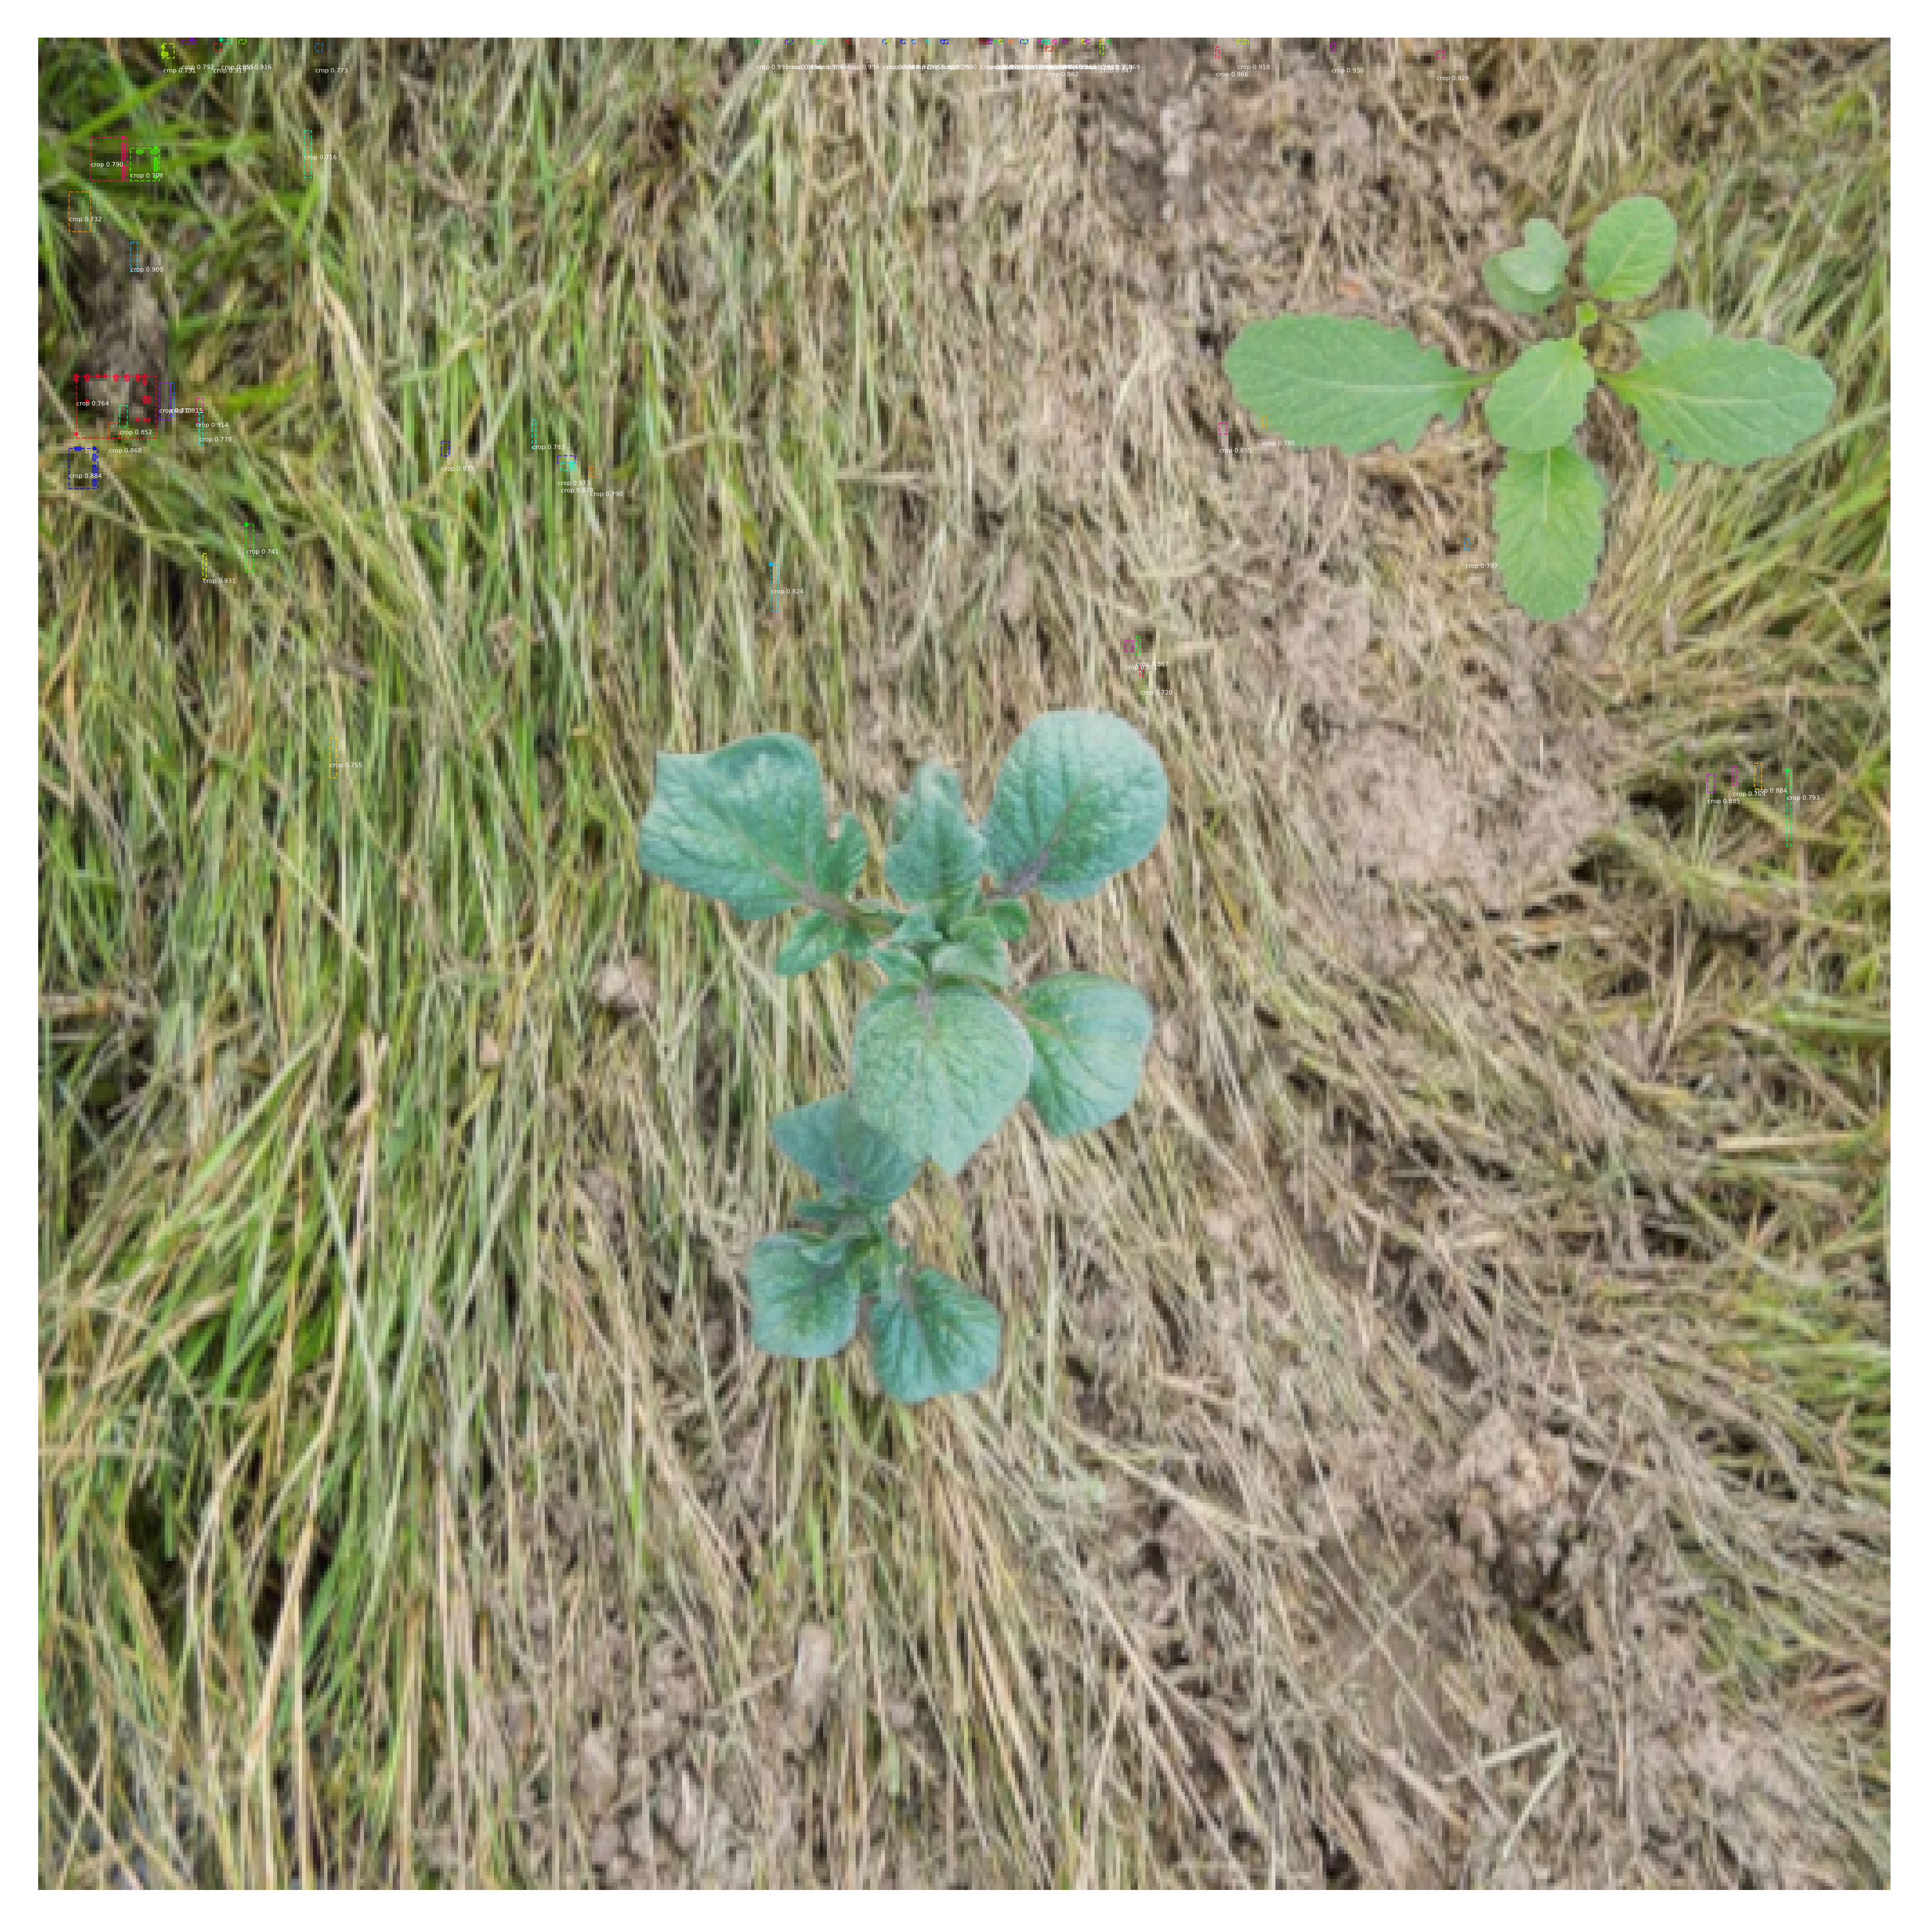

In [ ]:
import skimage

# real_test_dir = '../datasets/box_dataset_synthetic/test/images'
# image_paths = []
# for filename in os.listdir(real_test_dir):
#     if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
#         image_paths.append(os.path.join(real_test_dir, filename))

#for image_path in image_paths:
img = skimage.io.imread('/content/00000066.png')
img_arr = np.array(img)
results = model.detect([img_arr], verbose=1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], figsize=(64,64))